# Modeling the whole market
This notebook contains work that attempts to generate the best models possible to describe the behavior of the entire housing market over the time frame of the data. Several methods are employed to improve models, such as grid searching, use of exogenous variables such as fourier series, heteroscedasticity filtering, and limiting the time window. A smooth workflow which incorporates calling R functions using rpy2 is created that will help in modeling individual zip codes in the next notebook. 

#### Outline:
[Modeling the whole market](#modeling)<br>
>[Facebook Prophet](#fbproph)<br>
>[ARIMA on Prices](#arima_full)<br>
>[ARIMA on Returns](#arima_returns)<br>

In [2]:
# Importing the necessary libraries
from IPython.display import display
import itertools
import matplotlib.pyplot as plt
from functions import my_functions as mf
import numpy as np
from operator import itemgetter
import pandas as pd
from scipy import stats
from scipy.signal import periodogram
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.stats.stattools as st
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#import dataframe_image as di

In [4]:
%load_ext autoreload
%autoreload 1
%aimport my_functions

In [5]:
# Plot styling
plt.style.use('ggplot')
from jupyterthemes import jtplot
jtplot.style()

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 7

In [7]:
pd.plotting.register_matplotlib_converters()

## Loading DataFrame and Initial Feature Inspection

In [8]:
# Getting a look at the raw data
df = pd.read_csv('data/zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

<a id='data_preparation'></a>
# Data Preparation:

In [9]:
df.rename(columns={'RegionName':'zipcode'}, inplace=True)
# Dropping the SizeRank column, as well as the RegionID
df.drop(columns=['RegionID', 'SizeRank'], inplace=True)

In [10]:
# Melting dataframe to convert into Long Format
df = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'Metro', 'CountyName'], var_name='date')
df.head()

zipcode      City State              Metro CountyName     date     value
0    60657   Chicago    IL            Chicago       Cook  1996-04  334200.0
1    75070  McKinney    TX  Dallas-Fort Worth     Collin  1996-04  235700.0
2    77494      Katy    TX            Houston     Harris  1996-04  210400.0
3    60614   Chicago    IL            Chicago       Cook  1996-04  498100.0
4    79936   El Paso    TX            El Paso    El Paso  1996-04   77300.0

In [11]:
# Converting 'date' column to datetime format
df.date = pd.to_datetime(df.date, format='%Y-%m')
df.date.head()

0   1996-04-01
1   1996-04-01
2   1996-04-01
3   1996-04-01
4   1996-04-01
Name: date, dtype: datetime64[ns]

In [12]:
# checking 'value' column for missing data:
df.value.isna().sum()

156891

In [13]:
# There are many missing values, but I will leave them in place for now

# Grouping the data by zipcode
groups = df.groupby('zipcode')
len(groups)

14723

1001
1002
1005
1007
1008
1010


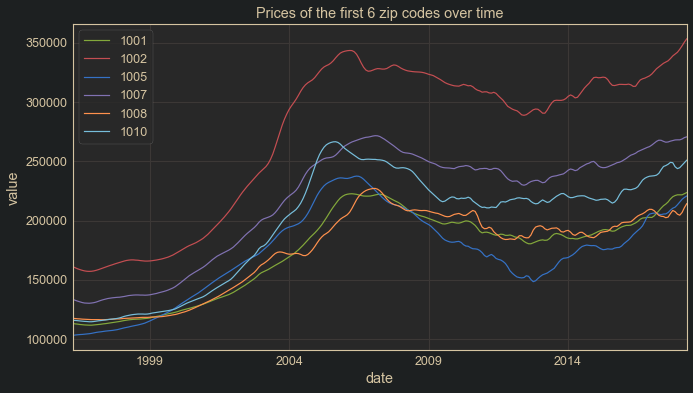

In [14]:
# A quick look at the first 6 zipcodes:
for i, (name, group) in enumerate(groups):
    print(name)
    group.set_index('date').value.plot(figsize=(11,6), alpha=1, label=name)
    if i >= 5:
        break
        
plt.ylabel('value')
plt.title('Prices of the first 6 zip codes over time')
plt.legend();

<a id='modeling'></a>
## Modeling:

### Importing cleaned market data

In [21]:
means = pd.read_csv('data/housing_means_clean.csv')
means.rename(columns={'Unnamed: 0': 'date',
                      'mean price': 'mean log price'
                     }, inplace=True)
means.date = pd.to_datetime(means.date, infer_datetime_format=True)
means.head()

date  mean log price
0 1996-04-01       11.514264
1 1996-05-01       11.515620
2 1996-06-01       11.516949
3 1996-07-01       11.518236
4 1996-08-01       11.519576

In [22]:
means.date

0     1996-04-01
1     1996-05-01
2     1996-06-01
3     1996-07-01
4     1996-08-01
         ...    
260   2017-12-01
261   2018-01-01
262   2018-02-01
263   2018-03-01
264   2018-04-01
Name: date, Length: 265, dtype: datetime64[ns]

In [23]:
means.set_index('date', inplace=True)

In [24]:
# Checking to see if index has an assigned frequency
means.index = pd.to_datetime(means.index, infer_datetime_format=True)
means.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=265, freq=None)

In [25]:
# Need to fix the dataframe to have an explicit frequency for statsmodels
means_fix = means.asfreq('MS')
means_fix.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='date', length=265, freq='MS')

<a id='fbproph'></a>
### Facebook Prophet on full data:
Before going into fitting SARIMAX models on the data, I want to see what kind of predictions fbprophet will make, just as a comparison/benchmark, since prophet's predictions are generally considered to be reliable.

In [26]:
# I am going to do a fbprophet forecast on the mean market data, to see how it behaves
from fbprophet import Prophet as proph

In [27]:
means_proph = means.copy()
means_proph.head()

mean log price
date                      
1996-04-01       11.514264
1996-05-01       11.515620
1996-06-01       11.516949
1996-07-01       11.518236
1996-08-01       11.519576

In [28]:
# Need to format the new dataframe for prophet
means_proph['ds'] = means_proph.index
means_proph['ds'] = means_proph['ds'].asfreq('MS')
means_proph.rename(columns={'mean log price':'y'}, inplace=True)
means_proph.head()

y         ds
date                            
1996-04-01  11.514264 1996-04-01
1996-05-01  11.515620 1996-05-01
1996-06-01  11.516949 1996-06-01
1996-07-01  11.518236 1996-07-01
1996-08-01  11.519576 1996-08-01

In [29]:
Model = proph(interval_width=0.95)
Model.fit(means_proph)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
# I will make projections 5yrs into the future, as this seems to be a good time horizon for
# real estate investment.
future_dates = Model.make_future_dataframe(periods=60, freq='MS')
predictions = Model.predict(future_dates)
pred_subset = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

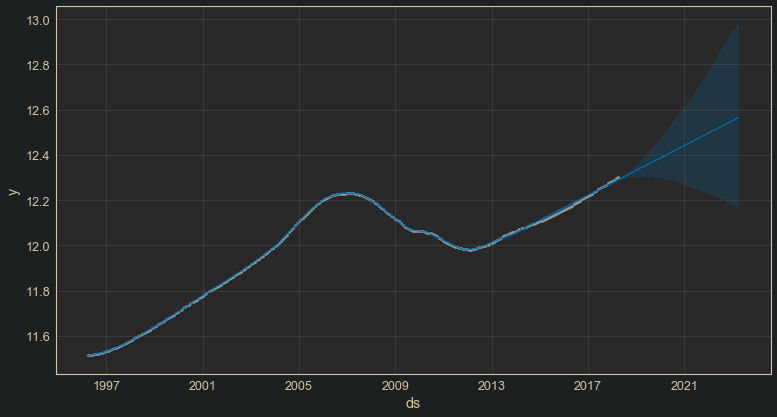

In [31]:
fig, ax = plt.subplots(figsize=(11, 6))
Model.plot(predictions, uncertainty=True, ax=ax);

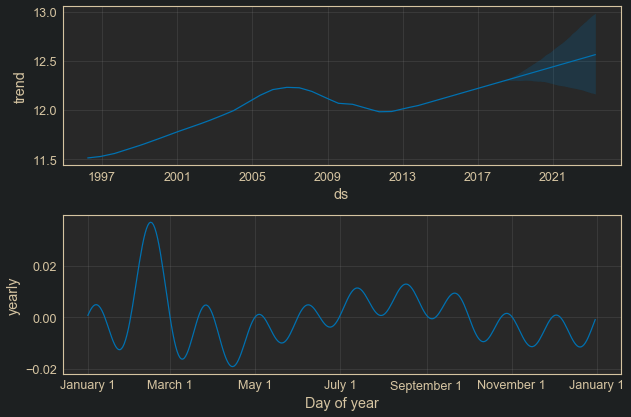

In [32]:
#fig, ax = plt.subplots(figsize=(11, 6))
ax = Model.plot_components(predictions)
ax.set_facecolor(plt.rcParams.get('figure.facecolor'))

We can see that Prophet has done its under-the-hood magic, and produced forecasts that are essentially a linear continuation of the trend after the market crash, with a confidence window that incorporates a possible second crash around the years 2020-2021. This is a pretty good result, considering that it was fast and seems to cover the different scenarios of the future market. It will be interesting to see how this stacks up to an ARIMA model on the same data (knowing that the data will be heteroscedastic, these models will still perform decently).

### Facebook Prophet on Returns:

In [37]:
log_returns = means_fix.diff().dropna()
log_returns.columns = ['log returns']
returns_proph = log_returns.copy()
returns_proph.head()

log returns
date                   
1996-05-01     0.001356
1996-06-01     0.001328
1996-07-01     0.001287
1996-08-01     0.001340
1996-09-01     0.001482

In [38]:
# Need to format the new dataframe for prophet
returns_proph['ds'] = returns_proph.index
returns_proph['ds'] = returns_proph['ds'].asfreq('MS')
returns_proph.rename(columns={'log returns':'y'}, inplace=True)
returns_proph.head()

y         ds
date                           
1996-05-01  0.001356 1996-05-01
1996-06-01  0.001328 1996-06-01
1996-07-01  0.001287 1996-07-01
1996-08-01  0.001340 1996-08-01
1996-09-01  0.001482 1996-09-01

In [39]:
Model = proph(interval_width=0.95)
Model.fit(returns_proph)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
# I will make projections 5yrs into the future, as this seems to be a good time horizon for
# real estate investment.
future_dates = Model.make_future_dataframe(periods=60, freq='MS')
predictions = Model.predict(future_dates)
pred_subset = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

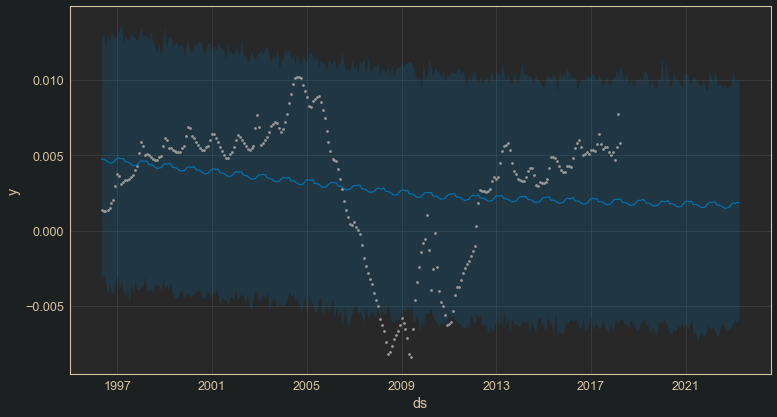

In [41]:
fig, ax = plt.subplots(figsize=(11, 6))
Model.plot(predictions, uncertainty=True, ax=ax);

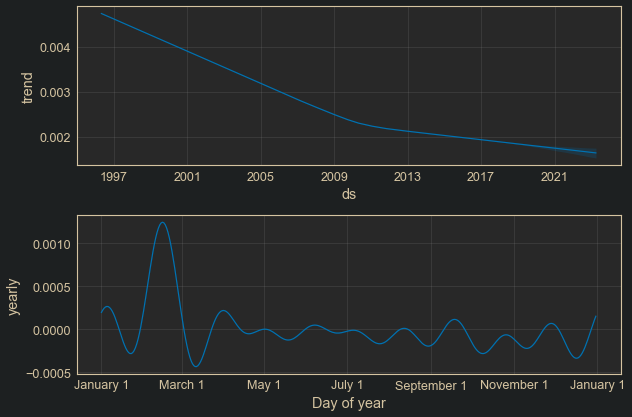

In [42]:
#fig, ax = plt.subplots(figsize=(11, 6))
ax = Model.plot_components(predictions)
ax.set_facecolor(plt.rcParams.get('figure.facecolor'))

Facebook prophet seems to have exhibited some interesting behavior on the log returns... But it does seem to have also indicated some yearly seasonality. It looks as though the model is trying to indicate that the average monthly returns of real estate investment is diminishing, and might be expected to into the next few years.

<a id='arima_full'></a>
### ARIMA on full data:

I'm now going to fit an ARIMA model to the means data, just to compare to facebook prophet, knowing that there is a special event taking place with the crash, and that the conditional heteroscedasticity violates the stationarity assumption.

### Looking at autocorrelation
In the last notebook, we determined that the series of mean log price over all zip codes by date could be made stationary by taking two orders of differencing. Since the prices are logged, the first difference is equivalent to log returns, so two orders of differencing is equivalent to differenced log returns.

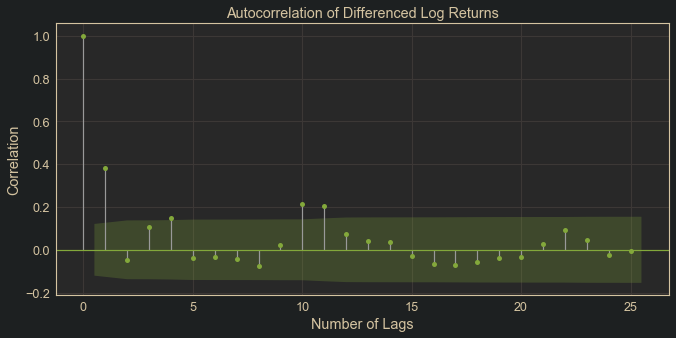

In [44]:
# First a look at an ACF for the stationary series produced by a 2nd order differencing
# Note that a sharp dropoff past a certain value would inform us of a potential order for 
# MA terms
fig, ax = plt.subplots(figsize=(11,5))
plot_acf(log_returns.diff().dropna(), 
          #lags = len(trend.dropna())-1, 
          ax=ax)
plt.xlabel('Number of Lags')
plt.ylabel('Correlation')
plt.title('Autocorrelation of Differenced Log Returns')
plt.show()

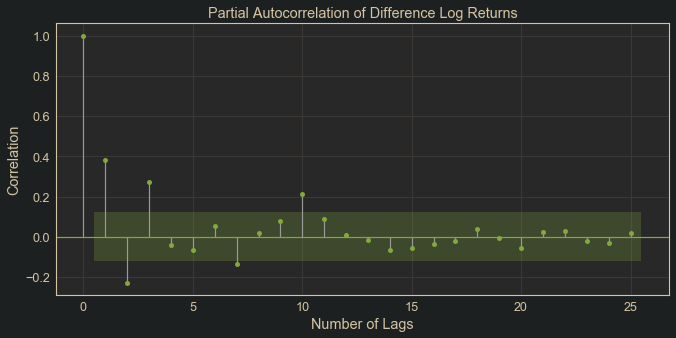

In [45]:
# We can see above that the ACF drops off after 1 lag, meaning an MA(1) model may be appropriate
# There are also significant spikes at 10 and 11 lags
# Now a look at a PACF for the series. Note that a sharp dropoff after a lag will indicate a
# potential order for AR terms, and a taper past a lag would be further evidence for an order
# of MA terms
fig, ax = plt.subplots(figsize=(11,5))
plot_pacf(log_returns.diff().dropna(), 
          #lags = len(trend.dropna())-1, 
          ax=ax)
plt.xlabel('Number of Lags')
plt.ylabel('Correlation')
plt.title('Partial Autocorrelation of Difference Log Returns');

In [162]:
# We can see that there is a taper after the 1st lag, and also another spike at 10
# So far, an MA(1) model after an order of differencing looks appropriate

In [46]:
# Let's start with letting the max p, d, and q be 2
p = d = q = range(0, 3)

# Generating all combos of p, d, and q
pdq = list(itertools.product(p, d, q))

# Since we saw potential yearly seasonality earlier, I will use a s value of 12, and make 
# necessary combinations. I will also include a full set of zeros for non-seasonality:
pdqs = [(x[0], x[1], x[2], 12) for x in pdq] + [(0,0,0,0)]

In [47]:
# checking pdq
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [48]:
# checking pdqs
pdqs

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12),
 (0, 0, 0, 0)]

In [49]:
len(pdq)*len(pdqs)

756

In [50]:
combos = np.zeros(len(pdq)*len(pdqs))
aic_values = np.zeros(len(pdq)*len(pdqs))
scores = {}

for combo in pdq:
    for scombo in pdqs:
        model_params = (combo, scombo)
        scores[model_params] = np.NaN
        try:
            model = SARIMAX(means_fix,
                              order=combo,
                              seasonal_order=scombo,
                              enforce_stationarity=False,
                              enforce_invertibility=False
                             )
            output = model.fit()
            scores[model_params] = output.aic
            
        except:
            print("Error with parameters:", model_params)
            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [51]:
len(scores)

756

In [52]:
# Noting that this is taking a long time, whereas the auto.arima() function in R is very fast,
# it will be interesting to compare the results, after the wait. Note that the result from the
# R notebook was (0, 2, 1) with no seasonality, resulting in an AIC of 3222.27

# Another note is that this is taking a REALLY long time, so that it would not be possible to 
# generate a model in this way for each individual zipcode. It may be necessary to find the
# optimal pdq values generated by a model on the means, then apply those parameters to each
# zipcode, or it might be fast enough to use the auto.arima() function in R for each zipcode,
# allowing for more flexibility with the different data in each zipcode.

In [53]:
# Find the parameters with minimal AIC value
# Note that the algebraically lower scores are better, even if they are negative. So larger
# negative AICs are better.
ideal_params = min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params))
#print(ideal_params)

Optimal AIC of -3204.556363853556 with params: ((1, 1, 1), (0, 0, 0, 12))


In [54]:
model = SARIMAX(means_fix,
                order=ideal_params[0],
                seasonal_order=ideal_params[1],
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         mean log price   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1616.068
Date:                Fri, 11 Sep 2020   AIC                          -3226.137
Time:                        13:04:17   BIC                          -3215.409
Sample:                    04-01-1996   HQIC                         -3221.826
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9885      0.010    101.126      0.000       0.969       1.008
ma.L1          0.5320      0.036     14.579      0.000       0.460       0.604
sigma2      2.761e-07   1.06e-08     25.928      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [55]:
# For some reason, the AIC of this model does not match the score from the grid search...
# I have reviewed the code and have no explanation for this.

TypeError: float() argument must be a string or a number, not 'Period'

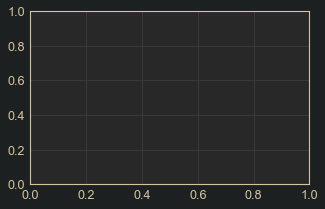

In [56]:
model.plot_diagnostics();

In [565]:
# The AIC is different, there seems to be a bug
# I will build a nested for loop and see if this gets rid of the bug
scores = {}
rang = range(0,3)

for p in rang:
    for d in rang:
        for q in rang:
            for sp in rang:
                for sd in rang:
                    for sq in rang:
                        model_params = ((p,d,q), (sp,sd,sq,12))
                        scores[model_params] = np.NaN
                        try:
                            sarimax = SARIMAX(means_fix,
                                              order=(p,d,q),
                                              seasonal_order=(sp,sd,sq,12),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False
                                             )
                            output = sarimax.fit()
                            scores[model_params] = output.aic

                        except:
                            print("Error with parameters:", model_params)
                            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

In [566]:
# Find the parameters with minimal AIC value
ideal_params2= min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params2))
#print(ideal_params)

Optimal AIC of -3204.5563471320424 with params: ((1, 1, 1), (0, 0, 0, 12))


In [ ]:
# Again, the grid search has produced an AIC value that is different from what I get when I run
# the model with the same parameters. Interestingly enough, the misreported AIC values are
# the same from both grid searches. I will come back to this.

In [57]:
# In response to this problem, I will call auto.arima function from R, which is an efficient way
# to get optimal parameters for ARIMA models

In [58]:
# Allows you to import r packages
from rpy2.robjects.packages import importr

In [59]:
# How to install r packages from python
#utils = importr('utils')
#utils.install_packages('forecast')

In [60]:
# Import desired package(s)
importr('forecast')

rpy2.robjects.packages.Package as a <module 'forecast'>

In [66]:
# Will convert python lists to a R style FloatVector
from rpy2.robjects import FloatVector
# Allows R function to be called as dictionary keys
from rpy2.robjects import r

In [67]:
# Convert series into a usable format
FloatVector(means_fix['mean log price'])

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x000002D1D440CA48 / R:0x000002D1D47A0D08>
[11.514264, 11.515620, 11.516949, 11.518236, ..., 12.283881, 12.289423, 12.297175, 12.303019]

In [68]:
autoarima = r['auto.arima'](r['ts'](FloatVector(means_fix['mean log price']), freq=12), 
                            seasonal=True,
                           )

In [69]:
print(autoarima)

Series: structure(c(11.5142636560835, 11.5156201149108, 11.5169485751824,  11.5182357576629, 11.5195757467557, 11.5210575971359, 11.5228841489884,  11.5249333014024, 11.5278829306489, 11.5316086082182, 11.535252316171,  11.5383534954782, 11.5415904538513, 11.5449263757948, 11.54830457405,  11.5517305429253, 11.5552601274276, 11.5589619578487, 11.5630126618771,  11.5673044536636, 11.5724822697232, 11.578333641924, 11.5839786994788,  11.5890169642435, 11.5941094198777, 11.5991079190941, 11.6040011697805,  11.6087765989047, 11.6134920813558, 11.6181866190224, 11.6230718089739,  11.6280522465346, 11.6336840083587, 11.6398526349363, 11.6458408132802,  11.6512929777247, 11.6567625445083, 11.6621346678752, 11.6674173362969,  11.6726227747144, 11.6778141452453, 11.6830376187281, 11.6885137086376,  11.6941535701393, 11.7004552784774, 11.7073544441803, 11.7141693716779,  11.7204271709258, 11.7265550433744, 11.7324668468003, 11.7381735593981,  11.7436797558414, 11.7490539850659, 11.7543890300087,

In [70]:
# Extracting the model parameters by making output into a string:
string = str(autoarima).split('ARIMA')[1].split(' ')[0]
if len(string) < 8:
    param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
    sparam = (0,0,0,0)
else:
    params = tuple(int(x) for x in string.replace('(','').replace(')',',')
                   .replace('[','').replace(']','').split(','))
    param = params[:3]
    sparam = params[3:]
print(param)
print(sparam)

(0, 2, 1)
(0, 0, 0, 0)


In [71]:
# The auto.arima function is recommending an ARIMA(0,2,1) model with no seasonality. Note that
# this matches our prediction from the ACF/PACF graphs of a MA(1) model on the differenced
# log returns, as two orders of differencing on the original data is equivalent

In [72]:
# Trying the model with the parameters recommended from auto.arima
# Note that it is taking 2nd order differencing. Since we are using the mean values of log sales
# prices, the first order of differencing is log returns, then the second order of differencing
# is effectively a 1st order difference if we were modeling log returns.
model = SARIMAX(means_fix['mean log price'],
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         mean log price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood                1613.160
Date:                Fri, 11 Sep 2020   AIC                          -3222.321
Time:                        13:05:50   BIC                          -3215.176
Sample:                    04-01-1996   HQIC                         -3219.450
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6281      0.036     17.502      0.000       0.558       0.698
sigma2      2.737e-07   9.72e-09     28.162      0.000    2.55e-07    2.93e-07
Ljung-Box (L10) (Q):                 34.05   Jarque-

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [74]:
pd.plotting.register_matplotlib_converters()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


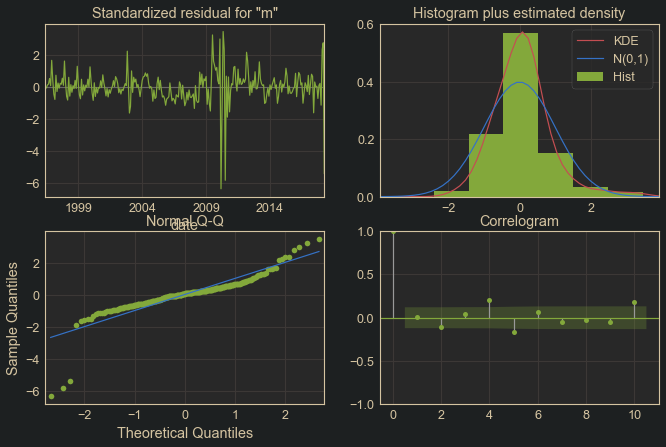

In [75]:
model.plot_diagnostics(figsize=(11,7));

In [76]:
# Diagnosing the model, we can see that the null hypothesis of the Ljung-Box test that the
# residuals are not autocorrelated is rejected, and some significant autocorrelation can be
# seen in the correlogram of residuals.
# We can also see that the null hypothesis of the Heteroskedasticity test, which is that the
# residuals are not heteroskedastic, is rejected
# The kurtosis is quite high and thus the JB test null hypothesis of normal skew and kurtosis
# of residuals is rejected. This is due to the period of volatility clustering as the market
# began to recover

In [ ]:
# Looking closer at the residuals, we can see that the mild yearly seasonality is present,
# but that it seems like it may shift out of phase after the first few years, and become less
# uniform. This may be an example of a profitable signal being arbitraged out of a market when
# investors become keen to it and begin to exploit it.

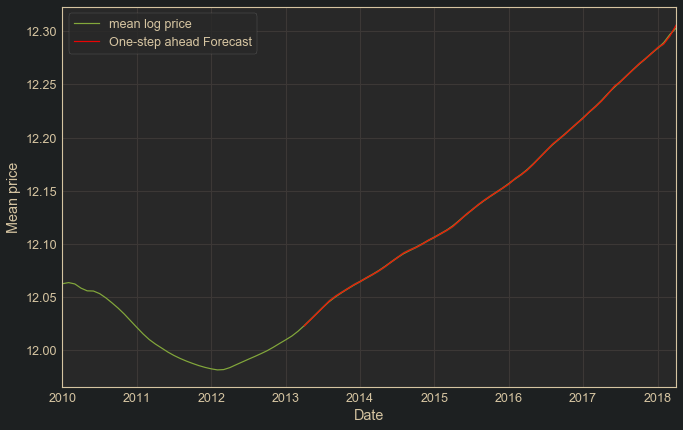

In [79]:
# Get predictions
pred = model.get_prediction('2013-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means['2010':].plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [80]:
forecasted = pred.predicted_mean
truth = means_fix['2013-04':'2018-04']['mean log price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 7)))

The Mean Squared Error of our forecasts is 3e-07


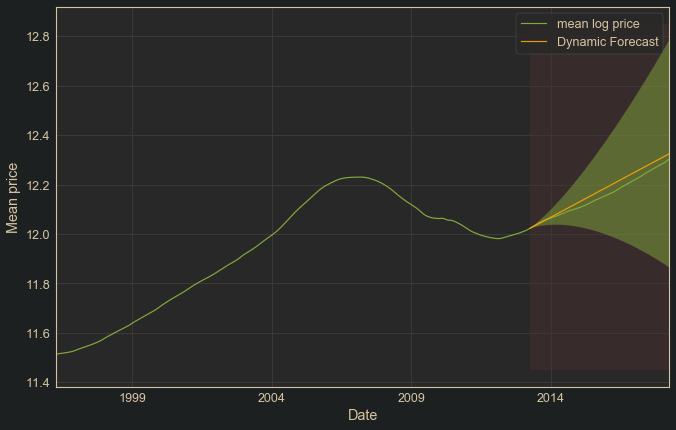

In [81]:
# We can see that the one step ahead forecasts were fairly accurate on the training data,
# let's look now at the dynamic forecast from the same date

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

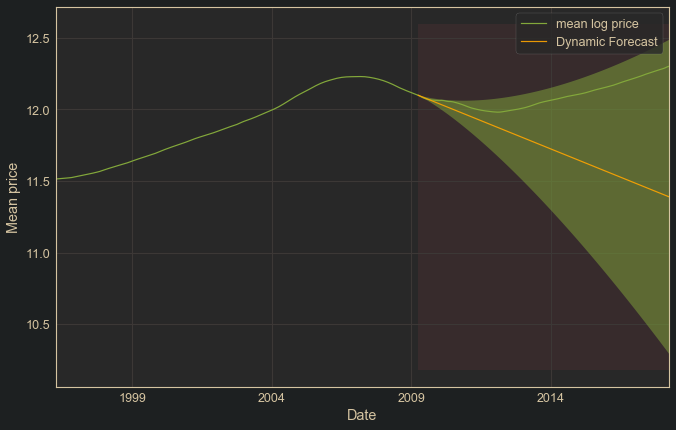

In [82]:
# We can see that this went pretty well, the orange line of the projected means falls pretty
# close to the actual line
# We can check how this model would have performed back just before the area of high volatility
# Around 2010, and whether the true events fell within its confidence

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2009-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2009-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

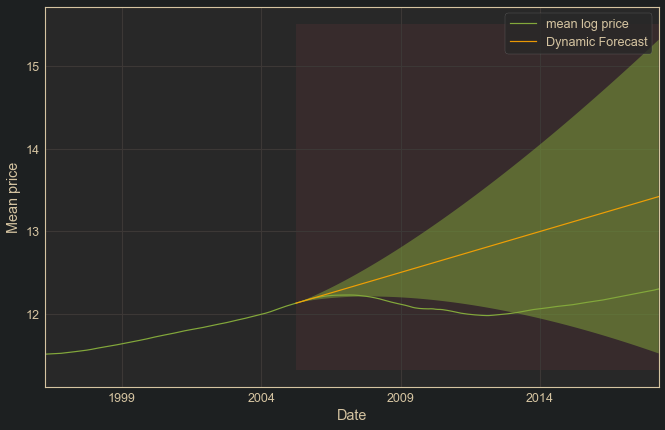

In [83]:
# We can see that even in the area when the model had the most trouble due to the conditional
# variance at the time, the dynamic projection still had confidence intervals which contained
# the true events. This shows that the model shows ability to show best case and worse case
# scenarios at any time looking forward. Let's look again at what it would do just before the
# crash
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2005-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2005-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

We can see that the market took a dramatic turn during the crash, which went outside the confidence bands, but ultimately fell back in. Interpreting the model, it is actually a very simple model, with 2 orders of difference and a single moving average term. This is a very general model, which is not overfit. It is merely taking two orders of differencing, which is the differenced log returns, then it has one moving average term.

In [84]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

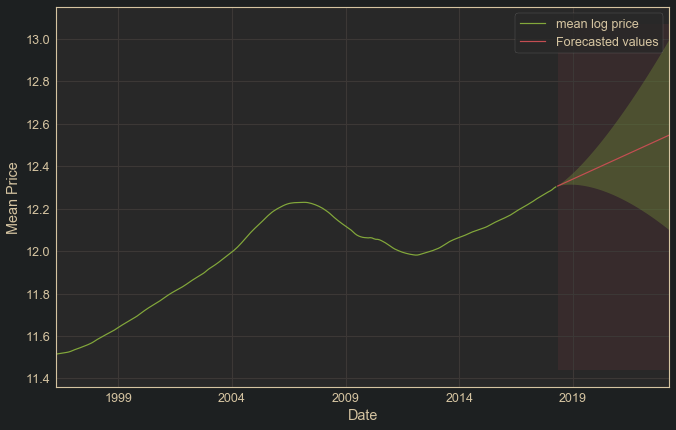

In [85]:
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [86]:
# This looks very similar to the forecast results from the fbprophet model.
# This model is fairly decent, and simple. The test for heteroscedasticity rejected the null
# hypothesis of homoscedastic residuals, and we can see from the chart of residuals that this
# is due to the period of high volatility as the market began to make a recovery. Since this
# is an event caused by macroeconomic factors, it would not be possible to account for it in the
# model without having some sort of exogenous variable
# If we ignore this period of volatility clustering, the residuals appear as though they would
# be stationary and homoscedastic, so the model is appropriate for the majority of the data

In [57]:
# I would now like to do another grid search, this time leaving out the seasonal component
# altogether, to see if python reaches the same result as auto.arima() in this way
scores = {}
for combo in pdq:
    scores[combo] = np.NaN
    sarimax = SARIMAX(means_fix,
                      order=combo,
                      enforce_stationarity=False,
                      enforce_invertibility=False
                     )
    output = sarimax.fit()
    scores[combo] = output.aic

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

In [58]:
# Find the parameters with minimal AIC value
ideal_params = min(scores, key=scores.get)
print("Optimal AIC of {} with params: {}".format(min(scores.values()), ideal_params))

Optimal AIC of -3204.556363853556 with params: (1, 1, 1)


In [59]:
# Again, we have an AIC which doesn't match with what we get when we run a model with these
# parameters
# Let's make sure the scores were encoded as expected
scores

{(0, 0, 0): 2062.505512686851,
 (0, 0, 1): 2054.6718753931455,
 (0, 0, 2): 1915.213116388422,
 (0, 1, 0): -2005.1640731130572,
 (0, 1, 1): -2342.3568920488906,
 (0, 1, 2): -2488.49651318476,
 (0, 2, 0): -3131.7488721241166,
 (0, 2, 1): -3196.216441975474,
 (0, 2, 2): -3171.354377487537,
 (1, 0, 0): -2110.298062489691,
 (1, 0, 1): -2367.140960055398,
 (1, 0, 2): -2734.75684040604,
 (1, 1, 0): -3143.1158381074674,
 (1, 1, 1): -3204.556363853556,
 (1, 1, 2): -3167.9065581789955,
 (1, 2, 0): -3173.019773916772,
 (1, 2, 1): -3023.4501571083856,
 (1, 2, 2): -3166.299636894374,
 (2, 0, 0): -3141.95287432276,
 (2, 0, 1): -3203.3883103746616,
 (2, 0, 2): -3141.125503247641,
 (2, 1, 0): -3172.740545189348,
 (2, 1, 1): -3200.5906557039607,
 (2, 1, 2): -3167.623543164328,
 (2, 2, 0): -3178.732991485969,
 (2, 2, 1): -3143.5377152135616,
 (2, 2, 2): -3190.542343357776}

In [87]:
# This does seem to produce a lower AIC score, let's see this model
model = SARIMAX(means_fix,
                order=(1,1,1),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         mean log price   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood                1616.068
Date:                Fri, 11 Sep 2020   AIC                          -3226.137
Time:                        13:17:41   BIC                          -3215.409
Sample:                    04-01-1996   HQIC                         -3221.826
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9885      0.010    101.126      0.000       0.969       1.008
ma.L1          0.5320      0.036     14.579      0.000       0.460       0.604
sigma2      2.761e-07   1.06e-08     25.928      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [88]:
model.aic

-3226.1366864393485

In [89]:
# Interestingly enough, the grid search has yet again deceived me in the AIC that the model
# parameters produce. This method has simply not paid off so far in this way. However, the
# model it recommends does actually turn out to have a lower AIC score than the auto.arima
# recommended model. Let's look at it

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


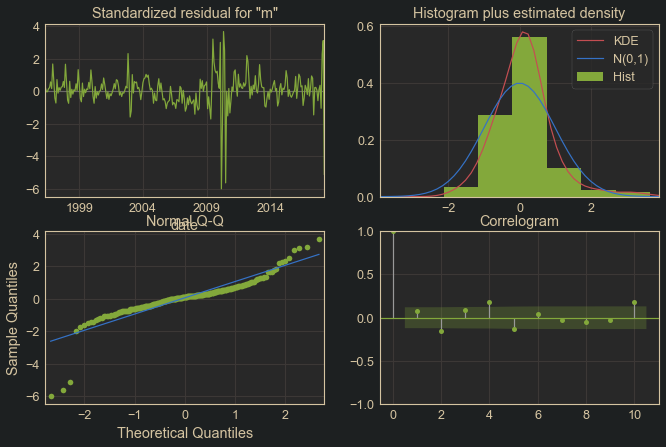

In [90]:
# We can see that the null hypotheses of non-correlated and homoscedastic residuals are both
# rejected. The Jarque-Bera test null hypothesis of normal residuals is also rejected.
model.plot_diagnostics();

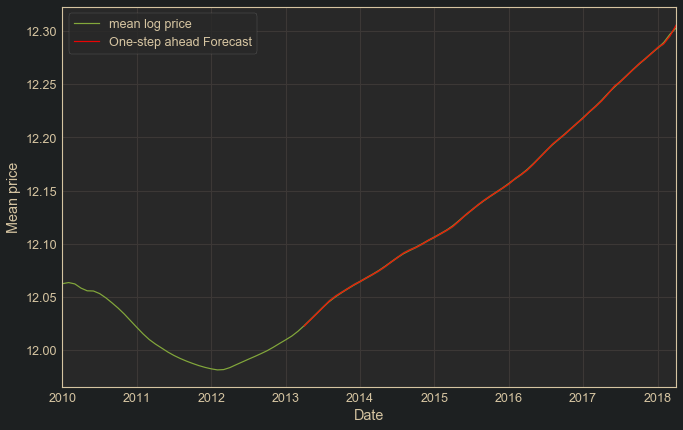

In [91]:
# Get predictions
pred = model.get_prediction('2013-04', '2018-04', dynamic=False)
pred_conf = pred.conf_int()
# Plot observed values
ax = means['2010':].plot(label='observed')
# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [92]:
forecasted = pred.predicted_mean
truth = means_fix['2013-04':'2018-04']['mean log price']

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 7)))

The Mean Squared Error of our forecasts is 3e-07


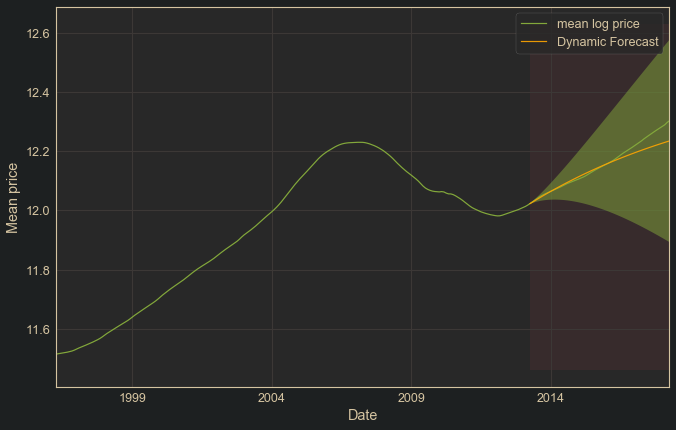

In [93]:
# We can see that the one step ahead forecasts were similar to the last model in error

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

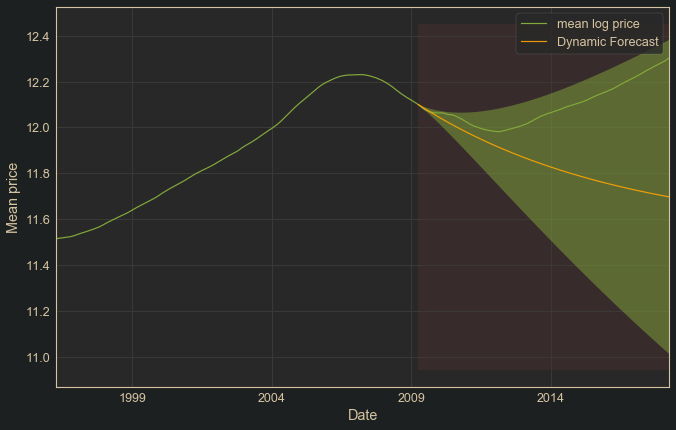

In [94]:
# We can see that this model, while very similar in its diagnostics, seems to have a bit of 
# a downturn in dynamic projections, likely a result of the AR(1) parameter.
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2009-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2009-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

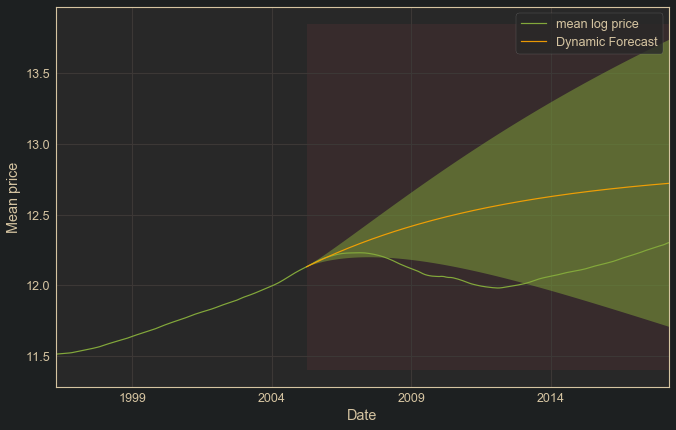

In [95]:
# It appears that the AR term is introducing a bit of resistance to the ongoing trend at the
# time. Let's look further back
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2005-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2005-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [96]:
# We can see the figtht against the ongoing trend here as well. The market crash was unanticipated
# by both models so far.

In [97]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

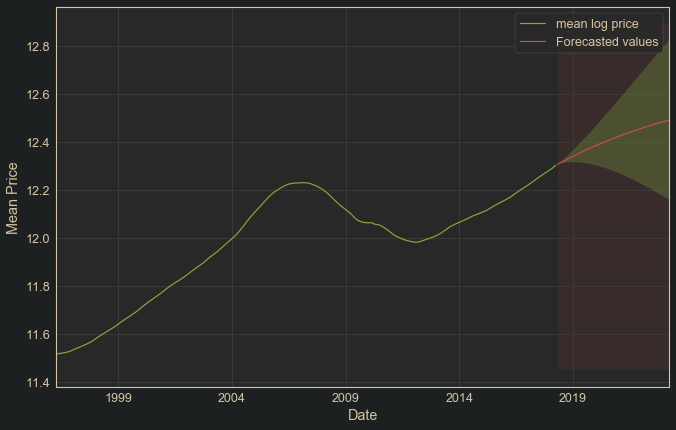

In [98]:
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

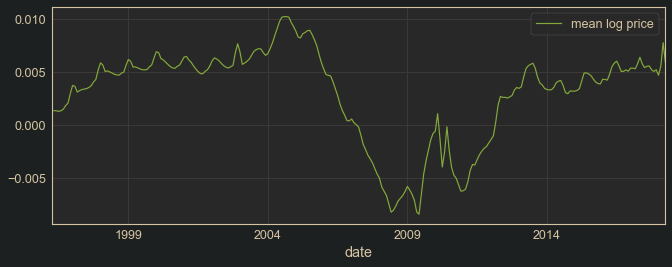

In [99]:
# We can see here a similar projection to our last model, but just a bit more pessimistic by 
# it's fight against the ongoing trend. Although this model has seems relatively sound,
# when we analyze the terms in the model, there is only one degree of 
# differencing. The point of differencing is to make the data you are working with stationary,
# and since earlier we showed that one order of differencing wasn't enough to make the series
# fully stationary, it means that the assumption of the model that the input data is stationary
# is violated, making it technically not as good of a model as the one before, with two orders
# of differencing. Let's look at the 1st ordered difference series again:
means_fix.diff().plot(figsize=(11,4))

In [100]:
# This is visibly non-stationary data
# We can recall from earlier that the Augmented Dickey-Fuller test did not reject the null
# hypothesis for non-stationarity of this data

In [101]:
dftest = adfuller(means_fix['mean log price'].diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print("Dickey-Fuller Results for Differenced Means:\n================================\n",dfoutput)

Dickey-Fuller Results for Differenced Means:
 Test Statistic                  -1.942736
p-value                          0.312231
#Lags Used                      14.000000
Number of Observations Used    249.000000
dtype: float64


There is a function in R that I'd like to get to use through python is the fourier() function from the 'forecast' package. It generates a Fourier series for the input data, which can be used as exogenous terms in an ARIMA function.

To do this, I will take a bit of a detour into generating Fourier Series from R using python. Note that this ultimately does not come in handy for this project, but definitely could in the future.

In [102]:
# Earlier the periodogram showed a strong spike at the full-length period of the data, and the
# halfway point. I discussed how this is an artifact of the way that the periodogram is made,
# but one thing I noticed is that the half-period spike is higher than it would be for the 
# random data experiment from the R notebook. This means that there may be more to investigate
# here than just an artifact of the math, let's see
fs = r['fourier'](r['ts'](FloatVector(means_fix['mean log price']), f=132.5), K=2)

In [103]:
fs

R object with classes: ('matrix',) mapped to:
<Matrix - Python:0x000002D1D6CF2088 / R:0x000002D1D45CD298>
[0.047402, 0.094698, 0.141781, 0.188546, ..., 0.959796, 0.982064, 0.995506, 1.000000]

In [104]:
# We can see that the returned matrix is one dimensional, whereas it should be 2
# Looking at the comparable result from the R notebook, it looks like the columns have been
# laid end to end, we can set up the appropriate dataframe as below
two_d = list(zip(fs[:265], fs[265:]))
two_d

[(0.04740249628668982, 0.9988758698385852),
 (0.0946984194217752, 0.9955060066915807),
 (0.14178143585783998, 0.9898979868885931),
 (0.18854569071715174, 0.9820644187180351),
 (0.23488604578098365, 0.9720229140804107),
 (0.28069831586769994, 0.9597960488921784),
 (0.32587950306816577, 0.9454113123292133),
 (0.37032802831186007, 0.9289010450239843),
 (0.4139439597430692, 0.9103023663553931),
 (0.45662923739371303, 0.8896570909947473),
 (0.4982878936476807, 0.8670116348954942),
 (0.5388262690010142, 0.8424169109380739),
 (0.5781532226328543, 0.8159282144645111),
 (0.616180337313733, 0.7876050989600907),
 (0.6528221181905216, 0.7575112421616201),
 (0.6879961850011169, 0.7257143028933003),
 (0.7216234572867163, 0.6922857689520757),
 (0.7536283321852749, 0.6573007963844566),
 (0.7839388544064212, 0.6208380405161622),
 (0.8124868780056812, 0.5829794791144721),
 (0.8392082195943015, 0.5438102280808652),
 (0.8640428026402155, 0.5034183500883153),
 (0.8869347925357273, 0.4618946565934774),
 (0.

In [105]:
# This can be easily fit into a DataFrame
fourier_series = pd.DataFrame(two_d)
fourier_series.head()

0         1
0  0.047402  0.998876
1  0.094698  0.995506
2  0.141781  0.989898
3  0.188546  0.982064
4  0.234886  0.972023

In [106]:
log_returns.index.is_all_dates

True

In [107]:
means.index.freqstr

In [108]:
# Now to make a function to get everything together properly:
def fourier_series(data, freqs, K, h=None):
    type1 = type(pd.DataFrame())
    type2 = type(pd.Series())
    if type(data) != type1 and type(data) != type2:
        raise ValueError("Input data must be a Pandas DataFrame or Series")
    if type(data) == type1:
        if len(data.columns) > 1:
            raise ValueError("Input DataFrame must have only one column")
        else:
            data = data.iloc[:,0]
    
    from rpy2.robjects.packages import importr
    from rpy2.robjects import FloatVector
    from rpy2.robjects import r
    importr('forecast')
    
    index = data.index
    length = len(data)
    
    #for col in data:
    rlist = FloatVector(data)
    fourier_terms = pd.DataFrame()
    for freq in freqs:
        if not h:
            fs = r['fourier'](r['ts'](rlist, f=freq), K=K)
        else:
            fs = r['fourier'](r['ts'](rlist, f=freq), K=K, h=h)

        length = int(len(fs)/(2*K))
        for i in range(K):
            columns = ['S'+str(i+1)+'-'+str(round(freq, 2)), 
                       'C'+str(i+1)+'-'+str(round(freq, 2))]
            # split sine and cosine values:
            i *= 2
            s = fs[i*length:(i+1)*length]
            c = fs[(i+1)*length:(i+2)*length]
            fourier_terms = pd.concat([fourier_terms, 
                                       pd.DataFrame(list(zip(s,c)), columns=columns)],
                                      axis=1
                                     )
    
    if not h:
        fourier_terms.index = index
    else:
        if data.index.is_all_dates:
            freq = data.index.freqstr
            future_index = pd.date_range(start=data.index[-1], periods=h+1, freq=freq)[1:]
            fourier_terms.index = future_index
    
    return fourier_terms

In [112]:
fs = fourier_series(means_fix, freqs=[265, 132.5], K=2)
fs.tail()

S1-265    C1-265    S2-265    C2-265  S1-132.5  C1-132.5  \
date                                                                     
2017-12-01 -0.094698  0.995506 -0.188546  0.982064 -0.188546  0.982064   
2018-01-01 -0.071070  0.997471 -0.141781  0.989898 -0.141781  0.989898   
2018-02-01 -0.047402  0.998876 -0.094698  0.995506 -0.094698  0.995506   
2018-03-01 -0.023708  0.999719 -0.047402  0.998876 -0.047402  0.998876   
2018-04-01  0.000000  1.000000  0.000000  1.000000  0.000000  1.000000   

            S2-132.5  C2-132.5  
date                            
2017-12-01 -0.370328  0.928901  
2018-01-01 -0.280698  0.959796  
2018-02-01 -0.188546  0.982064  
2018-03-01 -0.094698  0.995506  
2018-04-01  0.000000  1.000000

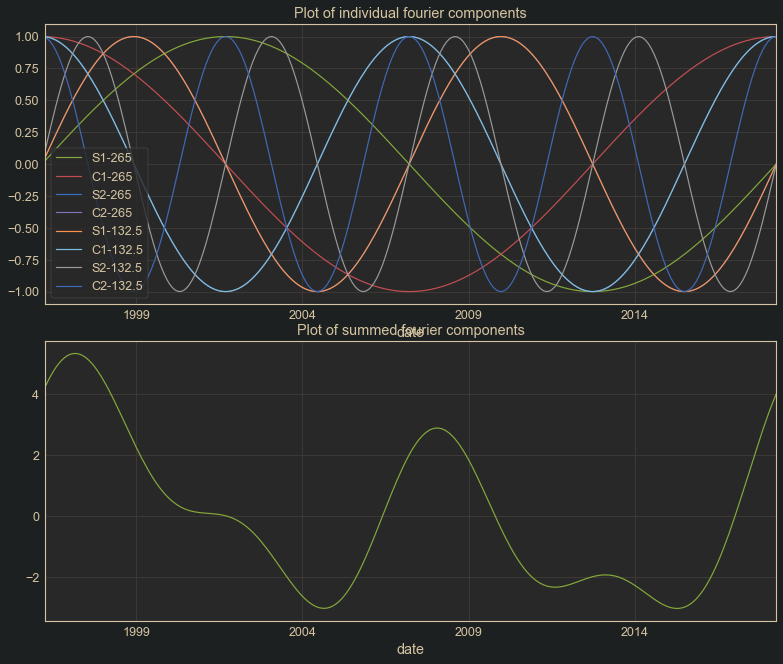

In [115]:
# A quick look at what we made
fig, (ax1, ax2) = plt.subplots(2, figsize=(11,9))
plt.tight_layout()
fs.plot(ax=ax1)
ax1.set_title('Plot of individual fourier components')
fs.sum(axis=1).plot(ax=ax2)
ax2.set_title('Plot of summed fourier components')
plt.show()

In [90]:
# We can see the first and second harmonics of sine and cosine here

In [116]:
fs = fourier_series(means_fix, freqs=[265, 132.5], K=2, h=60)
fs.head()

S1-265    C1-265    S2-265    C2-265  S1-132.5  C1-132.5  \
2018-05-01  0.023708  0.999719  0.047402  0.998876  0.047402  0.998876   
2018-06-01  0.047402  0.998876  0.094698  0.995506  0.094698  0.995506   
2018-07-01  0.071070  0.997471  0.141781  0.989898  0.141781  0.989898   
2018-08-01  0.094698  0.995506  0.188546  0.982064  0.188546  0.982064   
2018-09-01  0.118273  0.992981  0.234886  0.972023  0.234886  0.972023   

            S2-132.5  C2-132.5  
2018-05-01  0.094698  0.995506  
2018-06-01  0.188546  0.982064  
2018-07-01  0.280698  0.959796  
2018-08-01  0.370328  0.928901  
2018-09-01  0.456629  0.889657

In [118]:
# Fitting the simple model using a Fourier Series as exogenous predictors
fs = fourier_series(means_fix, freqs=[132.5], K=2)
model = SARIMAX(means_fix,
                order=(0,2,1),
                #seasonal_order=(0,1,1,12),
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:         mean log price   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood                1615.884
Date:                Fri, 11 Sep 2020   AIC                          -3219.768
Time:                        13:26:47   BIC                          -3198.335
Sample:                    04-01-1996   HQIC                         -3211.155
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-132.5      -0.0237      0.044     -0.539      0.590      -0.110       0.063
C1-132.5       0.0585      0.042      1.389      0.165      -0.024       0.141
S2-132.5      -0.0052      0.011     -0.453      0.6

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


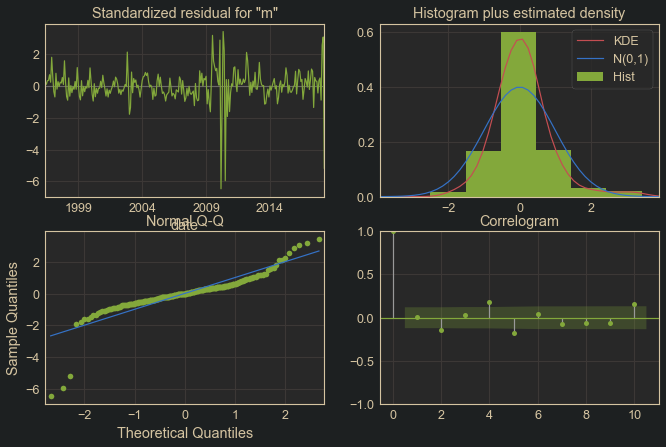

In [119]:
# We can see that the fourier terms did not aid the model much in this case, and has insignificant
# coefficients. This all may come in handy for future datasets, however.
model.plot_diagnostics(figsize=(11,7));

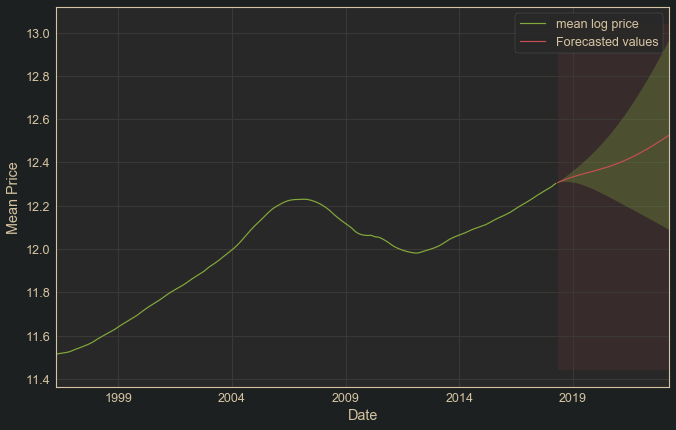

In [120]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60, exog=fourier_series(means_fix, freqs=[132.5], K=2, h=60))

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

That function is working properly, although it does not seem to be useful so far. It should prove useful in the future.<br>
<br>
I'd like to see if using the fourier_series function on the seasonal component of a seasonal decomposition might aid a model, let's try that now.

In [121]:
decomposition = seasonal_decompose(log_returns)

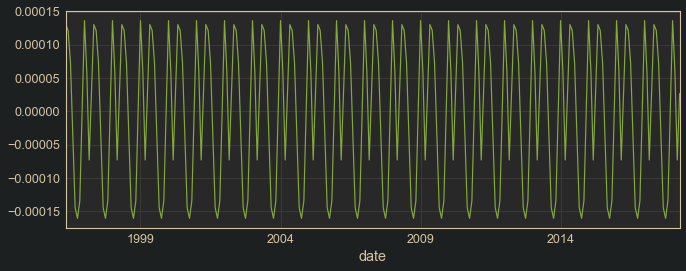

In [122]:
decomposition.seasonal.plot(figsize=(11,4))

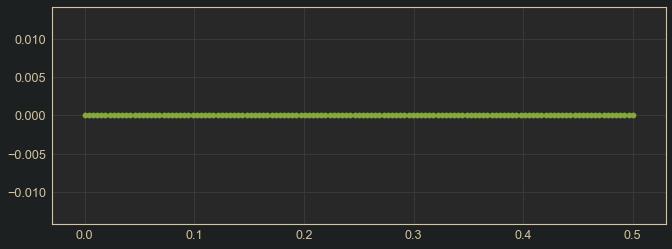

In [123]:
# We can see that there is a very slight but regular yearly seasonality to the data.
# let's see what a periodogram turns up
pgram = periodogram(decomposition.seasonal)
plt.figure(figsize=(11,4))
plt.scatter(pgram[0], pgram[1])

In [124]:
# Finding 3 largest specs:
indices = np.argpartition(pgram[1], -2)[-3:]
pd.DataFrame(list(zip((1 / pgram[0][indices])[::-1], pgram[1][indices][::-1])),
             columns=['Period', 'Spec']
            )

Period          Spec
0     6.0  1.287000e-06
1    12.0  1.273207e-06
2     4.0  2.444789e-07

In [127]:
# We can see the periods are close to, but not exactly yearly, this may explain the shifting
# phase over time that we observed earlier. Let's generate a fourier series
fs = fourier_series(pd.DataFrame(decomposition.seasonal), [12, 
                                             #6.022727
                                            ], K=2)
fs.head()

S1-12     C1-12     S2-12  C2-12
date                                           
1996-05-01  0.500000  0.866025  0.866025    0.5
1996-06-01  0.866025  0.500000  0.866025   -0.5
1996-07-01  1.000000  0.000000  0.000000   -1.0
1996-08-01  0.866025 -0.500000 -0.866025   -0.5
1996-09-01  0.500000 -0.866025 -0.866025    0.5

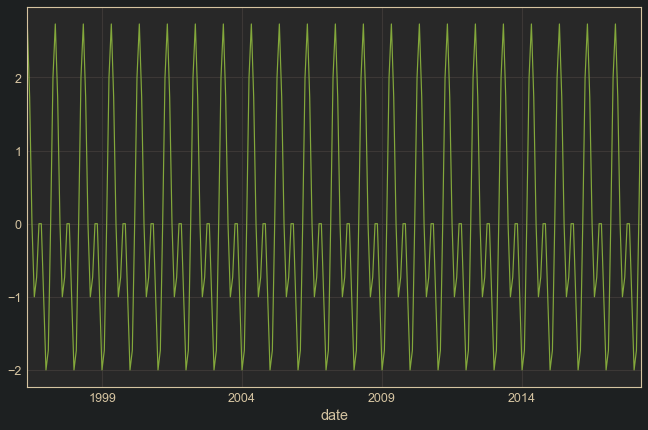

In [128]:
fs.sum(axis=1).plot()

In [129]:
# Fitting the ARIMA(0,2,1) model again with this fourier series as an exog variable
model = SARIMAX(log_returns,
                order=(0,1,1),
                #seasonal_order=(0,1,1,12),
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  264
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1614.034
Date:                Fri, 11 Sep 2020   AIC                          -3216.068
Time:                        13:28:21   BIC                          -3194.635
Sample:                    05-01-1996   HQIC                         -3207.455
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-12       2.546e-06      0.000      0.015      0.988      -0.000       0.000
C1-12          0.0001      0.000      0.725      0.469      -0.000       0.000
S2-12        3.13e-05   7.12e-05      0.440      0.6

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


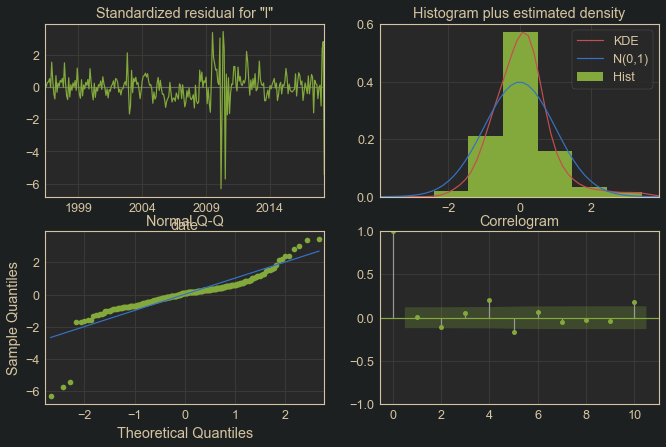

In [130]:
# We can see that the fourier terms did not aid the model in this case, and has insignificant
# coefficients. This all may come in handy for future datasets, however.
model.plot_diagnostics(figsize=(11,7));

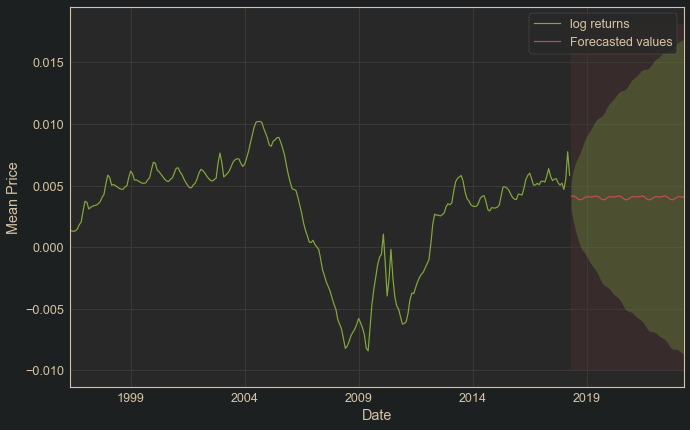

In [131]:
# Let's see now how the 5 year projection looks
prediction = model.get_forecast(60, exog=fourier_series(means_fix, freqs=[12.045455], K=2, h=60))

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()
# Plot future predictions with confidence intervals
ax = log_returns.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [132]:
# Now to add a yearly seasonal component to the model, since earlier we were able to see this
# in the data, and see how the model compares
# Note that the auto.arima model did not suggest seasonality, but we can force it to include
# a seasonal component by setting D=1
# we also want d=2 because this makes the data stationary for modeling

In [133]:
autoarima = r['auto.arima'](r['ts'](FloatVector(means_fix['mean log price']), freq=12), 
                            seasonal=True,
                            D=1,
                            d=2
                           )

In [134]:
print(autoarima)

Series: structure(c(11.5142636560835, 11.5156201149108, 11.5169485751824,  11.5182357576629, 11.5195757467557, 11.5210575971359, 11.5228841489884,  11.5249333014024, 11.5278829306489, 11.5316086082182, 11.535252316171,  11.5383534954782, 11.5415904538513, 11.5449263757948, 11.54830457405,  11.5517305429253, 11.5552601274276, 11.5589619578487, 11.5630126618771,  11.5673044536636, 11.5724822697232, 11.578333641924, 11.5839786994788,  11.5890169642435, 11.5941094198777, 11.5991079190941, 11.6040011697805,  11.6087765989047, 11.6134920813558, 11.6181866190224, 11.6230718089739,  11.6280522465346, 11.6336840083587, 11.6398526349363, 11.6458408132802,  11.6512929777247, 11.6567625445083, 11.6621346678752, 11.6674173362969,  11.6726227747144, 11.6778141452453, 11.6830376187281, 11.6885137086376,  11.6941535701393, 11.7004552784774, 11.7073544441803, 11.7141693716779,  11.7204271709258, 11.7265550433744, 11.7324668468003, 11.7381735593981,  11.7436797558414, 11.7490539850659, 11.7543890300087,

In [135]:
# Extracting the model parameters by making output into a string:
def get_params(autoarima_output):
    string = str(autoarima_output).split('ARIMA')[1].split(' ')[0]
    if len(string) < 8:
        param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
        sparam = (0,0,0,0)
    else:
        params = tuple(int(x) for x in string.replace('(','').replace(')',',')
                       .replace('[','').replace(']','').split(','))
        param = params[:3]
        sparam = params[3:]
    
    return param, sparam

param, sparam = get_params(autoarima)
print(param)
print(sparam)

(4, 2, 2)
(0, 1, 1, 12)


In [136]:
model = SARIMAX(means_fix,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False,
                initialization='approximate_diffuse'
               ).fit()
print(model.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                      SARIMAX Results                                       
Dep. Variable:                       mean log price   No. Observations:                  265
Model:             SARIMAX(4, 2, 2)x(0, 1, [1], 12)   Log Likelihood                1336.037
Date:                              Fri, 11 Sep 2020   AIC                          -2656.074
Time:                                      13:28:52   BIC                          -2627.436
Sample:                                  04-01-1996   HQIC                         -2644.568
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1      -1.095e-09   7.12e-09     -0.154      0.878    -1.5e-08    1.29e-08
ar.L2       1.247e-

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


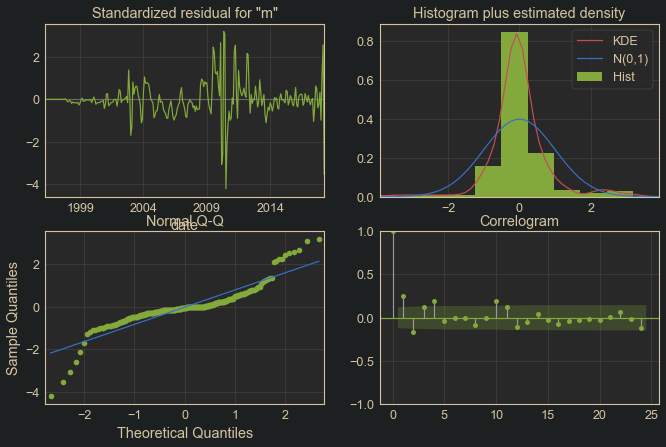

In [137]:
model.plot_diagnostics();

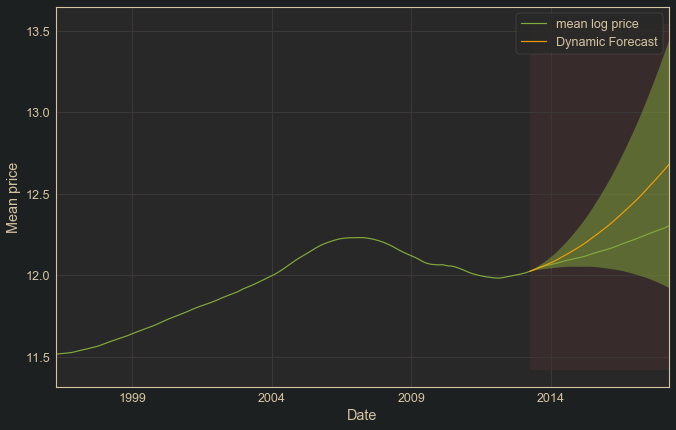

In [138]:
# We can see that the log likelihood and AIC values have improved, but now the Ljung-Box test
# is rejecting the null hypothesis of non-autocorrelated residuals. The residuals are heavily
# heteroscedastic as well, with a very noticeable change over time. Let's look at the predictive
# accuracy of this model

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = means_fix.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [139]:
# We can see that this model does not behave as well as the more simple model with no seasonality

In [140]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

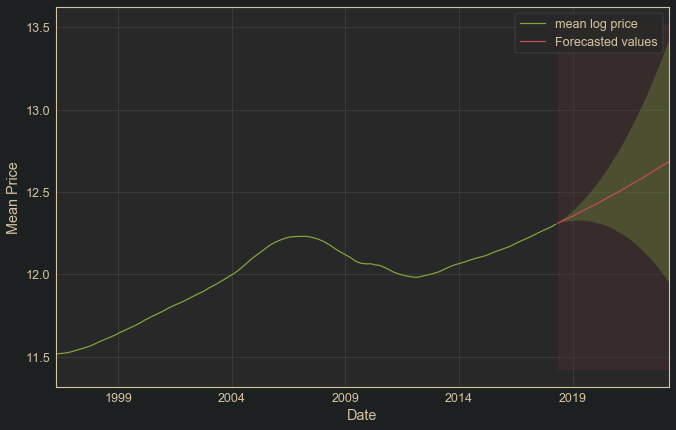

In [141]:
# Plot future predictions with confidence intervals
ax = means_fix.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [142]:
# We can see that the confidence intervals on the out of sample forecasting are huge, and not
# very helpful.

<a id='arima_returns'></a>
### ARIMA Modeling on Returns

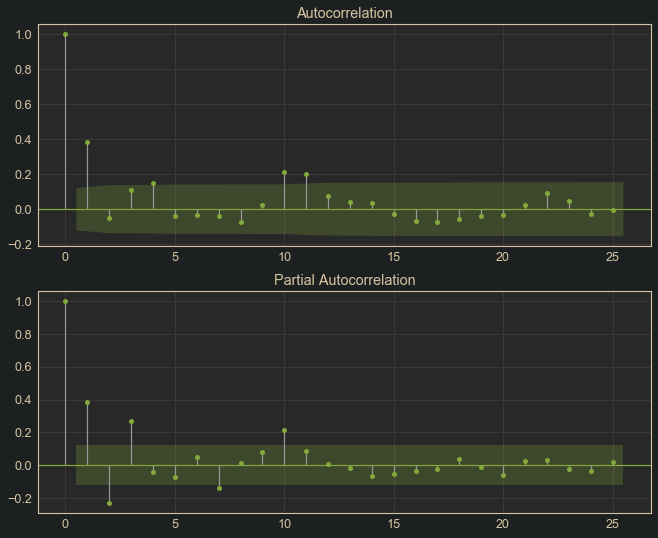

In [143]:
# First a look at the acf and pacf of the log returns and see if we can guess appropriate orders
fig, (ax1, ax2) = plt.subplots(2, figsize=(11,9))
plot_acf(log_returns.diff().dropna(), ax=ax1);
plot_pacf(log_returns.diff().dropna(), ax=ax2);

In [144]:
# We can see what looks like either a taper past lag 1 in the PACF, or a dropoff after lag 3.
# There is a drop off after lag 1 on the ACF, so a MA(1) order may be appropriate. There is a
# bump at 10 lags, which drops off more on the PACF, meaning that possibly an AR(10) order may
# be useful if the coefficients for the in between lags are set at zero. 

In [149]:
# Now let's see what the auto.arima function in R recommends for this series
log_returns = log_returns['log returns']
rlist = FloatVector(log_returns)
rmodel = r['auto.arima'](r['ts'](rlist, 
                                 #freq=12
                                ), 
                        seasonal='TRUE'
                       )

In [150]:
print(rmodel)

Series: structure(c(0.00135645882736313, 0.00132846027159061, 0.00128718248053517,  0.00133998909277011, 0.00148185038020543, 0.00182655185247249,  0.00204915241402759, 0.00294962924643194, 0.00372567756934394,  0.00364370795275626, 0.00310117930727927, 0.00323695837310112,  0.00333592194346188, 0.00337819825519325, 0.00342596887532487,  0.0035295845023029, 0.00370183042110561, 0.00405070402834262,  0.00429179178650863, 0.00517781605966938, 0.00585137220078735,  0.00564505755479416, 0.00503826476466784, 0.00509245563422311,  0.00499849921635409, 0.00489325068639879, 0.00477542912421924,  0.00471548245115905, 0.00469453766660166, 0.00488518995142329,  0.00498043756074829, 0.00563176182410352, 0.00616862657754602,  0.00598817834392484, 0.00545216444446872, 0.00546956678363308,  0.00537212336688953, 0.00528266842171021, 0.0052054384175424,  0.00519137053088414, 0.00522347348279162, 0.00547608990946102,  0.00563986150170059, 0.00630170833814603, 0.00689916570288496,  0.00681492749757062, 0

In [151]:
# Extracting the model parameters:
string = str(rmodel).split('ARIMA')[1].split(' ')[0]
param = tuple(int(x) for x in string.replace('(','').replace(')','').split(','))
print(param)

(3, 1, 1)


In [152]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(log_returns,
                order=param,
                enforce_stationary=False,
                enforce_invertibility=False,
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  264
Model:               SARIMAX(3, 1, 1)   Log Likelihood                1620.827
Date:                Fri, 11 Sep 2020   AIC                          -3231.655
Time:                        13:34:19   BIC                          -3213.794
Sample:                    05-01-1996   HQIC                         -3224.477
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2063      0.078      2.641      0.008       0.053       0.359
ar.L2         -0.2873      0.040     -7.246      0.000      -0.365      -0.210
ar.L3          0.2439      0.052      4.648      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


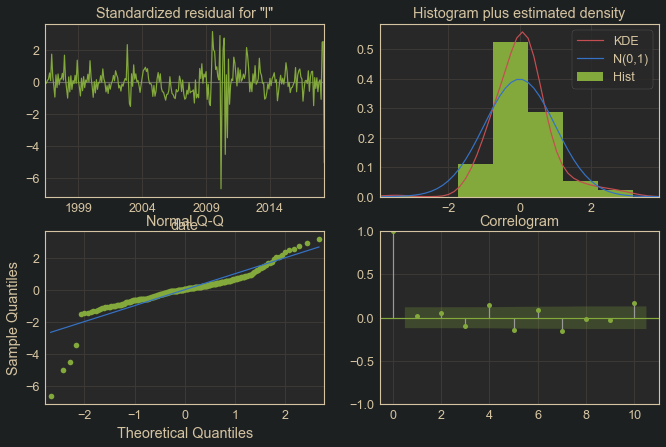

In [153]:
model.plot_diagnostics();

In [154]:
# We can see that the residuals are visibly heteroscedastic, and the null hypothesis of
# homoscedastic residuals is rejected. The Jarque-Bera test has the null hypothesis of normal
# skew and kurtosis rejected, caused by the leptokurtocity resulting from the large errors
# during the crash
# We do notice, however, that the AIC of this model is better than the models so far

In [155]:
from statsmodels.stats.diagnostic import het_arch

In [156]:
# Performing ARCH-LM test, note that recommended ddof = (p+q) from ARIMA model
results = het_arch(model.resid, 
                   #maxlag=80, 
                   ddof=4
                  )
res_names = ['LM test statistic', 'LM p-value', 'F-statistic', 'F-test p-value']
results = list(zip(res_names, results))
results

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:660: FutureWarning: The default value of nlags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setmaxlags or period to silence this warning.
  FutureWarning)


[('LM test statistic', 44.603674174414145),
 ('LM p-value', 0.0001595982102365387),
 ('F-statistic', 3.229575786949997),
 ('F-test p-value', 4.727212546347242e-05)]

In [157]:
# We can see that the null hypothesis of non-autocorrelated residuals is rejected.
# Let's see what the predictive behavior of this model is

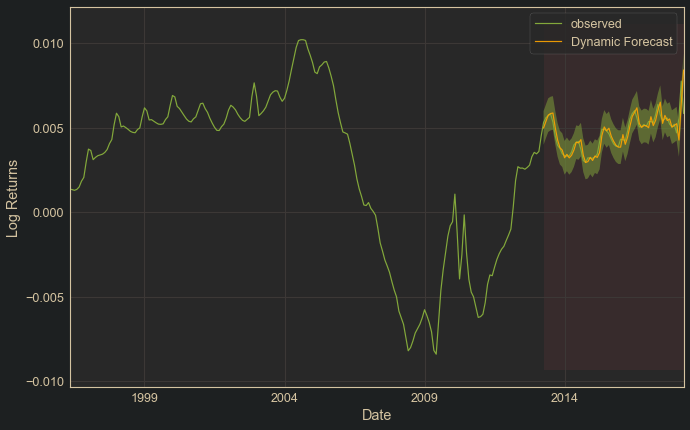

In [158]:
# Get one step ahead predictions with confidence intervals
pred = model.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

In [160]:
print('MSE for step ahead forecasts:')
((pred.predicted_mean - log_returns)**2).mean()

MSE for step ahead forecasts:


2.649241387452546e-07

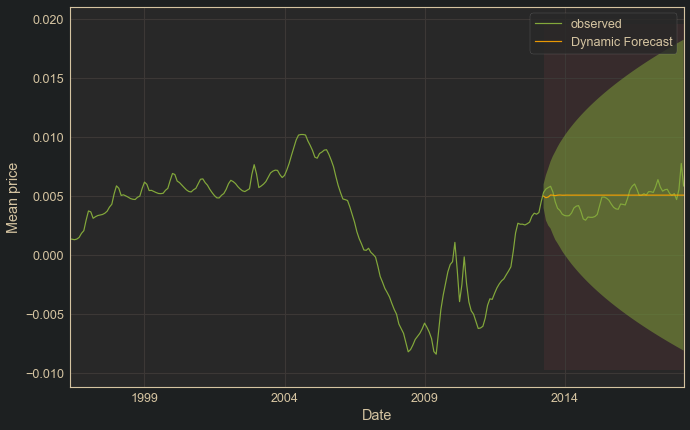

In [161]:
# We can see that the one step ahead forecasts were fairly accurate on the training data,
# let's look now at the dynamic forecast from the same date

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [162]:
# We can see the predicted means are fairly in line with the actual observations, but the
# confidence bands are rather wide.

In [163]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

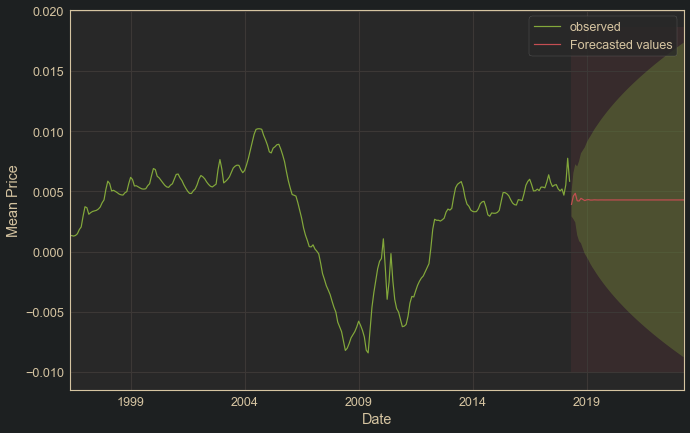

In [164]:
# Plot future predictions with confidence intervals
ax = log_returns.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [165]:
# We can see that the model has a conservative outlook on out of sample forecasts, indicating
# that the returns stream is expected to have a reduction in mean

# Since the assumptions of the model are violated, our parameter estimates may biased and
# not efficient. In order to get parameter estimates which are BLUE, we will need to perform
# heteroscedasticity filtering

In [168]:
def check_pgram(series):
    pgram = periodogram(series)
    plt.figure(figsize=(11,4))
    plt.plot(pgram[0], pgram[1], marker='o')
    indices = (-pgram[1]).argsort()[:10]
    results = pd.DataFrame(list(zip((1 / pgram[0][indices]), pgram[1][indices])),
                                 columns=['Period', 'Spec']
                                )
    return results

In [170]:
diff_returns = log_returns.diff().dropna()

Period      Spec
0  13.150000  0.000005
1  10.115385  0.000004
2  10.958333  0.000004
3  87.666667  0.000003
4  11.434783  0.000003

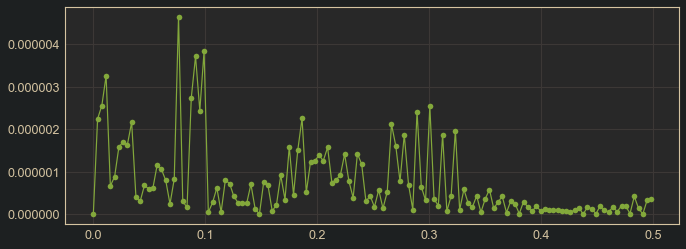

In [171]:
# First, I'd like to see if a fourier component could help this model. I will generate the
# fourier series using the differenced data, then use the cumulative sum of the values in the
# model above (must use cumulative sum because exog variables are considered after data is
# unintegrated)
pgram = check_pgram(diff_returns)
pgram.head()

In [ ]:
fs = fourier_series(diff_returns, freqs=pgram.Period[:3], K=1)

In [173]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(log_returns.loc[fs.index],
                order=param,
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs.iloc[:].cumsum()
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  263
Model:               SARIMAX(3, 1, 1)   Log Likelihood                1627.285
Date:                Fri, 11 Sep 2020   AIC                          -3232.571
Time:                        13:44:22   BIC                          -3193.319
Sample:                    06-01-1996   HQIC                         -3216.795
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-13.15       0.0002   8.29e-05      2.200      0.028    1.99e-05       0.000
C1-13.15   -4.358e-05   6.48e-05     -0.672      0.501      -0.000    8.34e-05
S1-10.12      -0.0002   7.67e-05     -2.127      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [ ]:
# It looks as though all of the cosine components do not produce significant coefficients,
# let's see what happens if we reduce the additions to only the sine components of the fourier
# series

In [174]:
fs_cols = [0,2,4]

In [175]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(log_returns.loc[fs.index],
                order=param,
                #seasonal_order=(0,2,3,4),
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs.iloc[:, fs_cols].cumsum()
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  263
Model:               SARIMAX(3, 1, 1)   Log Likelihood                1625.753
Date:                Fri, 11 Sep 2020   AIC                          -3235.506
Time:                        13:44:53   BIC                          -3206.959
Sample:                    06-01-1996   HQIC                         -3224.032
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-13.15       0.0002   7.53e-05      2.429      0.015    3.53e-05       0.000
S1-10.12      -0.0002   6.93e-05     -2.346      0.019      -0.000   -2.67e-05
S1-10.96      -0.0002   6.98e-05     -2.282      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [176]:
# We can see that the coefficients for the newly added fourier series are significant

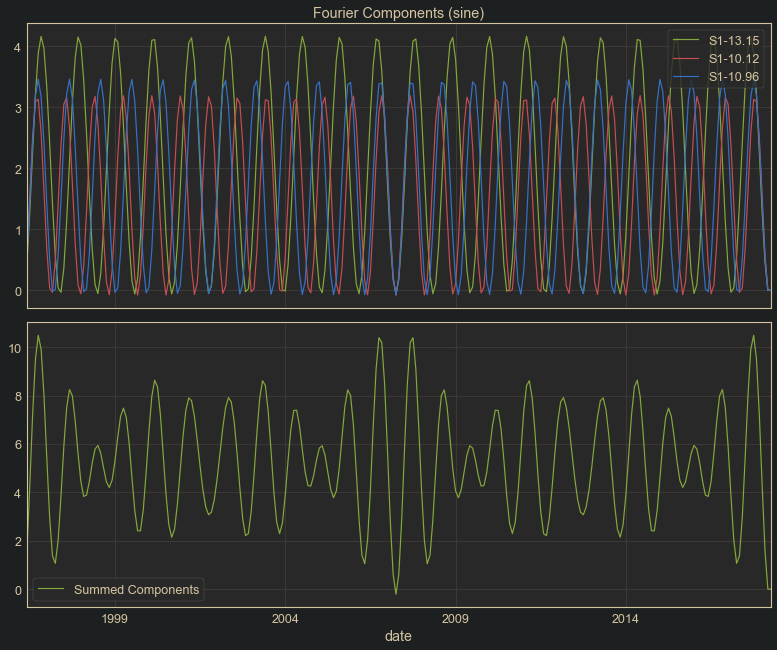

In [180]:
# Let's take a look at our exogenous variable
fig, (ax1, ax2) = plt.subplots(2, figsize=(11,9), sharex=True)
fs.iloc[:, fs_cols].cumsum().plot(ax=ax1)
fs.iloc[:, fs_cols].cumsum().sum(axis=1).plot(ax=ax2)
plt.tight_layout()
ax1.set_title('Fourier Components (sine)')
ax2.legend(['Summed Components'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


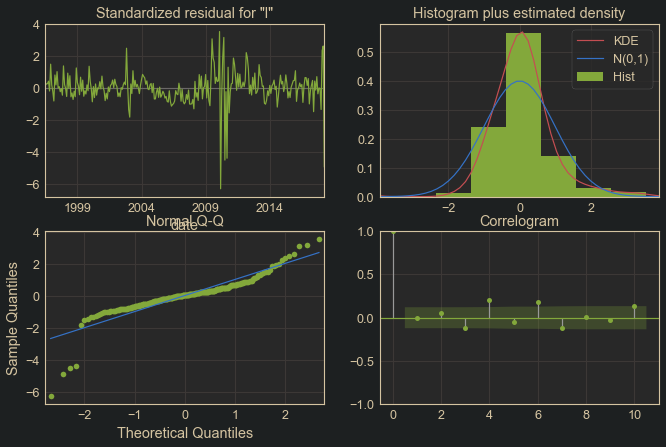

In [181]:
model.plot_diagnostics();

In [182]:
# We can see that the residuals are visibly heteroscedastic, and the null hypothesis of
# homoscedastic residuals is rejected. The Jarque-Bera test has the null hypothesis of normal
# skew and kurtosis rejected, caused by the leptokurtocity resulting from the large errors
# during the crash.
# The autocorrelation of our residuals has changed some, but still are significantly
# autocorrelated

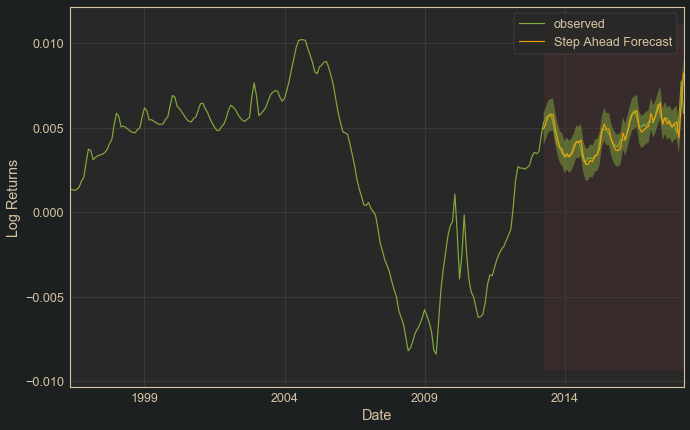

In [183]:
# Get one step ahead predictions with confidence intervals
pred = model.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Step Ahead Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

In [184]:
print('MSE for step ahead forecasts:')
((pred.predicted_mean - log_returns)**2).mean()

MSE for step ahead forecasts:


2.44696264292393e-07

In [185]:
# We can see that the MSE for the new model has improved slightly

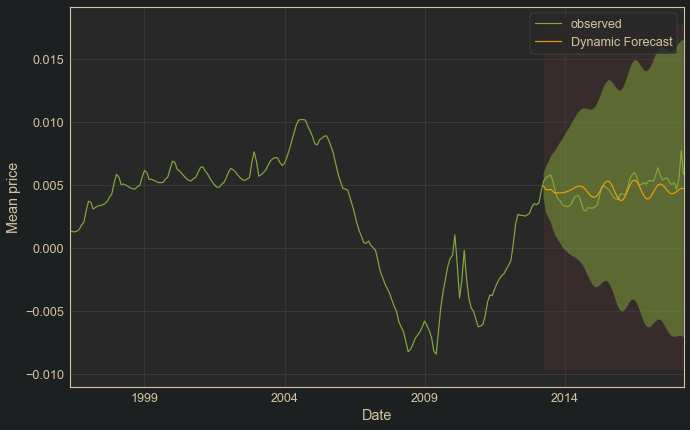

In [186]:
# We can see that the one step ahead forecasts were fairly accurate on the training data,
# let's look now at the dynamic forecast from the same date

# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [187]:
fs_fore = fourier_series(diff_returns, freqs=pgram.Period[:3], K=1, h=60)
fs_fore = pd.concat([fs, fs_fore], axis=0)

In [189]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60, exog=fs_fore.cumsum().iloc[-60:, fs_cols])

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

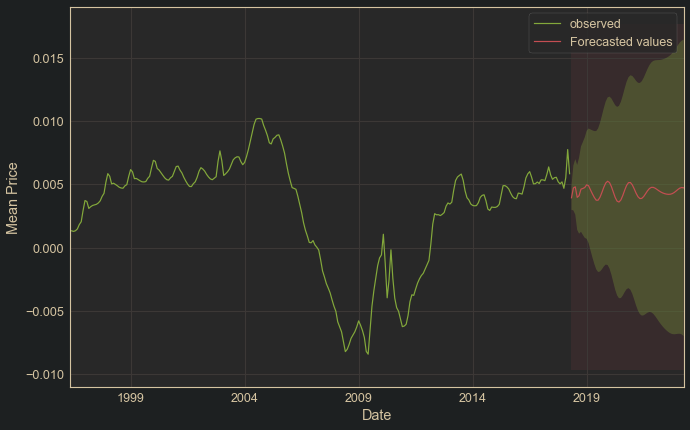

In [190]:
# Plot future predictions with confidence intervals
ax = log_returns.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('Mean Price')
plt.legend()
plt.show()

In [191]:
# We can see that the mean of returns is still expected to decrease, but now the fourier
# component is visible.

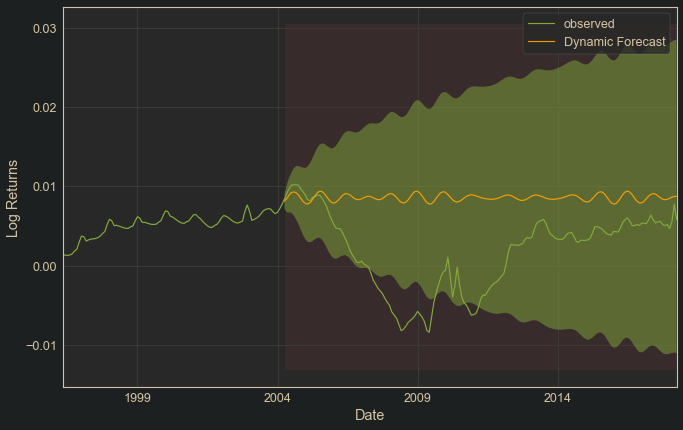

In [192]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(dynamic='2004-04-01')
pred_dynamic_conf = pred_dynamic.conf_int().loc['2004-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.loc['2004-04-01':].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2004-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

In [193]:
# Since the assumptions of the model are violated, our parameter estimates may biased and
# not efficient. In order to get parameter estimates which are BLUE, we will need to perform
# heteroscedasticity filtering

In [195]:
# Let's see what the MSE would be just using previous values as step ahead forecasts as in a 
# random walk model and compare
((log_returns - log_returns.shift(1))**2).mean()

3.726542334908291e-07

In [196]:
# We can see that our models are explaining the data better than a random walk model

### Filtering Heteroscedasticity:
When it comes to filtering heteroscedasticity, Stockhammar & Oller (2007) discuss some effective options in their paper. As the authors state, "the most straightforward way to remove heteroscedasticity in [a time series] is to divide the heteroscedastic series by the conditional volatility estimated from ARCH/GARCH models or from any of their many generalizations." They go on to compare this to their own suggested method of filtering using rolling window estimates of standard deviation over the series.<br>
<br>
The objective is to apply mean and heteroscedasticity filtering to get an appropriately stationary series, fit an ARIMA/SARIMA/ARFIMA model to the resulting filtered series, then apply the parameter estimates to the unfiltered data and make predictions.<br>
<br>
Below, I have constructed a function which can perform heteroscedasticity filtering by the methods they use in their study. For more detailed analysis of these methods, see the other notebook where I reconstructed the workflow from the paper.

In [197]:
# First I would like to generate conditional volatility using a GARCH model on the residuals
# from our last model, then filter the data using this, before moving on to the methods used
# by Stockhammar & Oller

In [211]:
# Fitting the simple model using the optimal parameters found by the auto.arima() function:
model = SARIMAX(log_returns,
                order=(3,1,1),
                enforce_stationary=False,
                enforce_invertibility=False,
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  264
Model:               SARIMAX(3, 1, 1)   Log Likelihood                1620.827
Date:                Fri, 11 Sep 2020   AIC                          -3231.655
Time:                        14:18:01   BIC                          -3213.794
Sample:                    05-01-1996   HQIC                         -3224.477
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2063      0.078      2.641      0.008       0.053       0.359
ar.L2         -0.2873      0.040     -7.246      0.000      -0.365      -0.210
ar.L3          0.2439      0.052      4.648      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [212]:
from arch import arch_model

In [213]:
# define model
arch = arch_model(model.resid, 
                  mean='Zero', 
                  vol='GARCH', 
                  #dist='t'
                  rescale=True
                 ).fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 146.49290278009585
Iteration:      2,   Func. Count:     12,   Neg. LLF: 145.99044090066124
Iteration:      3,   Func. Count:     18,   Neg. LLF: 145.3870284268093
Iteration:      4,   Func. Count:     24,   Neg. LLF: 145.02176895934454
Iteration:      5,   Func. Count:     30,   Neg. LLF: 144.90614189731912
Iteration:      6,   Func. Count:     35,   Neg. LLF: 144.87369106703093
Iteration:      7,   Func. Count:     40,   Neg. LLF: 144.86298972624698
Iteration:      8,   Func. Count:     45,   Neg. LLF: 144.8618168027637
Iteration:      9,   Func. Count:     50,   Neg. LLF: 144.86169326009764
Iteration:     10,   Func. Count:     55,   Neg. LLF: 144.86167114389957
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 144.8616711438996
            Iterations: 10
            Function evaluations: 55
            Gradient evaluations: 10


In [214]:
print(arch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -144.862
Distribution:                  Normal   AIC:                           295.723
Method:            Maximum Likelihood   BIC:                           306.451
                                        No. Observations:                  264
Date:                Fri, Sep 11 2020   Df Residuals:                      261
Time:                        14:18:07   Df Model:                            3
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0403  3.382e-02      1.192      0.233 [-2.59

In [215]:
arch.scale

1000.0

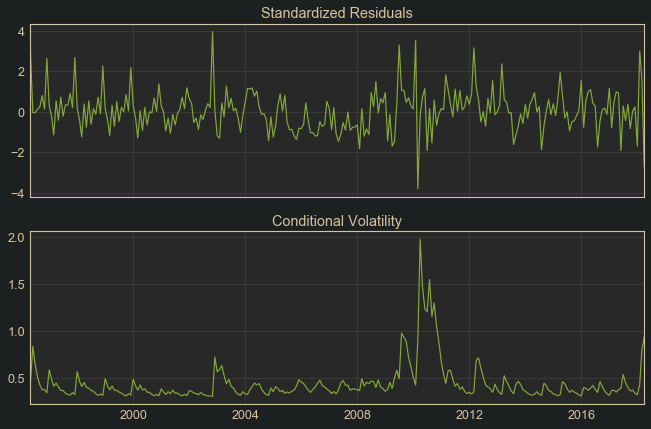

In [216]:
arch.plot();

In [217]:
len(arch.conditional_volatility)

264

In [218]:
log_returns.std()

0.0044080356084499695

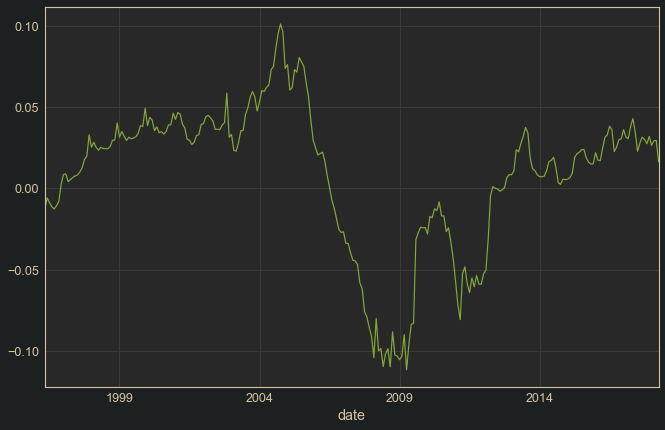

In [219]:
# Now let's take the advice of Stockhammar & Oller's advice and divide the serie by the cond.
# volatility generated by this model
series_mean = log_returns.mean()
series_std = log_returns.std()
test = series_std * (log_returns-series_mean) / (arch.conditional_volatility / arch.scale) + series_mean
test.plot()

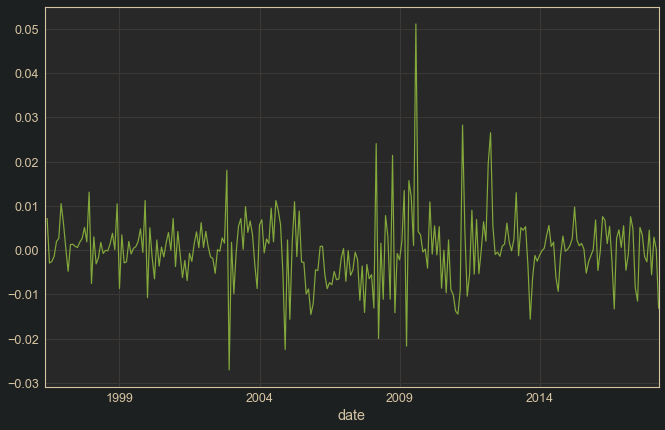

In [220]:
test.diff().plot()

In [225]:
model = SARIMAX(test,
                order=(3,1,1),
                #seasonal_order=(0,0,1,12),
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(3, 1, 1)   Log Likelihood                 900.882
Date:                Fri, 11 Sep 2020   AIC                          -1791.764
Time:                        14:19:22   BIC                          -1773.903
Sample:                    05-01-1996   HQIC                         -1784.586
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0050      1.200      0.004      0.997      -2.348       2.358
ar.L2          0.1863      0.055      3.379      0.001       0.078       0.294
ar.L3          0.0524      0.227      0.230      0.8

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


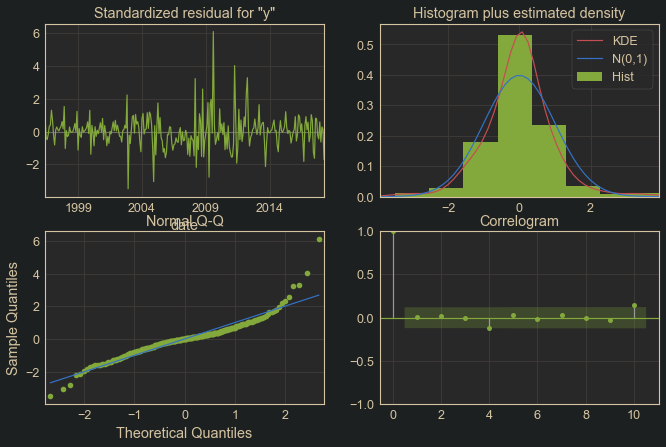

In [226]:
# all of our coefficients are significant with alpha = 0.05
# The null hypothesis of non-autocorrelated residuals is not rejected by Ljung-Box
# The null hypothesis of non-heteroscedastic residuals is not rejected
# The null hypothesis of normal skew & kurtosis is rejected by JB, the problem being thin tails
# caused by outliers in the errors
model.plot_diagnostics();

In [233]:
coefs = model.params
model = SARIMAX(log_returns,
                order=(3,1,1),
                #seasonal_order=(0,0,1,12),
                enforce_stationary=False,
                enforce_invertibility=False
               ).smooth(coefs)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  264
Model:               SARIMAX(3, 1, 1)   Log Likelihood                1031.578
Date:                Fri, 11 Sep 2020   AIC                          -2053.156
Time:                        14:21:48   BIC                          -2035.295
Sample:                    05-01-1996   HQIC                         -2045.978
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0050    109.343    4.6e-05      1.000    -214.303     214.313
ar.L2          0.1863      3.644      0.051      0.959      -6.955       7.328
ar.L3          0.0524     23.500      0.002      0.9

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


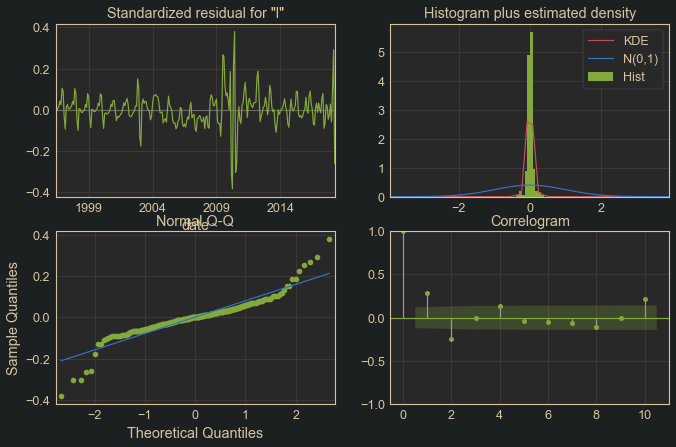

In [234]:
model.plot_diagnostics();

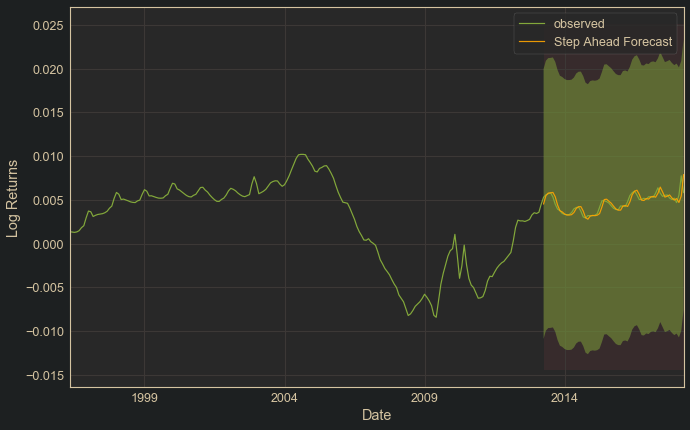

In [235]:
# Get one step ahead predictions with confidence intervals
pred = model.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Step Ahead Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

In [236]:
print('MSE for step ahead forecasts:')
((pred.predicted_mean - log_returns)**2).mean()

MSE for step ahead forecasts:


3.9652856230305673e-07

In [244]:
# We can see that this has not helped the performance of the model, and now it is less accurate
# than the random walk model. We can see that the confidence intervals on the parameters were
# so wide after smoothing on the new data that the predictions are not very useful

Using the filtering method of dividing a series by the conditional volatility estimate from a GARCH model on the residuals of our initial model on the series has given us a better looking model. In Stockhammar & Oller's study, they were actually fitting the GARCH model to the differenced series, let's try that now.

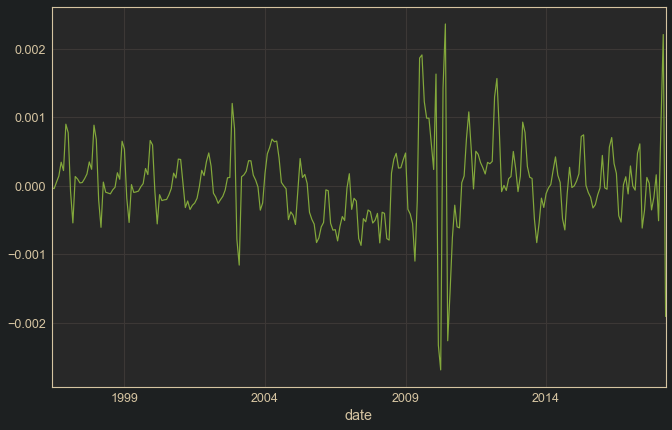

In [245]:
# First assign the differenced log returns to a variable for convenience
diff_returns = log_returns.diff().dropna()
diff_returns.plot();

In [246]:
# We can see that the differenced return series is mostly stationary, with some local trends 
# and heteroscedasticity visible

In [247]:
# define model
arch = arch_model(diff_returns, 
                  mean='Zero', 
                  vol='GARCH', 
                  #dist='t'
                  rescale=True
                 ).fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 190.39784874368902
Iteration:      2,   Func. Count:     12,   Neg. LLF: 188.86369115690553
Iteration:      3,   Func. Count:     18,   Neg. LLF: 181.8130054411506
Iteration:      4,   Func. Count:     24,   Neg. LLF: 177.24319745021475
Iteration:      5,   Func. Count:     31,   Neg. LLF: 177.219658802067
Iteration:      6,   Func. Count:     36,   Neg. LLF: 177.17709360232857
Iteration:      7,   Func. Count:     41,   Neg. LLF: 177.103215989903
Iteration:      8,   Func. Count:     46,   Neg. LLF: 177.07326833841068
Iteration:      9,   Func. Count:     51,   Neg. LLF: 177.04398493940164
Iteration:     10,   Func. Count:     56,   Neg. LLF: 177.0420255804043
Iteration:     11,   Func. Count:     61,   Neg. LLF: 177.0419027400082
Iteration:     12,   Func. Count:     66,   Neg. LLF: 177.04190065460023
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 177.04190065456567
            Iteration

In [248]:
print(arch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:            log returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -177.042
Distribution:                  Normal   AIC:                           360.084
Method:            Maximum Likelihood   BIC:                           370.800
                                        No. Observations:                  263
Date:                Fri, Sep 11 2020   Df Residuals:                      260
Time:                        14:25:20   Df Model:                            3
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0727  2.224e-02      3.268  1.084e-03  [2.90

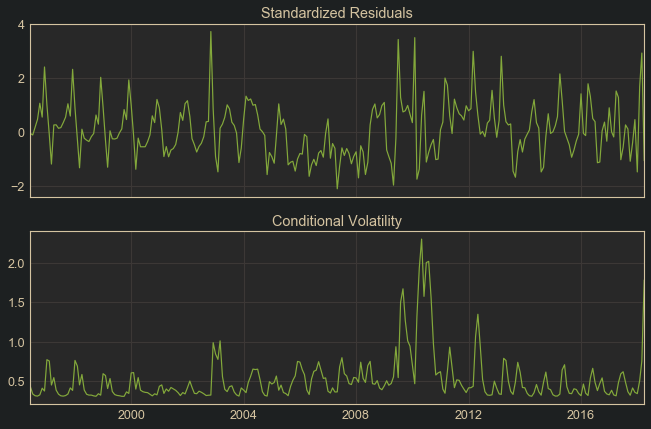

In [249]:
arch.plot();

In [250]:
arch.scale

1000.0

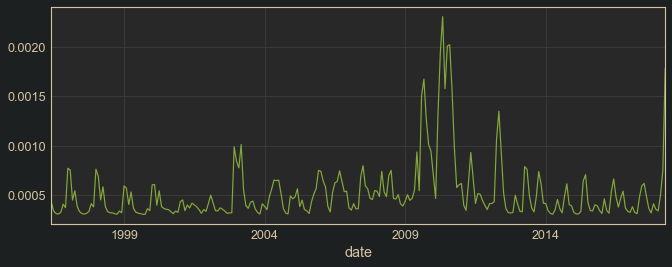

In [263]:
cond_sd = (arch.conditional_volatility / arch.scale)
cond_sd.plot(figsize=(11,4))

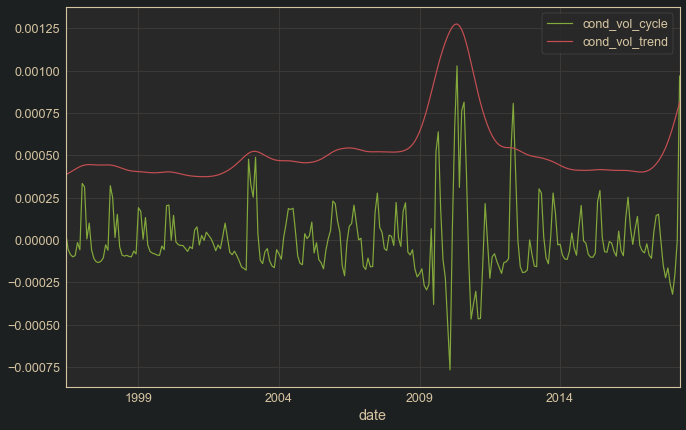

In [264]:
filter_test = pd.DataFrame(hpfilter(arch.conditional_volatility/arch.scale, lamb=700)).T
filter_test.plot()

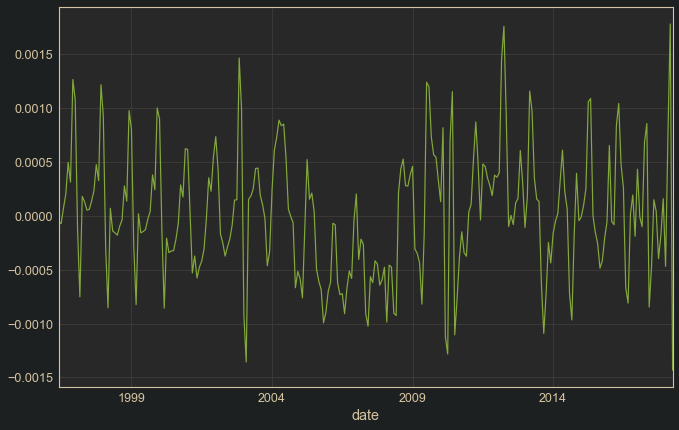

In [303]:
# Now to filter the series using the trend component of the conditional volatility
stdev = diff_returns.std()
mean = diff_returns.mean()
zt = diff_returns - mean
filtered = stdev * (zt / (filter_test.cond_vol_trend)) + mean
filtered.plot()

In [304]:
# We can see that filtering the data using the conditional volatility from the GARCH model
# has mostly removed the visible heteroscedasticity, but has left the local trends in tact

In [305]:
# Now to fit a model to this filtered series
rlist = FloatVector(filtered)
autoarima = r['auto.arima'](r['ts'](rlist, freq=12))
param, sparam = get_params(autoarima)
print(param, sparam)

(4, 0, 2) (1, 0, 2, 12)


In [306]:
# Using the recommended parameters
model = SARIMAX(filtered,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  263
Model:             SARIMAX(4, 0, 2)x(1, 0, 2, 12)   Log Likelihood                1665.689
Date:                            Fri, 11 Sep 2020   AIC                          -3311.378
Time:                                    14:35:36   BIC                          -3275.656
Sample:                                06-01-1996   HQIC                         -3297.022
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1747      0.041      4.282      0.000       0.095       0.255
ar.L2         -0.6166      0.078   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


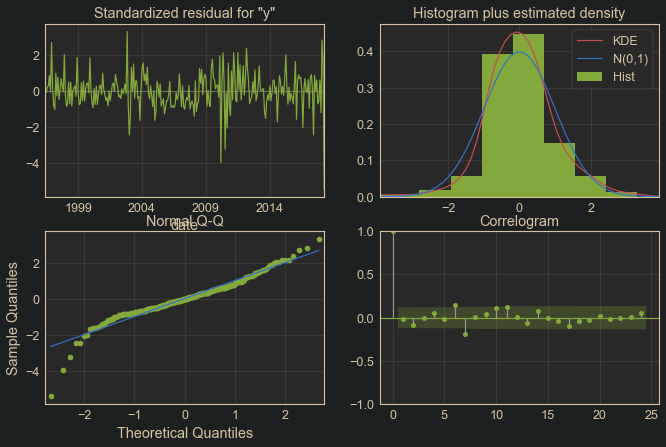

In [309]:
model.plot_diagnostics();

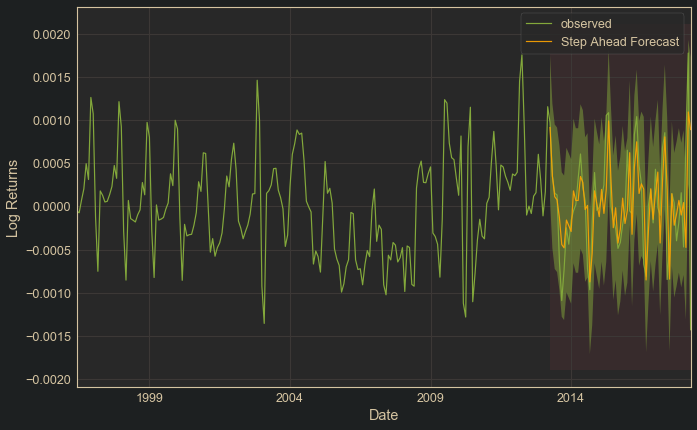

In [310]:
# Get one step ahead predictions with confidence intervals
pred = model.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Step Ahead Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

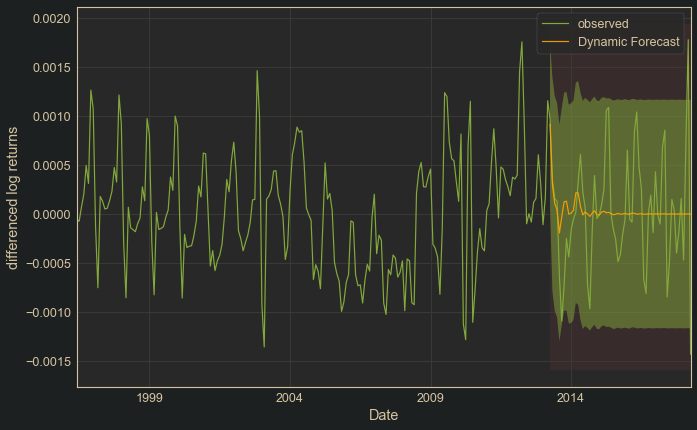

In [311]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('differenced log returns')
plt.legend()
plt.show()

In [312]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

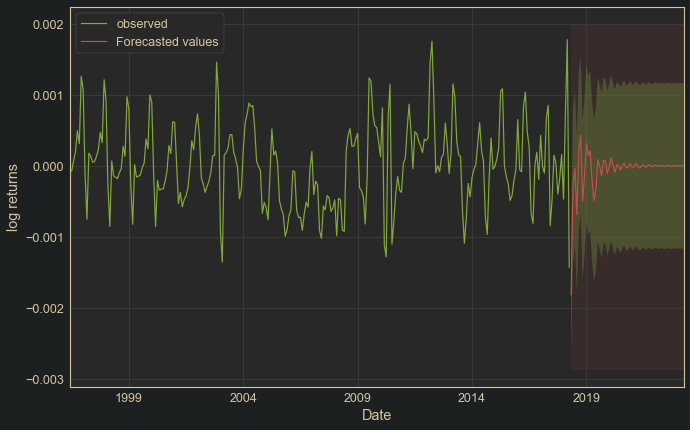

In [313]:
# Plot future predictions with confidence intervals
ax = filtered.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

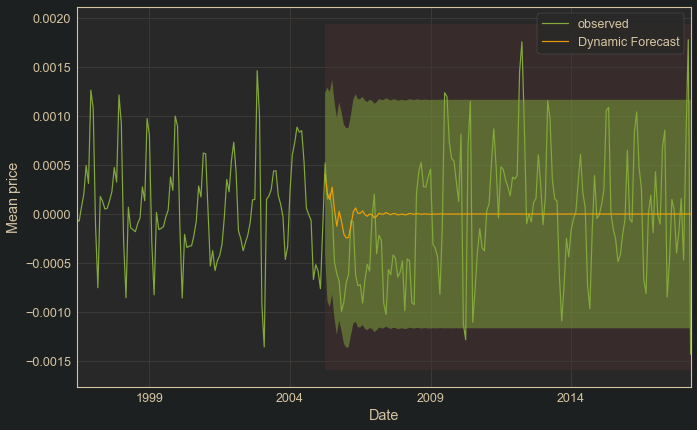

In [314]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2005-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2005-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

Now that we have generated coefficients on the filtered data, we will smooth another model with these coefficients, then see how good the predictive power of the coefficients are.

In [315]:
mod = SARIMAX(log_returns,
                order=(4,1,2),
                seasonal_order=(1,0,2,12),
                enforce_stationary=False,
                enforce_invertibility=False
               )
coefs = model.params
res = mod.smooth(coefs)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        log returns   No. Observations:                  264
Model:             SARIMAX(4, 1, 2)x(1, 0, 2, 12)   Log Likelihood                1597.530
Date:                            Fri, 11 Sep 2020   AIC                          -3175.060
Time:                                    14:36:08   BIC                          -3139.339
Sample:                                05-01-1996   HQIC                         -3160.705
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1747      0.024      7.139      0.000       0.127       0.223
ar.L2         -0.6166      0.038   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


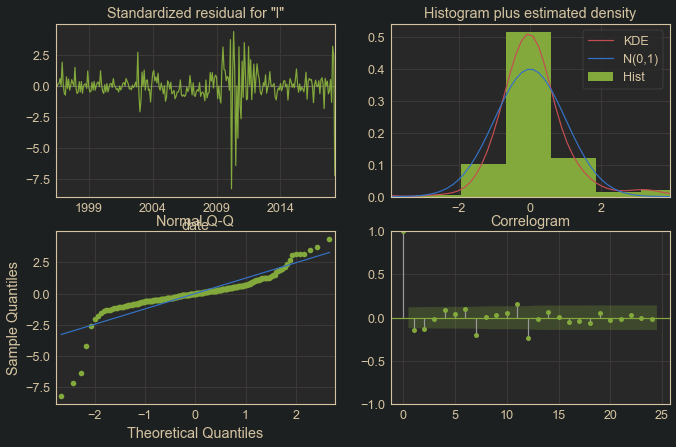

In [316]:
res.plot_diagnostics();

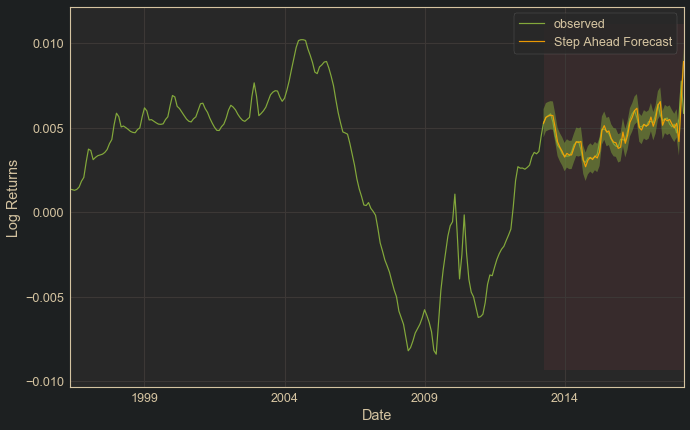

In [324]:
# Get one step ahead predictions with confidence intervals
pred = res.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Step Ahead Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

In [325]:
print('MSE for step ahead forecasts:')
((pred.predicted_mean - log_returns)**2).mean()

MSE for step ahead forecasts:


2.8424499495086126e-07

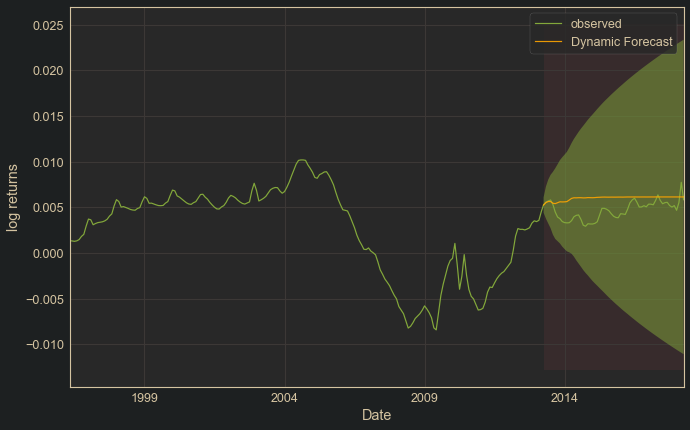

In [326]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2013-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [327]:
# Let's look at a 5 year forecast with this model
prediction = res.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

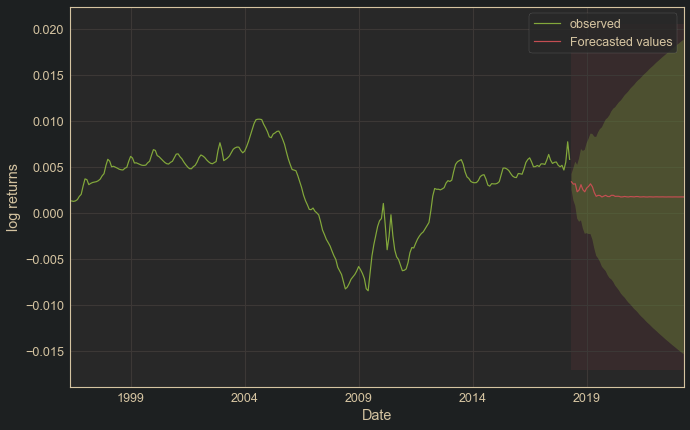

In [328]:
# Plot future predictions with confidence intervals
ax = log_returns.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [329]:
# This model is anticipating an upcoming reduction in the mean of log returns

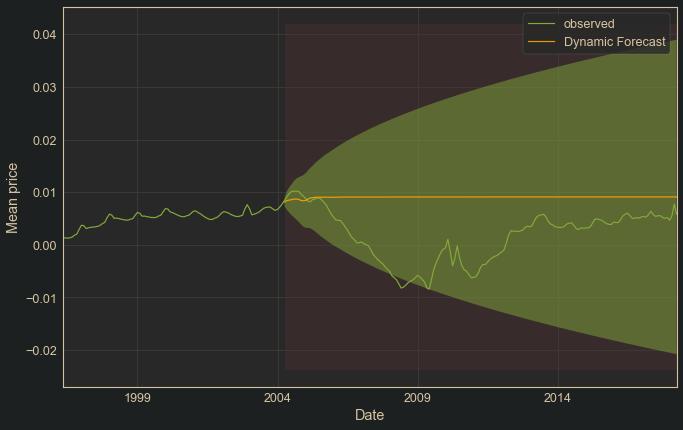

In [330]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2004-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2004-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [331]:
# This model managed to capture most of the upcoming crash in its confidence bands, but the
# step ahead forecasts were not as accurate as the model from the unfiltered data.

Since before we filtered the differenced series using the trend component of an HP filter of the GARCH model conditional volatility, let's see what happens if we do not use the HP filter.

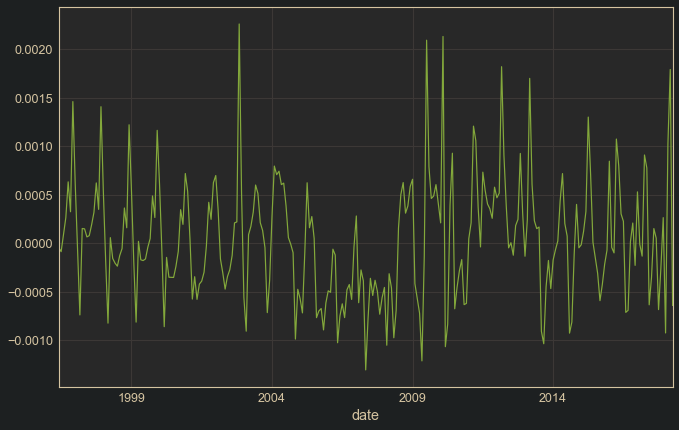

In [332]:
stdev = diff_returns.std()
mean = diff_returns.mean()
zt2 = diff_returns - mean
filtered2 = stdev * (zt2 / (arch.conditional_volatility/arch.scale)) + mean
filtered2.plot()

In [333]:
# Now to fit a model, then to get the conditional volatility in this unit
rlist = FloatVector(filtered2)
autoarima = r['auto.arima'](r['ts'](rlist, freq=12))
param, sparam = get_params(autoarima)
print(param, sparam)

(0, 0, 1) (1, 0, 2, 12)


In [334]:
model = SARIMAX(filtered2,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  263
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 12)   Log Likelihood                1612.421
Date:                                 Fri, 11 Sep 2020   AIC                          -3214.843
Time:                                         14:38:02   BIC                          -3196.982
Sample:                                     06-01-1996   HQIC                         -3207.665
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5379      0.042     12.757      0.000       0.455       0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [335]:
# All of the coefficients are significant other than the 2 lag seasonal MA term
# The null hypothesis of homoscedasticity is not rejected, which is good
# The null hypothesis of non autocorrelated residuals is rejected, but the pvalue has increased
# There is still leptokurtocity, due to extreme errors in the volatile periods still present

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


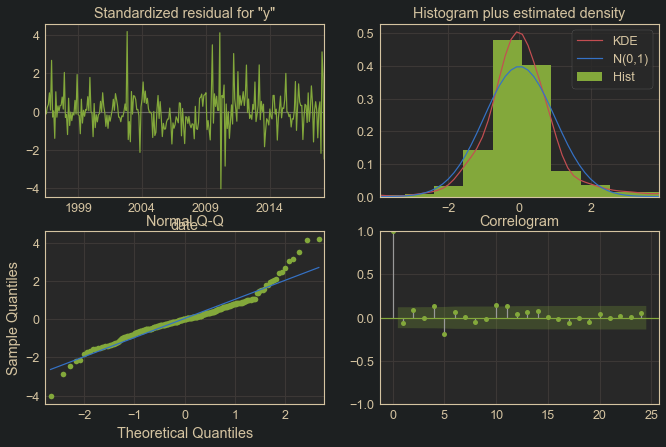

In [336]:
model.plot_diagnostics();

In [341]:
mod = SARIMAX(log_returns,
                order=(0,1,1),
                seasonal_order=(1,0,2,12),
                enforce_stationary=False,
                enforce_invertibility=False
               )
coefs = model.params
res = mod.smooth(coefs)
print(res.summary())

                                        SARIMAX Results                                        
Dep. Variable:                             log returns   No. Observations:                  264
Model:             SARIMAX(0, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood                1606.910
Date:                                 Fri, 11 Sep 2020   AIC                          -3203.820
Time:                                         14:39:48   BIC                          -3185.960
Sample:                                     05-01-1996   HQIC                         -3196.643
                                          - 04-01-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5379      0.035     15.308      0.000       0.469       0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


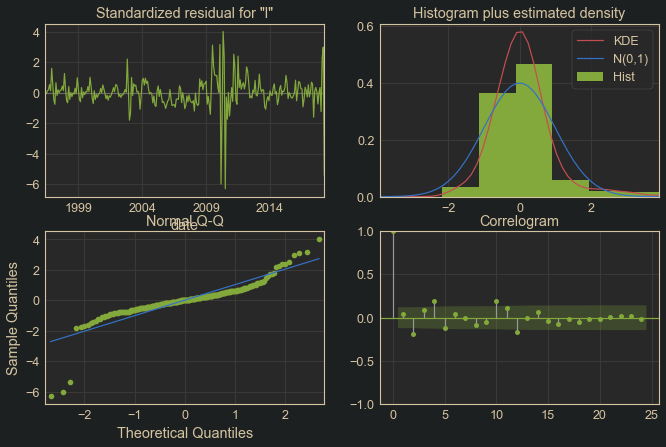

In [342]:
res.plot_diagnostics();

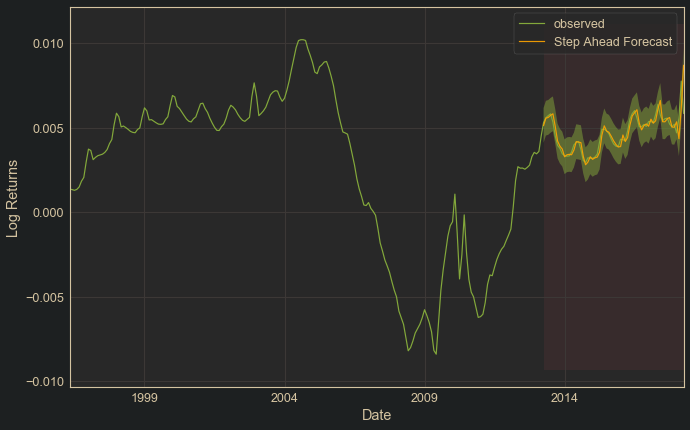

In [343]:
# Get one step ahead predictions with confidence intervals
pred = res.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Step Ahead Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

In [344]:
print('MSE for step ahead forecasts:')
((pred.predicted_mean - log_returns)**2).mean()

MSE for step ahead forecasts:


2.9364819634860896e-07

In [345]:
# l will be the length of our window, must be an odd number
l = 3
n = series.index
v = int((l-1)/2)
for t in range(v, len(n)-v):
    if v > 0:
        term = np.sum([series.iloc[i]**2 for i in range(t-v, t+v+1)])
    else:
        term = series.iloc[i] ** 2

    stds.loc[n[t]] = np.sqrt(term / 2*v)

NameError: name 'series' is not defined

Now that we have seen some heteroscedasticity filtering in action, it is time to make a function which can perform the full filtering process outlined in Stockhammar & Oller's study, either using GARCH or the rolling windows that they recommmend.

In [346]:
def so_filter(series, sd_method='rolling', l=None, k=0, lamb=700, center=True, visualize=False,
                hp_filter=True, return_df=False, d=1):
    '''Takes in a pandas series and filters it to become stationary according to the process
    outlined by Stockhammar & Oller (2007). Series passed should be the already differenced
    series (close to stationary but with local trends and heteroscedasticity).
    '''
    
    series_mean = series.mean()
    
    if k > 0:
        rolling_means = series.rolling(window=k, center=center).mean()
        mean_filt = series - rolling_means
        rolling_means.name = 'ma'
    else:
        mean_filt = series - series_mean
    
    # Get local stds using Stockhammer & Oller (2007) method
    if sd_method == 'rolling':
        stds = series.rolling(window=l, center=center).std(ddof=1).dropna()
    
    # Get local stds using GARCH
    if sd_method == 'GARCH':
        arch = arch_model(series, 
                      mean='Zero', 
                      vol='GARCH', 
                      #dist='t'
                      rescale=True
                     ).fit()
        stds = arch.conditional_volatility / arch.scale
        print(arch.summary())
    
    # Perform filtering

    if hp_filter:
        stds = pd.DataFrame(hpfilter(stds, lamb=lamb)).T.iloc[:, 1]
        
    stds.name = 'sd'
    
    filtered = series.std() * ((mean_filt) / stds) + series_mean
    filtered = filtered.dropna()
    filtered.name = 'filtered_series'
    
    if visualize:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(11,10), sharex=True)
        series.plot(label=series.name, ax=ax1)
        stds.plot(label='local SD', ax=ax1)
        ax1.set_title('Series with local SD')
        ax1.legend()
        filtered.plot(label=series.name, ax=ax2)
        ax2.set_title('Filtered Series')
        ax2.legend()
        plt.tight_layout()
        plt.show()
        
    results = pd.merge(filtered, stds, left_index=True, right_index=True)
    if k > 0:
        results = pd.merge(results, rolling_means, left_index=True, right_index=True)
    
    if return_df:
        return results
    else:
        return filtered

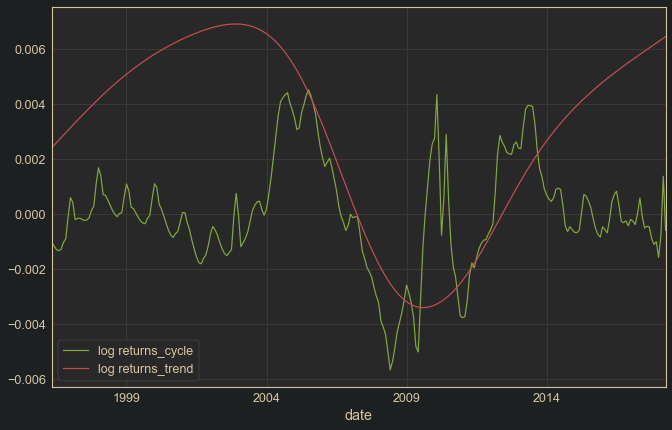

In [347]:
filter_test = pd.DataFrame(hpfilter(log_returns, lamb=129600)).T
filter_test.plot()

Let's experiment using our new function to see if we can get some truly efficient and unbiased estimations of our model coefficients.

In [348]:
diff_returns = log_returns.diff().dropna()

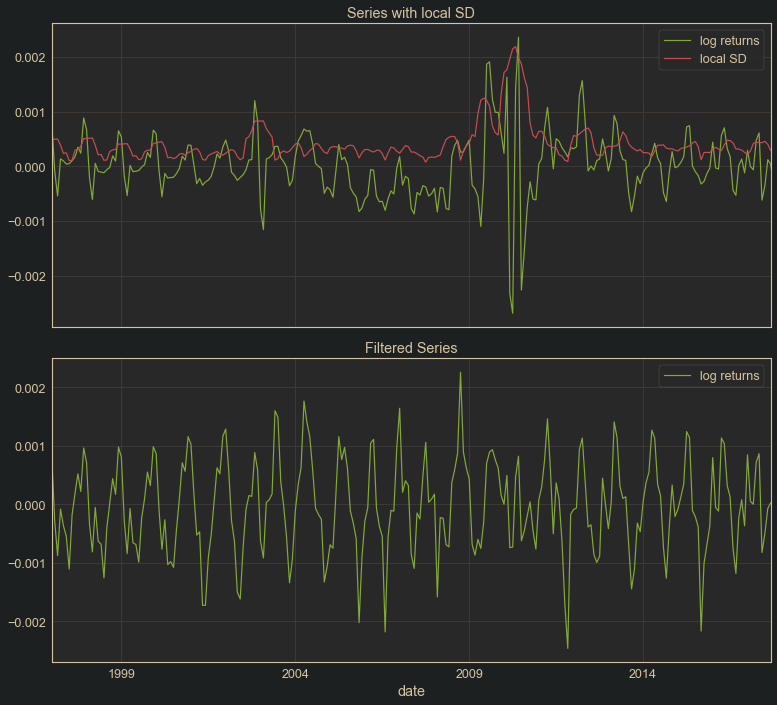

In [349]:
filtered = so_filter(diff_returns, 
                     #sd_method='GARCH',
                     l=7, 
                     k=15, 
                     visualize=True, 
                     hp_filter=False, 
                     lamb=60000)

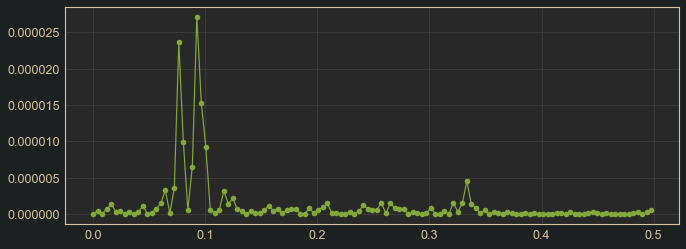

In [350]:
pgram = check_pgram(filtered)

In [351]:
pgram.head()

Period      Spec
0  10.826087  0.000027
1  13.105263  0.000024
2  10.375000  0.000015
3  12.450000  0.000010
4   9.960000  0.000009

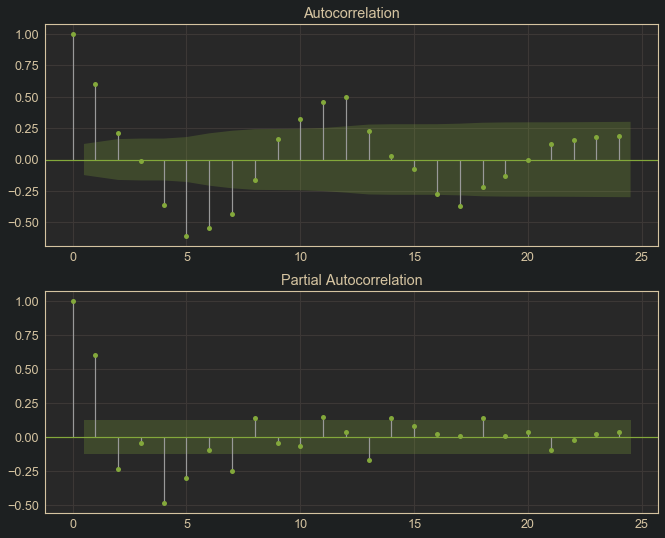

In [352]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(11,9))
plot_acf(filtered, ax=ax1);
plot_pacf(filtered, ax=ax2);

In [353]:
num_periods = 2
fs = fourier_series(filtered, freqs=pgram.Period[:num_periods], K=1)

In [354]:
# Now to fit a model to this filtered series
rlist = FloatVector(filtered)
autoarima = r['auto.arima'](r['ts'](rlist, 
                                    freq=12
                                   ))
param, sparam = get_params(autoarima)
print(param, sparam)

(1, 0, 1) (1, 0, 0, 12)


In [355]:
#fs_cols = [0,2,4,6]
fs_cols = [0,2]

In [356]:
# Using the recommended parameters
model = SARIMAX(filtered,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs.iloc[:, 
                             fs_cols
                            ]
               ).fit()
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     filtered_series   No. Observations:                  249
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                1530.209
Date:                             Fri, 11 Sep 2020   AIC                          -3048.417
Time:                                     14:40:29   BIC                          -3027.312
Sample:                                 01-01-1997   HQIC                         -3039.922
                                      - 09-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-10.83       0.0005   9.65e-05      4.791      0.000       0.000       0.001
S1-13.11      -0.0004      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [357]:
# The metrics have improved, although the null hypothesis of homoscedastic residuals is
# still being rejected. The Ljung-Box null hypothesis of non-autocorrelated residuals is not
# rejected, which is an improvement

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


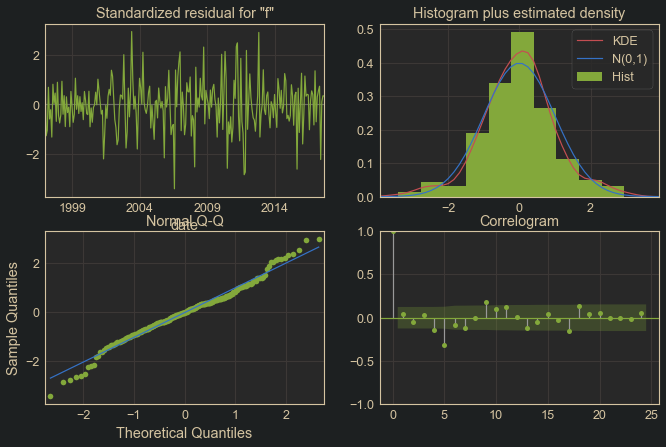

In [358]:
model.plot_diagnostics();

In [359]:
mod = SARIMAX(filtered,
                order=param,
                seasonal_order=sparam,
                #enforce_stationary=False,
                #enforce_invertibility=False,
                exog=fs.iloc[:, 
                             fs_cols
                            ]
               )
res = mod.filter(model.params)

In [360]:
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     filtered_series   No. Observations:                  249
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                1530.209
Date:                             Fri, 11 Sep 2020   AIC                          -3048.417
Time:                                     14:40:41   BIC                          -3027.312
Sample:                                 01-01-1997   HQIC                         -3039.922
                                      - 09-01-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-10.83       0.0005   9.65e-05      4.791      0.000       0.000       0.001
S1-13.11      -0.0004      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


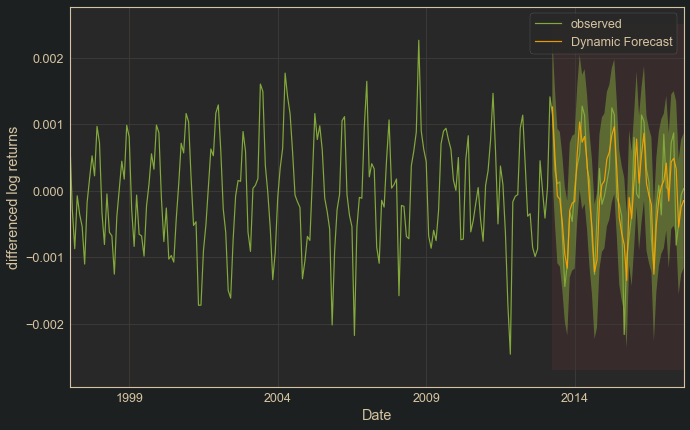

In [361]:
# Get dynamic predictions with confidence intervals
start='2013-04-01'
end='2018-04-01'
pred_dynamic = model.get_prediction(
                                    #dynamic=start, 
                                    #full_results=True                                                 ]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int().loc[start:]

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.loc[start:].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('differenced log returns')
plt.legend()
plt.show()

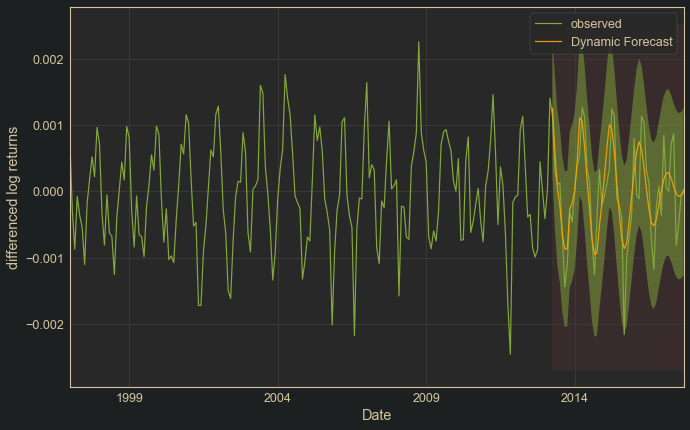

In [362]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(#start='2013-04', 
                                    #end='2018-04', 
                                    dynamic=start, 
                                    #full_results=True,
                                    #exog=fourier_series(filtered, 
                                    #                     freqs=pgram.Period[:num_periods],
                                    #                     K=1
                                    #                    ).loc['2012-09':'2013-03'].iloc[:, 
                                    #                                                    fs_cols
                                    #                                                   ]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int().loc[start:]

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.loc[start:].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('differenced log returns')
plt.legend()
plt.show()

In [363]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60,
                               exog=fourier_series(filtered, 
                                                         freqs=pgram.Period[:num_periods],
                                                         K=1,
                                                        h=60
                                                        ).iloc[:, 
                                                               fs_cols
                                                              ])

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

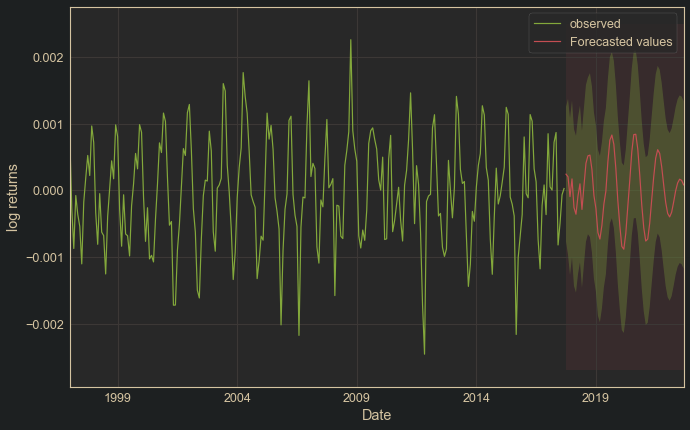

In [364]:
# Plot future predictions with confidence intervals
ax = filtered.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

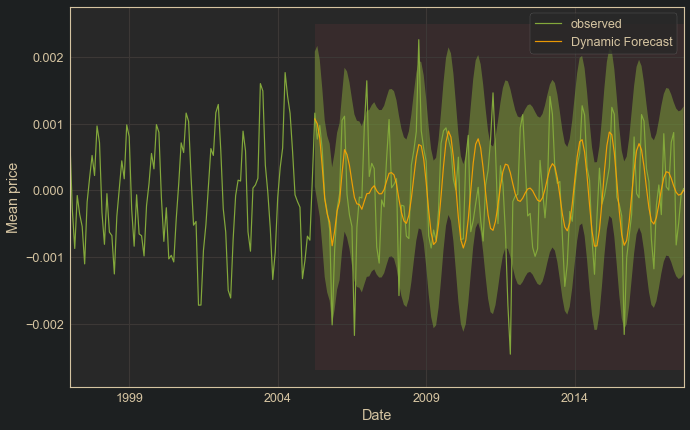

In [365]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(#start=, 
                                    #end='2018-04', 
                                    dynamic='2005-04-01', 
                                    #full_results=True,
                                    #exog=fourier_series(filtered, 
                                    #                     freqs=pgram.Period[:num_periods],
                                    #                     K=1
                                    #                    ).loc['2004-09':'2005-03'].iloc[:, 
                                    #                                                    fs_cols
                                    #                                                   ]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int().loc['2005-04-01':]

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.loc['2005-04-01':].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2005-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [366]:
print(param, sparam)

(1, 0, 1) (1, 0, 0, 12)


In [367]:
fs_ext = pd.concat([fs, fourier_series(filtered, freqs=pgram.Period[:2], K=1, h=7)], axis=0)

In [368]:
mod = SARIMAX(log_returns.loc[fs_ext.index],
                order=(1,1,1),
                seasonal_order=sparam,
                #simple_differencing=True,
                enforce_stationary=False,
                enforce_invertibility=False,
               exog=np.cumsum(fs_ext.iloc[:, 
                                      fs_cols
                                     ])
               )
coefs = model.params
res = mod.smooth(coefs)
print(res.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         log returns   No. Observations:                  256
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                1533.834
Date:                             Fri, 11 Sep 2020   AIC                          -3055.669
Time:                                     14:41:04   BIC                          -3034.421
Sample:                                 01-01-1997   HQIC                         -3047.122
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-10.83       0.0005   9.45e-05      4.890      0.000       0.000       0.001
S1-13.11      -0.0004      

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


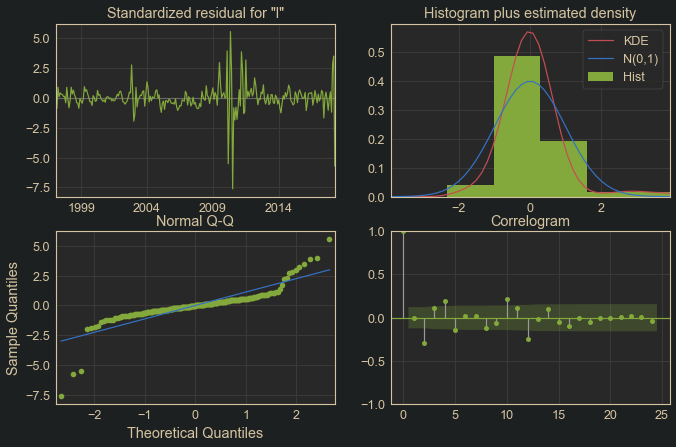

In [369]:
res.plot_diagnostics();

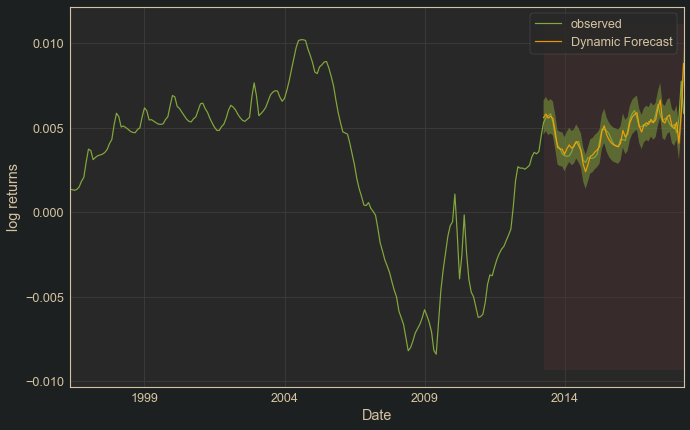

In [370]:
# Get dynamic predictions with confidence intervals
pred = res.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [371]:
((pred.predicted_mean - log_returns)**2).mean()

3.882851480262683e-07

In [372]:
((log_returns - log_returns.shift(1))**2).mean()

3.726542334908291e-07

We can see that the MSE for the model using the coefficients from the model fitted over the filtered data is actually higher than for a random walk model.

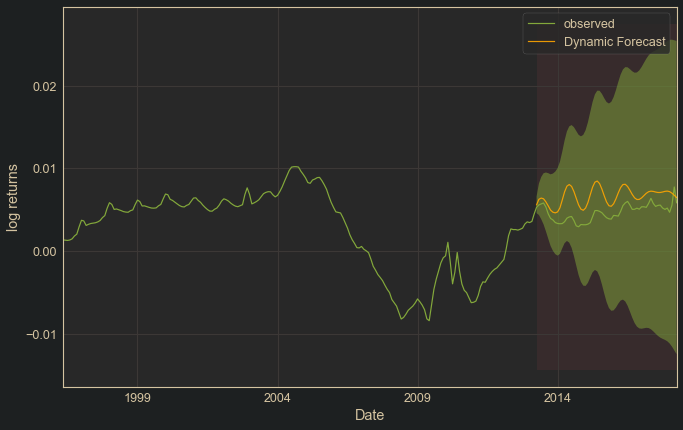

In [373]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2013-04', 
                                  end='2018-04', 
                                  dynamic=True, 
                                  full_results=True,
                                  exog=np.cumsum(fourier_series(filtered, 
                                                         freqs=pgram.Period[:2],
                                                         K=1
                                                        ).loc['2012-09':'2013-03'].iloc[:, 
                                                                                        fs_cols
                                                                                       ])
                                 )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

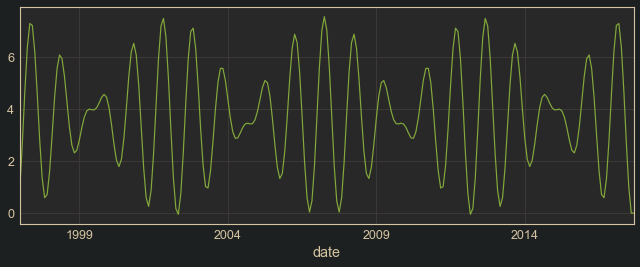

In [374]:
fs.cumsum().iloc[:, fs_cols].sum(axis=1).plot(figsize=(11,4))

S1-10.83  C1-10.83  S1-13.11  C1-13.11
2017-10-01  0.548337  0.836257  0.461282  0.887253
2017-11-01  0.917102  0.398653  0.818549  0.574437

S1-10.83  C1-10.83  S1-13.11  C1-13.11
2017-10-01  0.548337  0.836257  0.461282  0.887253
2017-11-01  1.465439  1.234910  1.279831  1.461691

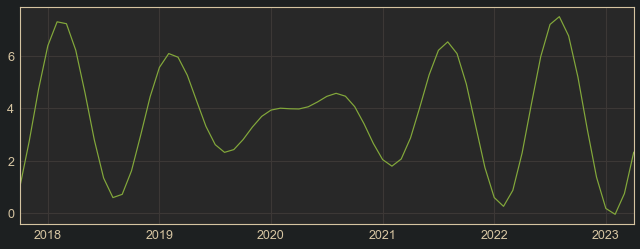

In [375]:
# Let's look at a 5 year forecast with this model
# First we will need out of sample fourier series
fs_fore = fourier_series(filtered, 
                          freqs=pgram.Period[:2],
                          K=1,
                          h=67
                         )
display(fs_fore.head(2))
display(fs_fore.cumsum().head(2))
fs_fore.cumsum().iloc[:, fs_cols].sum(axis=1).plot(figsize=(11,4))

S1-10.83      C1-10.83      S1-13.11      C1-13.11
2017-09-01  8.215650e-15 -2.531308e-14 -7.616818e-14 -1.216804e-13
2017-10-01  5.483372e-01  8.362573e-01  4.612822e-01  8.872535e-01
2017-11-01  1.465439e+00  1.234910e+00  1.279831e+00  1.461691e+00

S1-10.83  C1-10.83  S1-13.11  C1-13.11
2018-05-01  1.291687 -2.205026  3.298463 -2.192693
2018-06-01  0.419422 -1.715992  2.376404 -2.579744

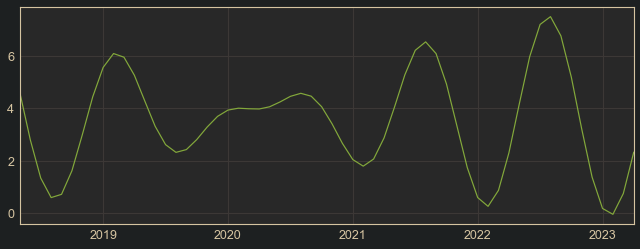

In [376]:
fs_fore = pd.concat([fs_ext, fs_fore.iloc[7:]], axis=0).cumsum()
display(fs_fore.loc['2017-09-01':'2017-11-01'])
fs_fore = fs_fore.iloc[-60:]
display(fs_fore.head(2))
fs_fore.iloc[:, fs_cols].sum(axis=1).plot(figsize=(11,4))

In [377]:
# Concatenating the leading data before taking the cumulative sum has not appeared to have an
# impact on the out of sample fourier series, but this may only be because the cumulative sum
# value right at the end of the sample is so close to zero. For other series, it would probably
# be better to concatenate the leading data first 

In [378]:
prediction = res.get_forecast(60, exog=fs_fore.iloc[:, 
                                                    fs_cols
                                                    ])

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

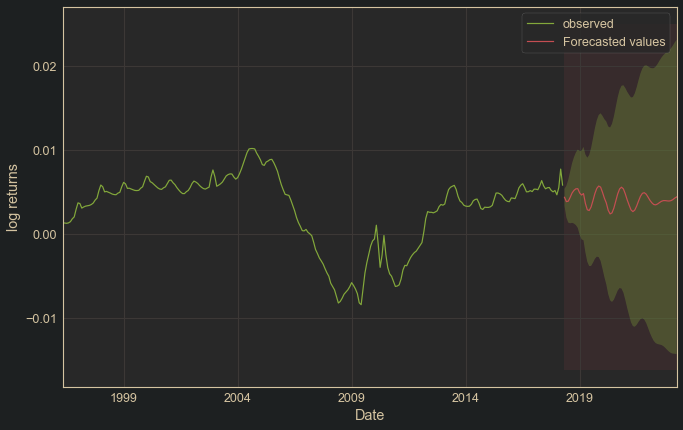

In [379]:
# Plot future predictions with confidence intervals
ax = log_returns.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [380]:
# This model is anticipating an upcoming reduction in the mean of log returns

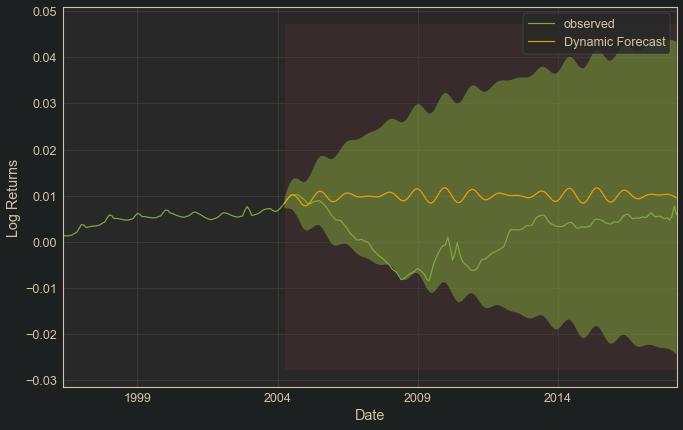

In [381]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2004-04', 
                                  end='2018-04', 
                                  dynamic=True, 
                                  full_results=True,
                                  exog=np.cumsum(fourier_series(filtered, 
                                                         freqs=pgram.Period[:2],
                                                         K=1
                                                        ).loc['2003-09':'2004-03'].iloc[:, 
                                                                                        fs_cols
                                                                                       ])
                                 )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2004-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

We can see that this model which incorporates the sine components of the fourier series for the periods of high spectral density generated by the periodogram has captured a good amount of the seasonal movement which was not perfectly yearly that we have observed. The periods were between 10 and 11 months and just under 14 months. Interestingly, the model still has a significant coefficient for the 12 month seasonality component as well. We can see that not only did this model have confidence bands that captured the crash.

In [382]:
# Now to try a model with parameters recommended without seasonality
rlist = FloatVector(filtered)
autoarima = r['auto.arima'](r['ts'](rlist, 
                                    #freq=12
                                   ))
param, sparam = get_params(autoarima)
print(param, sparam)

(5, 0, 2) (0, 0, 0, 0)


In [383]:
# Using the recommended parameters
model = SARIMAX(filtered,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=fs.iloc[:, 
                             fs_cols
                            ]
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:        filtered_series   No. Observations:                  249
Model:               SARIMAX(5, 0, 2)   Log Likelihood                1541.003
Date:                Fri, 11 Sep 2020   AIC                          -3062.007
Time:                        14:45:58   BIC                          -3026.832
Sample:                    01-01-1997   HQIC                         -3047.848
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-10.83       0.0005      0.000      3.018      0.003       0.000       0.001
S1-13.11      -0.0004      0.000     -3.799      0.000      -0.001      -0.000
ar.L1          0.2774      0.060      4.616      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [384]:
# We can see that the log likelihood of this model has improved slightly, and the AIC has also
# decreased slightly, which is good. The Ljung-Box test also is now not having the null
# hypothesis of autocorrelated residuals rejected.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


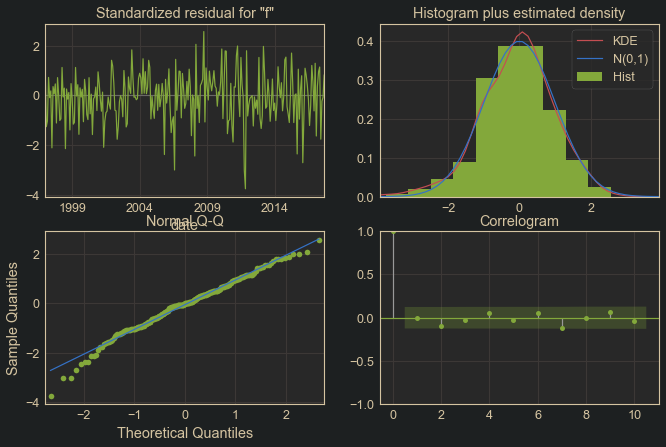

In [385]:
model.plot_diagnostics();

In [386]:
mod = SARIMAX(filtered,
                order=param,
                seasonal_order=sparam,
                #enforce_stationary=False,
                #enforce_invertibility=False,
                exog=fs.iloc[:, 
                             fs_cols
                            ]
               )
res = mod.filter(model.params)

In [387]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:        filtered_series   No. Observations:                  249
Model:               SARIMAX(5, 0, 2)   Log Likelihood                1541.003
Date:                Fri, 11 Sep 2020   AIC                          -3062.007
Time:                        14:46:12   BIC                          -3026.832
Sample:                    01-01-1997   HQIC                         -3047.848
                         - 09-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-10.83       0.0005      0.000      3.018      0.003       0.000       0.001
S1-13.11      -0.0004      0.000     -3.799      0.000      -0.001      -0.000
ar.L1          0.2774      0.060      4.616      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


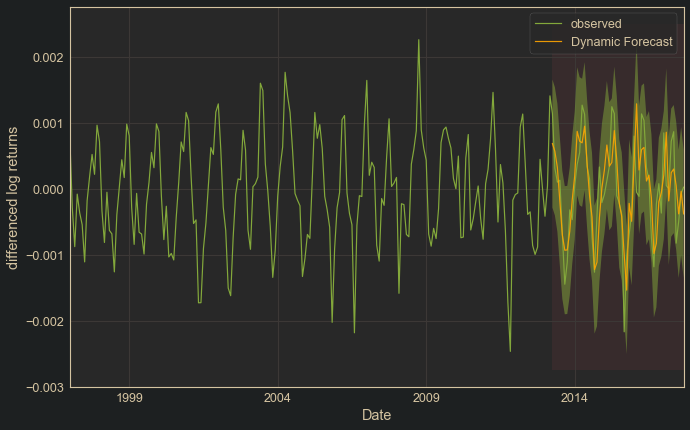

In [388]:
# Get dynamic predictions with confidence intervals
start='2013-04-01'
end='2018-04-01'
pred_dynamic = model.get_prediction(
                                    #dynamic=start, 
                                    #full_results=True                                                 ]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int().loc[start:]

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.loc[start:].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('differenced log returns')
plt.legend()
plt.show()

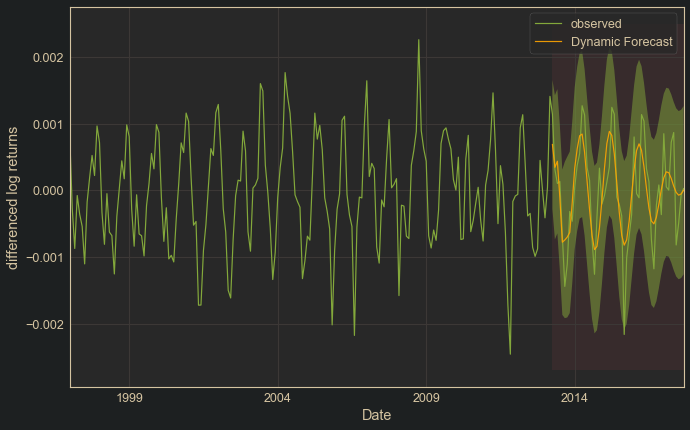

In [389]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(#start='2013-04', 
                                    #end='2018-04', 
                                    dynamic=start, 
                                    #full_results=True,
                                    #exog=fourier_series(filtered, 
                                    #                     freqs=pgram.Period[:num_periods],
                                    #                     K=1
                                    #                    ).loc['2012-09':'2013-03'].iloc[:, 
                                    #                                                    fs_cols
                                    #                                                   ]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int().loc[start:]

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.loc[start:].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('differenced log returns')
plt.legend()
plt.show()

In [390]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60,
                               exog=fourier_series(filtered, 
                                                         freqs=pgram.Period[:num_periods],
                                                         K=1,
                                                        h=60
                                                        ).iloc[:, 
                                                               fs_cols
                                                              ])

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

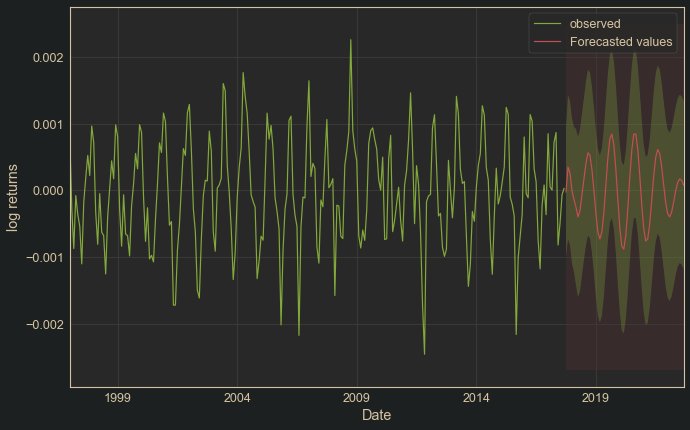

In [391]:
# Plot future predictions with confidence intervals
ax = filtered.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

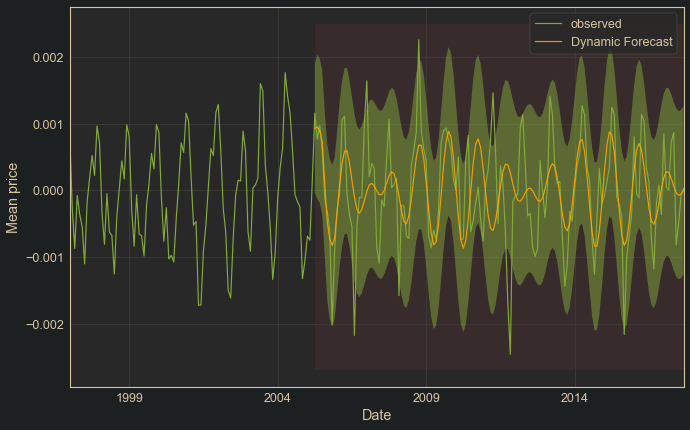

In [392]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(#start=, 
                                    #end='2018-04', 
                                    dynamic='2005-04-01', 
                                    #full_results=True,
                                    #exog=fourier_series(filtered, 
                                    #                     freqs=pgram.Period[:num_periods],
                                    #                     K=1
                                    #                    ).loc['2004-09':'2005-03'].iloc[:, 
                                    #                                                    fs_cols
                                    #                                                   ]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int().loc['2005-04-01':]

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.loc['2005-04-01':].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2005-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [393]:
print(param, sparam)

(5, 0, 2) (0, 0, 0, 0)


In [394]:
fs_ext = pd.concat([fs, fourier_series(filtered, freqs=pgram.Period[:2], K=1, h=7)], axis=0)

In [395]:
mod = SARIMAX(log_returns.loc[fs_ext.index],
                order=(5,1,2),
                seasonal_order=sparam,
                #simple_differencing=True,
                enforce_stationary=False,
                enforce_invertibility=False,
               exog=np.cumsum(fs_ext.iloc[:, 
                                      fs_cols
                                     ])
               )
coefs = model.params
res = mod.smooth(coefs)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  256
Model:               SARIMAX(5, 1, 2)   Log Likelihood                1535.358
Date:                Fri, 11 Sep 2020   AIC                          -3050.716
Time:                        14:46:33   BIC                          -3015.304
Sample:                    01-01-1997   HQIC                         -3036.472
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-10.83       0.0005      0.000      2.815      0.005       0.000       0.001
S1-13.11      -0.0004      0.000     -3.611      0.000      -0.001      -0.000
ar.L1          0.2774      0.054      5.135      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


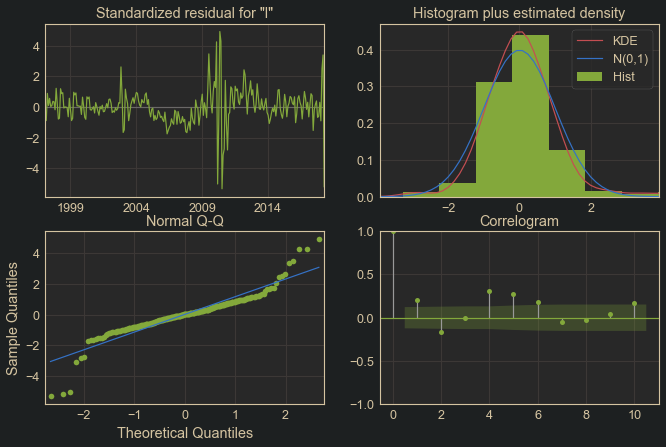

In [396]:
res.plot_diagnostics();

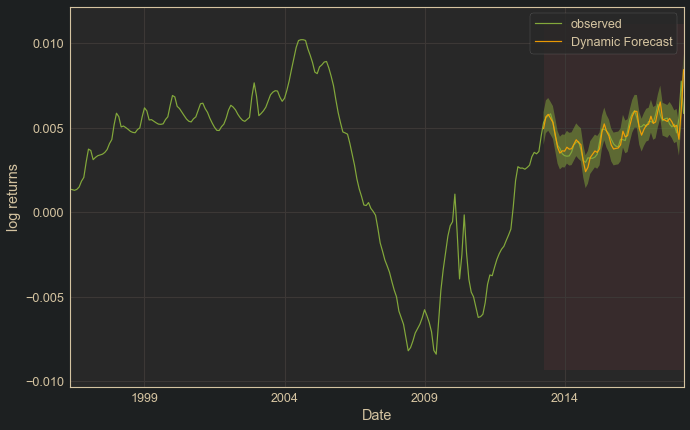

In [397]:
# Get dynamic predictions with confidence intervals
pred = res.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [398]:
((pred.predicted_mean - log_returns)**2).mean()

3.7929860811086697e-07

In [399]:
# We can see that the MSE has decreased slightly from the last model, but is still larger than
# for the ARIMA(3,1,1) on the unfiltered data.

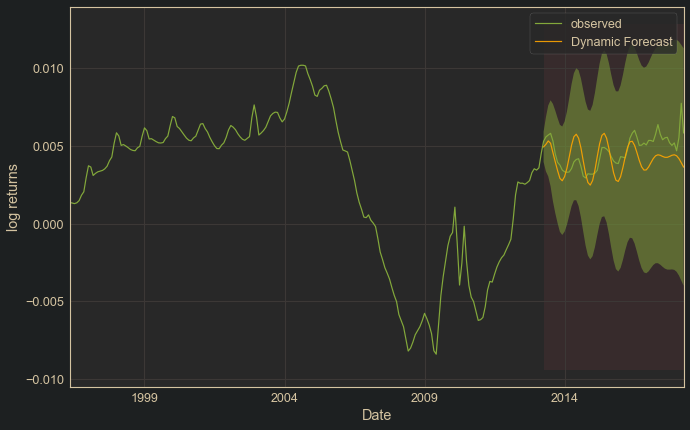

In [400]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2013-04', 
                                  end='2018-04', 
                                  dynamic=True, 
                                  full_results=True,
                                  exog=np.cumsum(fourier_series(filtered, 
                                                         freqs=pgram.Period[:2],
                                                         K=1
                                                        ).loc['2012-09':'2013-03'].iloc[:, 
                                                                                        fs_cols
                                                                                       ])
                                 )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

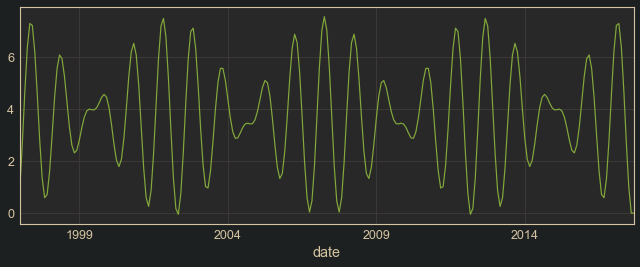

In [401]:
fs.cumsum().iloc[:, fs_cols].sum(axis=1).plot(figsize=(11,4))

S1-10.83  C1-10.83  S1-13.11  C1-13.11
2017-10-01  0.548337  0.836257  0.461282  0.887253
2017-11-01  0.917102  0.398653  0.818549  0.574437

S1-10.83  C1-10.83  S1-13.11  C1-13.11
2017-10-01  0.548337  0.836257  0.461282  0.887253
2017-11-01  1.465439  1.234910  1.279831  1.461691

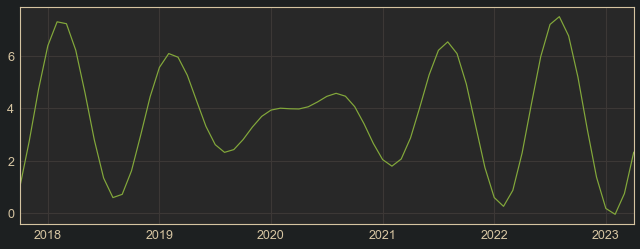

In [402]:
# Let's look at a 5 year forecast with this model
# First we will need out of sample fourier series
fs_fore = fourier_series(filtered, 
                          freqs=pgram.Period[:2],
                          K=1,
                          h=67
                         )
display(fs_fore.head(2))
display(fs_fore.cumsum().head(2))
fs_fore.cumsum().iloc[:, fs_cols].sum(axis=1).plot(figsize=(11,4))

S1-10.83      C1-10.83      S1-13.11      C1-13.11
2017-09-01  8.215650e-15 -2.531308e-14 -7.616818e-14 -1.216804e-13
2017-10-01  5.483372e-01  8.362573e-01  4.612822e-01  8.872535e-01
2017-11-01  1.465439e+00  1.234910e+00  1.279831e+00  1.461691e+00

S1-10.83  C1-10.83  S1-13.11  C1-13.11
2018-05-01  1.291687 -2.205026  3.298463 -2.192693
2018-06-01  0.419422 -1.715992  2.376404 -2.579744

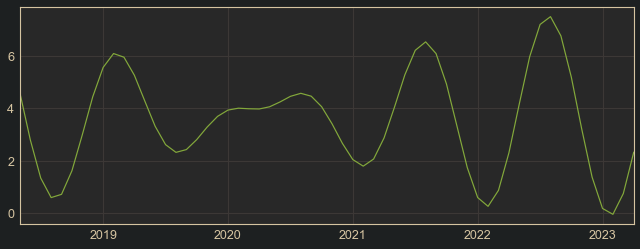

In [403]:
fs_fore = pd.concat([fs_ext, fs_fore.iloc[7:]], axis=0).cumsum()
display(fs_fore.loc['2017-09-01':'2017-11-01'])
fs_fore = fs_fore.iloc[-60:]
display(fs_fore.head(2))
fs_fore.iloc[:, fs_cols].sum(axis=1).plot(figsize=(11,4))

In [404]:
# Concatenating the leading data before taking the cumulative sum has not appeared to have an
# impact on the out of sample fourier series, but this may only be because the cumulative sum
# value right at the end of the sample is so close to zero. For other series, it would probably
# be better to concatenate the leading data first 

In [405]:
prediction = res.get_forecast(60, exog=fs_fore.iloc[:, 
                                                    fs_cols
                                                    ])

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

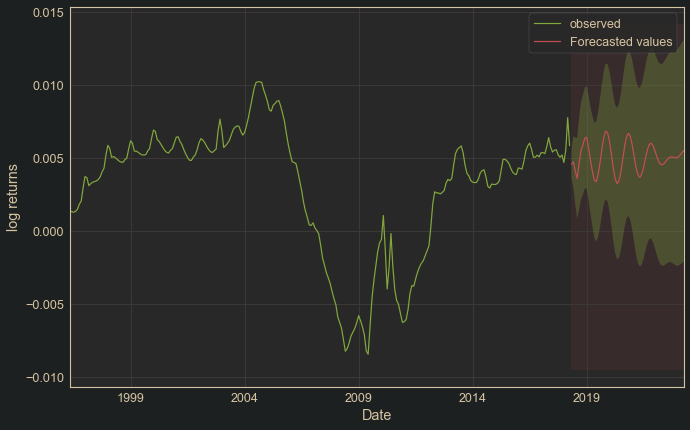

In [406]:
# Plot future predictions with confidence intervals
ax = log_returns.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [407]:
# This model is anticipating an upcoming reduction in the mean of log returns

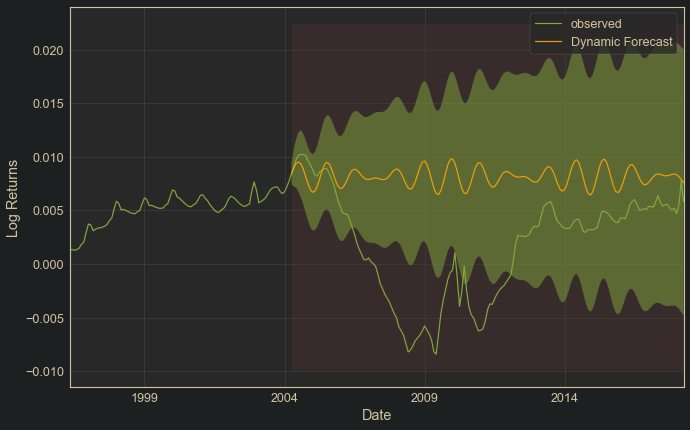

In [408]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2004-04', 
                                  end='2018-04', 
                                  dynamic=True, 
                                  full_results=True,
                                  exog=np.cumsum(fourier_series(filtered, 
                                                         freqs=pgram.Period[:2],
                                                         K=1
                                                        ).loc['2003-09':'2004-03'].iloc[:, 
                                                                                        fs_cols
                                                                                       ])
                                 )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2004-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Log Returns')
plt.legend()
plt.show()

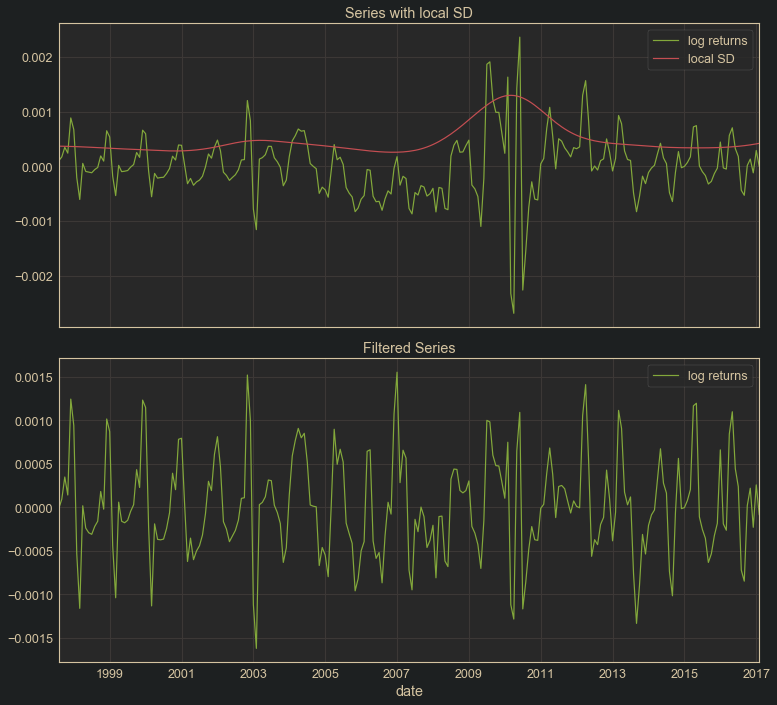

In [409]:
filtered = so_filter(diff_returns, 
                     #sd_method='GARCH',
                     l=15, 
                     k=29, 
                     visualize=True, 
                     #hp_filter=True, 
                     lamb=3000)

In [411]:
# Now to fit a model to this filtered series
rlist = FloatVector(filtered)
autoarima = r['auto.arima'](r['ts'](rlist, 
                                    freq=12
                                   ))
param, sparam = get_params(autoarima)
print(param, sparam)

(4, 0, 2) (1, 0, 2, 12)


In [412]:
# Using the recommended parameters
model = SARIMAX(filtered,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False,
                #exog=fs.iloc[:, [0,2]]
               ).fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    filtered_series   No. Observations:                  235
Model:             SARIMAX(4, 0, 2)x(1, 0, 2, 12)   Log Likelihood                1492.970
Date:                            Fri, 11 Sep 2020   AIC                          -2965.940
Time:                                    14:48:23   BIC                          -2931.344
Sample:                                08-01-1997   HQIC                         -2951.993
                                     - 02-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1581      0.180      6.434      0.000       0.805       1.511
ar.L2         -0.8556      0.240   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [413]:
# The metrics have improved, although the null hypothesis of homoscedastic residuals is
# still being rejected. The Ljung-Box null hypothesis of non-autocorrelated residuals is not
# rejected, which is an improvement

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


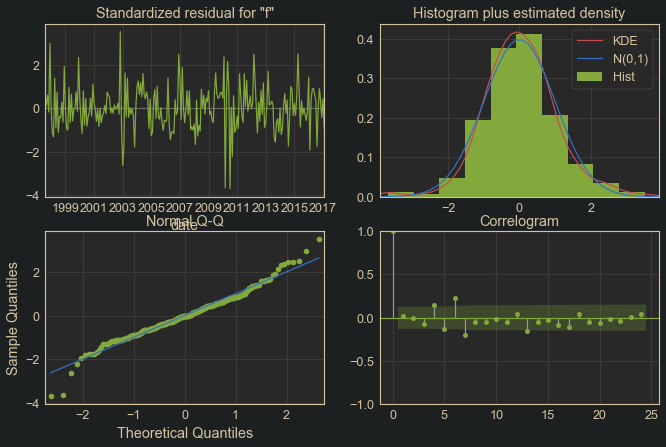

In [414]:
model.plot_diagnostics();

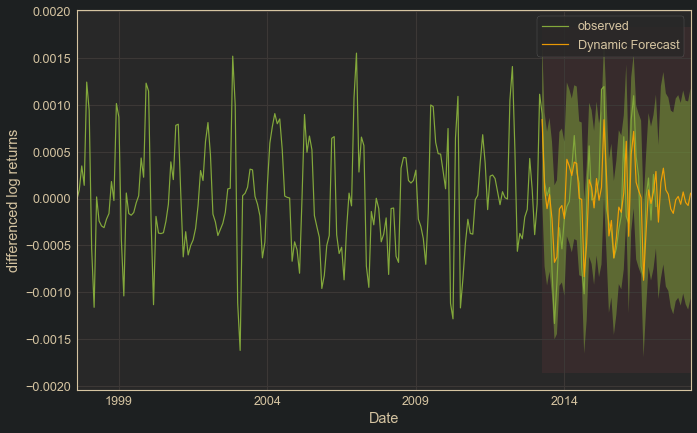

In [415]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', 
                                    end='2018-04', 
                                    dynamic=False, 
                                    full_results=True,
                                    #exog=fourier_series(filtered, 
                                    #                     freqs=pgram.Period[:2],
                                    #                     K=1
                                    #                    ).loc['2012-09':'2013-03'].iloc[:, [0,2]]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('differenced log returns')
plt.legend()
plt.show()

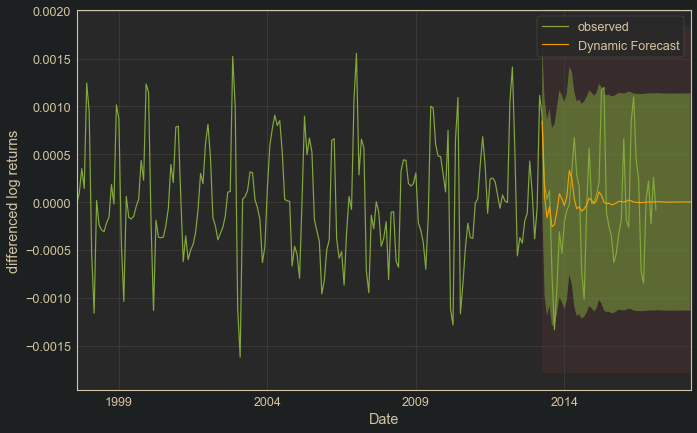

In [416]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2013-04', 
                                    end='2018-04', 
                                    dynamic=True, 
                                    full_results=True,
                                    #exog=fourier_series(filtered, 
                                    #                     freqs=pgram.Period[:2],
                                    #                     K=1
                                    #                    ).loc['2012-09':'2013-03'].iloc[:, [0,2]]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('differenced log returns')
plt.legend()
plt.show()

In [417]:
# Let's look at a 5 year forecast with this model
prediction = model.get_forecast(60,
                               #exog=fourier_series(filtered, 
                               #                          freqs=pgram.Period[:2],
                               #                          K=1,
                               #                         h=60
                               #                         ).iloc[:, [0,2]]
                               )

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

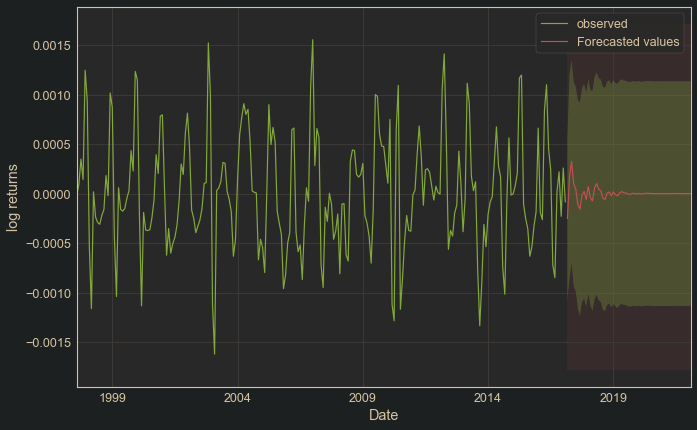

In [418]:
# Plot future predictions with confidence intervals
ax = filtered.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

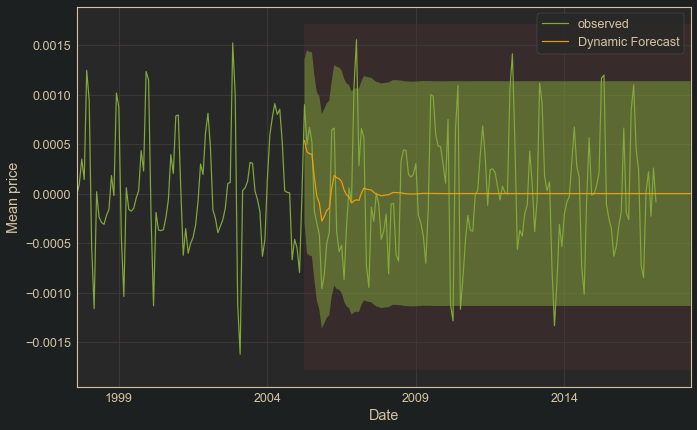

In [419]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2005-04', 
                                    end='2018-04', 
                                    dynamic=True, 
                                    full_results=True,
                                    #exog=fourier_series(filtered, 
                                    #                     freqs=pgram.Period[:2],
                                    #                     K=1
                                    #                    ).loc['2004-09':'2005-03'].iloc[:, [0,2]]
                                   )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = filtered.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2005-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

Now that we have generated coefficients on the filtered data, we will smooth another model with these coefficients, then see how good the predictive power of the coefficients are.

In [420]:
print(param, sparam)

(4, 0, 2) (1, 0, 2, 12)


In [421]:
mod = SARIMAX(log_returns,
                order=(4,1,2),
                seasonal_order=sparam,
                #simple_differencing=True,
                enforce_stationary=False,
                enforce_invertibility=False,
               #exog=fs.iloc[:, [0,2]]
               )
coefs = model.params
res = mod.smooth(coefs)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        log returns   No. Observations:                  264
Model:             SARIMAX(4, 1, 2)x(1, 0, 2, 12)   Log Likelihood                1587.699
Date:                            Fri, 11 Sep 2020   AIC                          -3155.398
Time:                                    14:48:58   BIC                          -3119.676
Sample:                                05-01-1996   HQIC                         -3141.042
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1581      0.070     16.548      0.000       1.021       1.295
ar.L2         -0.8556      0.031   

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


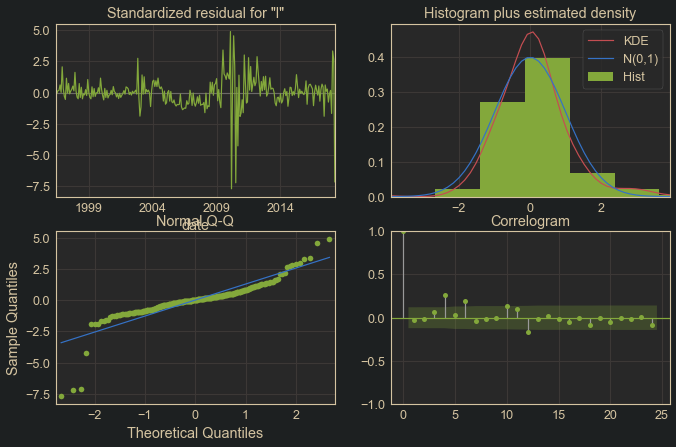

In [422]:
res.plot_diagnostics();

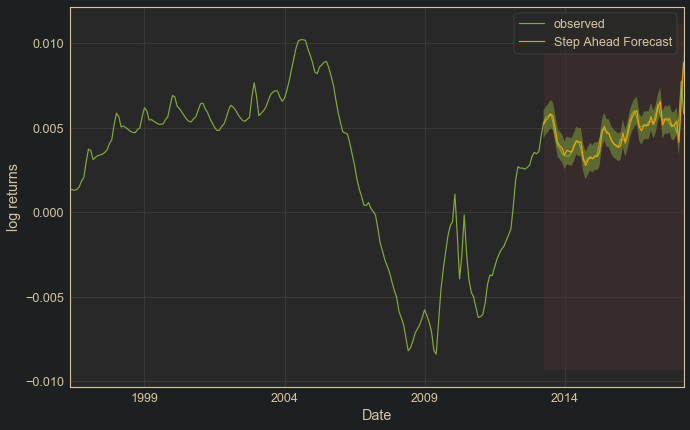

In [427]:
# Get dynamic predictions with confidence intervals
pred = res.get_prediction()
pred_conf = pred.conf_int().loc['2013-04-01':]

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2013-04-01':].plot(ax=ax, label='Step Ahead Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [428]:
((pred.predicted_mean - log_returns)**2).mean()

2.9371146693658077e-07

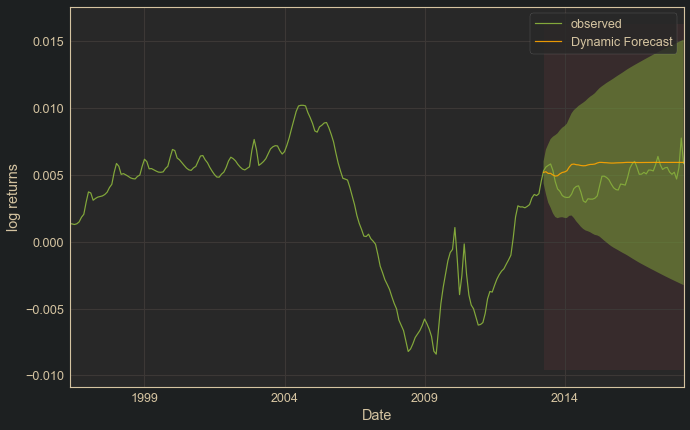

In [429]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2013-04', 
                                  end='2018-04', 
                                  dynamic=True, 
                                  full_results=True,
                                  #exog=fourier_series(filtered, 
                                  #                       freqs=pgram.Period[:2],
                                  #                       K=1
                                  #                      ).loc['2012-09':'2013-03'].iloc[:, [0,2]]
                                 )
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [430]:
# Let's look at a 5 year forecast with this model
prediction = res.get_forecast(60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

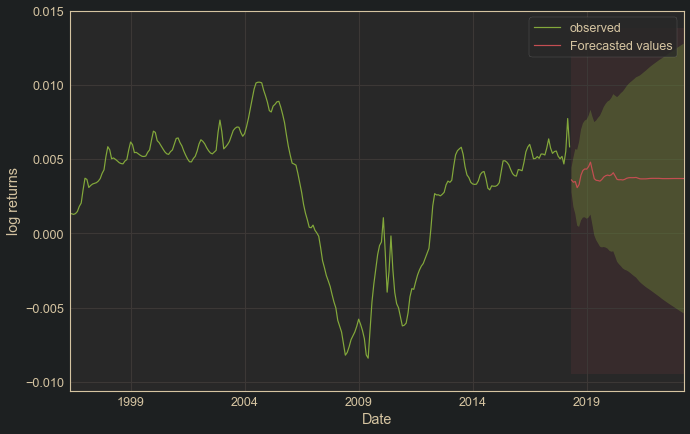

In [431]:
# Plot future predictions with confidence intervals
ax = log_returns.plot(label='observed')
prediction.predicted_mean.plot(label='Forecasted values', ax=ax)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1],
                alpha=0.3
               )

ax.fill_betweenx(ax.get_ylim(), pred_conf.index[0], pred_conf.index[-1],
                 alpha=0.1,
                 zorder=-1
                )

ax.set_xlabel('Date')
ax.set_ylabel('log returns')
plt.legend()
plt.show()

In [432]:
# This model is anticipating an upcoming reduction in the mean of log returns

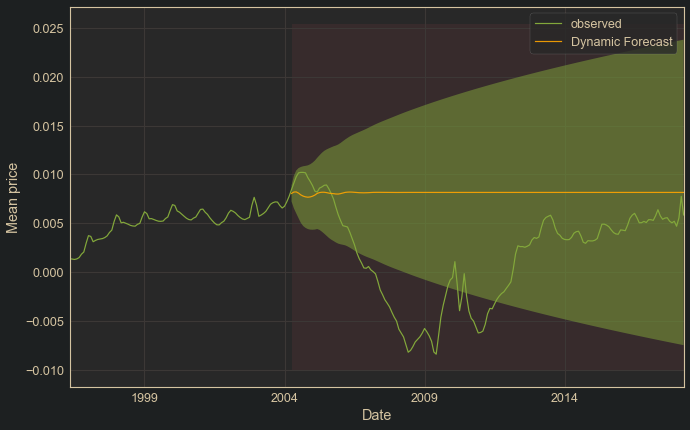

In [433]:
# Get dynamic predictions with confidence intervals
pred_dynamic = res.get_prediction(start='2004-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.5
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2004-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

#### Notes:
We can see that by and large, using coefficients fit to filtered versions of the log returns series has not improved the forecasting power of the model. This may be an effective technique for other datasets, but it does not seem to be helping here. The issue with this time series is what is called regime switching, since the series is covering a time span containing sub-periods which have quite different macroeconomic circumstances. Another thing to mention is that in the first 10 years of the data, the seasonality seems very uniformly yearly, but by the time we get to the end of the series, it seems as though these yearly seasonal peaks have shifted slightly. This means that there may still be yearly seasonality, but it is taking on a different form in more recent years. This is another example of a regime switch. This is causing our coefficient estimates to be biased to outdated patterns in the data, and the best way to get accurate modeling of the future is likely to be limiting the time window to the more recent years after the crash played its course, and a new regularity established itself in the market. Another option would be to use a regime switching time series model, but that is beyond the scope of this project and the curriculum of the course so far.

### Removing the heteroscedasticity by limiting time window

Let's look again at the plot of the price means to see where a good cutoff point might be:

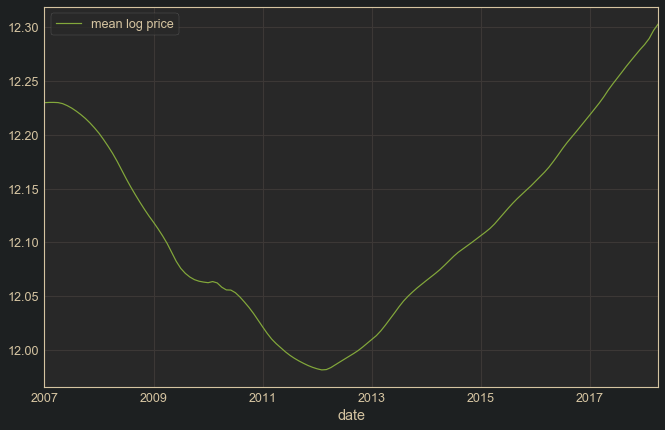

In [434]:
means_fix['2007':].plot(figsize=(11,7))

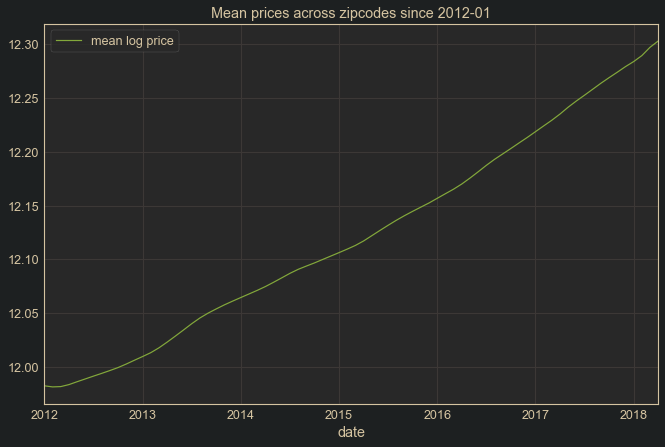

In [435]:
# It looks like the beginning of 2012 would make a good cutoff point, let's see that:
means_fix['2012':].plot(figsize=(11,7))
plt.title("Mean prices across zipcodes since 2012-01");

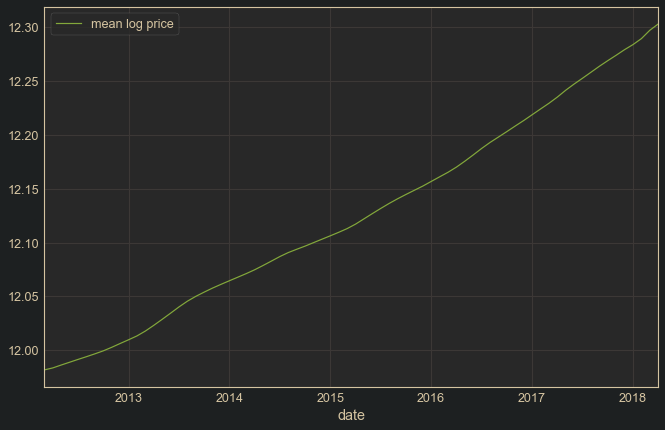

In [436]:
# This still has a bit of a dip in it, I will index a bit further into 2012
means_fix['2012-03':].plot(figsize=(11,7))

In [472]:
# Now to generate log returns from this new window
means_trim = means_fix['2012-03':]
log_returns_trim = means_trim['mean log price'].diff().dropna()
log_returns_trim.name = 'log returns'

In [473]:
log_returns_trim

date
2012-04-01    0.001861
2012-05-01    0.002684
2012-06-01    0.002599
2012-07-01    0.002604
2012-08-01    0.002536
                ...   
2017-12-01    0.005200
2018-01-01    0.004689
2018-02-01    0.005541
2018-03-01    0.007752
2018-04-01    0.005844
Freq: MS, Name: log returns, Length: 73, dtype: float64

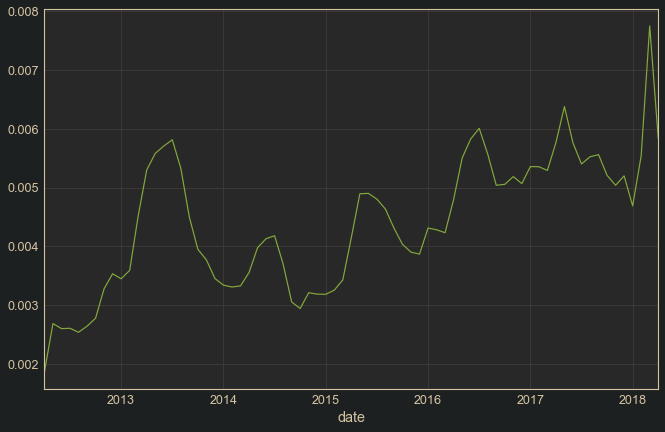

In [474]:
log_returns_trim.plot();

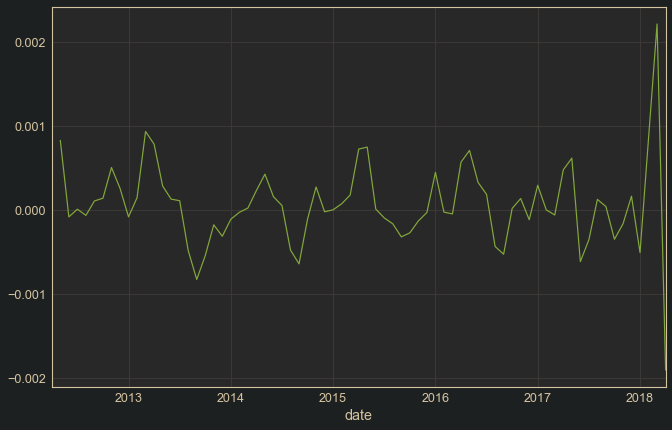

In [475]:
log_returns_trim.diff().plot();

In [552]:
from functions.tsa import *

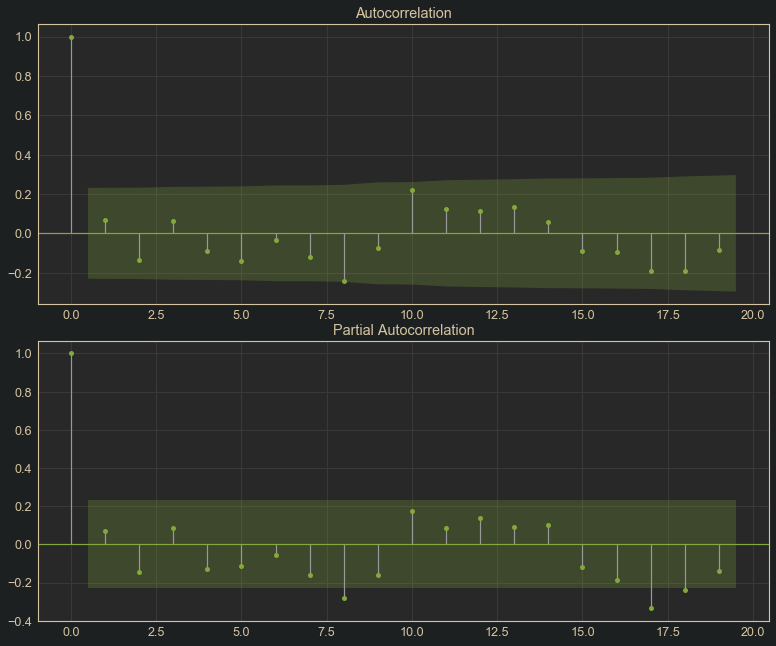

In [553]:
check_autocorrelation(log_returns_trim.diff().dropna())

In [500]:
# This does not look promising... there appears not to be much autocorrelation in the differenced
# series. This might mean it is white noise, and not good for ARIMA modeling
rlist = FloatVector(log_returns_trim)
rmodel = r['auto.arima'](r['ts'](rlist, 
                                 freq=12
                                ))
print(rmodel)

Series: structure(c(0.00186127037622086, 0.00268434963076203, 0.00259855873178516,  0.00260412132971233, 0.00253611111204322, 0.00263971348209857,  0.00277588427522169, 0.00327779593122557, 0.00353284021193012,  0.00344750764502777, 0.00358970245814305, 0.00452047778318132,  0.00530038478087924, 0.00558263143643956, 0.00570778001199379,  0.00581484433016577, 0.00532815062999958, 0.00449701085685206,  0.00394919061091414, 0.0037688616943452, 0.00345201473097845,  0.00333841900194898, 0.00330678586179545, 0.00332589359434543,  0.00355378049843402, 0.00397610445953234, 0.0041301643019569,  0.00417970364853026, 0.00369815148076569, 0.00305268498164146,  0.00294026553082283, 0.00321045444874279, 0.00318527563499948,  0.00318378487796345, 0.00325339291986637, 0.00342801208044463,  0.00414950427210847, 0.00489433896466274, 0.0049019845874092,  0.00480354659099724, 0.00463495177256767, 0.00431080905986825,  0.00403475533846631, 0.00390061487562043, 0.00386733433716024,  0.00431147281133271, 0.

In [501]:
# Extracting the model parameters:
param, sparam = get_params(rmodel)

# Making an equivalent model in StatsModels
model = SARIMAX(log_returns_trim,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          log returns   No. Observations:                   73
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood                 344.148
Date:                              Fri, 11 Sep 2020   AIC                           -678.296
Time:                                      15:23:58   BIC                           -667.742
Sample:                                  04-01-2012   HQIC                          -674.160
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9217      0.084     11.010      0.000       0.758       1.086
ma.L1          0.45

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [502]:
# The null hypothesis of the Ljung-Box test that the errors are not autocorrelated is not 
# rejected.
# The null hypothesis of the Heteroskedasticity test that the variance is not changing
# throughout the sample is not rejected.
# The null hypothesis of normal skew and kurtosis of the residuals is rejected, but a 
# visual inspection of the histogram of residuals indicates they are normal enough, the issue
# is the kurtosis being too high, meaning long tails

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


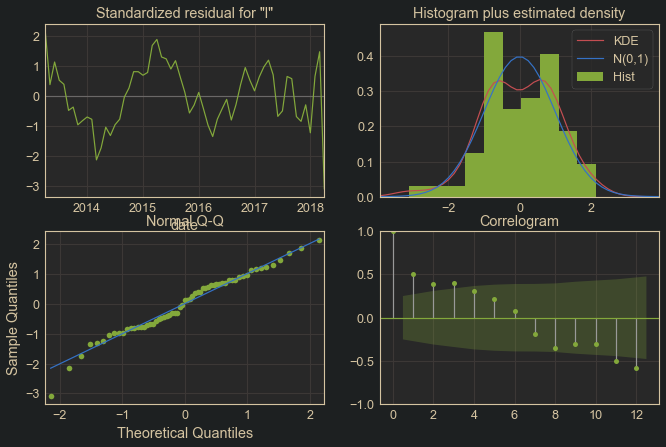

In [503]:
# Checking diagnostics of new model:
model.plot_diagnostics(figsize=(11,7));

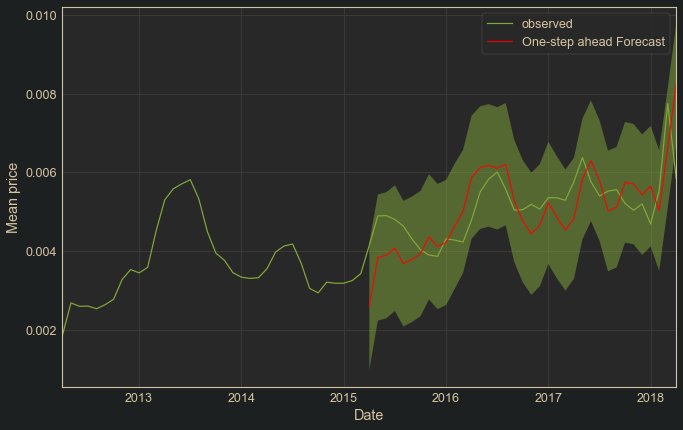

In [504]:
# Get predictions
pred = model.get_prediction()
pred_conf = pred.conf_int().loc['2015-04':]
# Plot observed values
ax = log_returns_trim.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2015-04':].plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [506]:
# We can see this model is not performing well... it seems the residuals are highly
# autocorrelated
forecasted = pred.predicted_mean
truth = log_returns_trim

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 10)))

The Mean Squared Error of our forecasts is 2.2719e-06


In [508]:
# This mean squared error is an order of magnitude higher than what we had been dealing with
# Let's compare it to the MSE for a random walk model
np.mean(log_returns_trim - log_returns_trim.shift(1))

5.531884377865362e-05

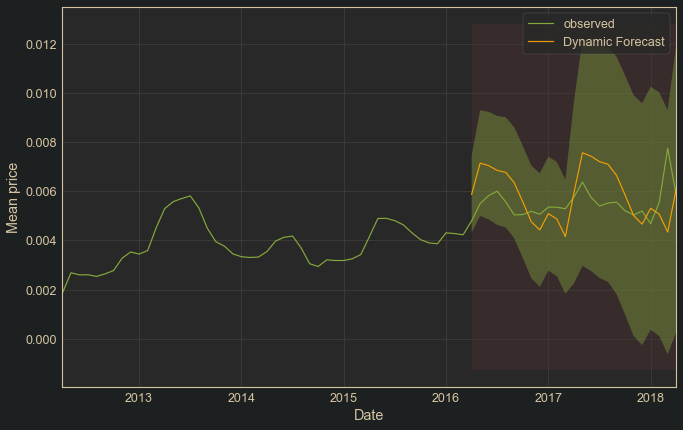

In [507]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2016-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns_trim.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.4
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2016-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [ ]:
# The dynamic predictions here are way off, it looks like the seasonal component may be throwing
# it off. Let's try leaving this out and see if it helps.

In [509]:
# This looks pretty uniform. Let's see how an arima model looks for this data
rlist = FloatVector(log_returns_trim)
rmodel = r['auto.arima'](r['ts'](rlist, 
                                 #freq=12
                                ))
print(rmodel)

Series: structure(c(0.00186127037622086, 0.00268434963076203, 0.00259855873178516,  0.00260412132971233, 0.00253611111204322, 0.00263971348209857,  0.00277588427522169, 0.00327779593122557, 0.00353284021193012,  0.00344750764502777, 0.00358970245814305, 0.00452047778318132,  0.00530038478087924, 0.00558263143643956, 0.00570778001199379,  0.00581484433016577, 0.00532815062999958, 0.00449701085685206,  0.00394919061091414, 0.0037688616943452, 0.00345201473097845,  0.00333841900194898, 0.00330678586179545, 0.00332589359434543,  0.00355378049843402, 0.00397610445953234, 0.0041301643019569,  0.00417970364853026, 0.00369815148076569, 0.00305268498164146,  0.00294026553082283, 0.00321045444874279, 0.00318527563499948,  0.00318378487796345, 0.00325339291986637, 0.00342801208044463,  0.00414950427210847, 0.00489433896466274, 0.0049019845874092,  0.00480354659099724, 0.00463495177256767, 0.00431080905986825,  0.00403475533846631, 0.00390061487562043, 0.00386733433716024,  0.00431147281133271, 0.

In [510]:
# Extracting the model parameters:
param, sparam = get_params(rmodel)

# Making an equivalent model in StatsModels
model = SARIMAX(log_returns_trim,
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                   73
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 447.868
Date:                Fri, 11 Sep 2020   AIC                           -885.736
Time:                        15:27:44   BIC                           -874.353
Sample:                    04-01-2012   HQIC                          -881.205
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4833      0.061     -7.912      0.000      -0.603      -0.364
ar.L2         -0.5699      0.140     -4.064      0.000      -0.845      -0.295
ma.L1          1.0559      0.044     24.113      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


In [511]:
# The null hypothesis of the Ljung-Box test that the errors are not autocorrelated is not 
# rejected.
# The null hypothesis of the Heteroskedasticity test that the variance is not changing
# throughout the sample is not rejected.
# The null hypothesis of normal skew and kurtosis of the residuals is rejected, but a 
# visual inspection of the histogram of residuals indicates they are normal enough, the issue
# is the kurtosis being too high, meaning long tails

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


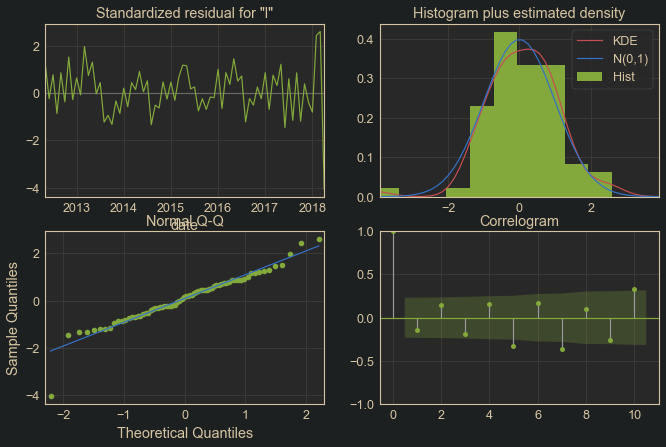

In [512]:
# Checking diagnostics of new model:
model.plot_diagnostics(figsize=(11,7));

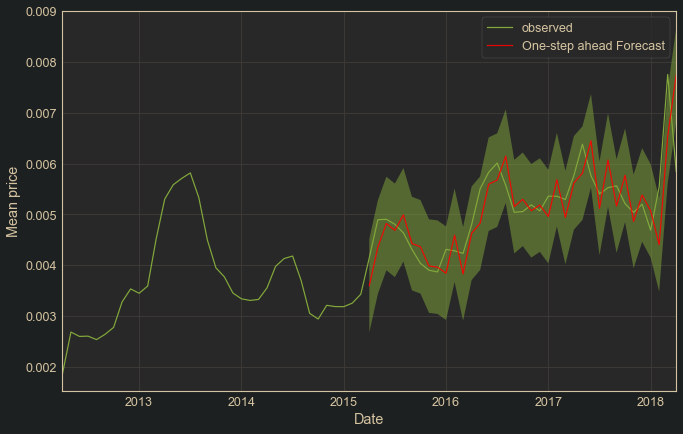

In [513]:
# Get predictions
pred = model.get_prediction()
pred_conf = pred.conf_int().loc['2015-04':]
# Plot observed values
ax = log_returns_trim.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2015-04':].plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [514]:
# We can see this model is not performing well... it seems the residuals are highly
# autocorrelated
forecasted = pred.predicted_mean
truth = log_returns_trim

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 10)))

The Mean Squared Error of our forecasts is 2.757e-07


In [516]:
# This mean squared error is much better than the last model.

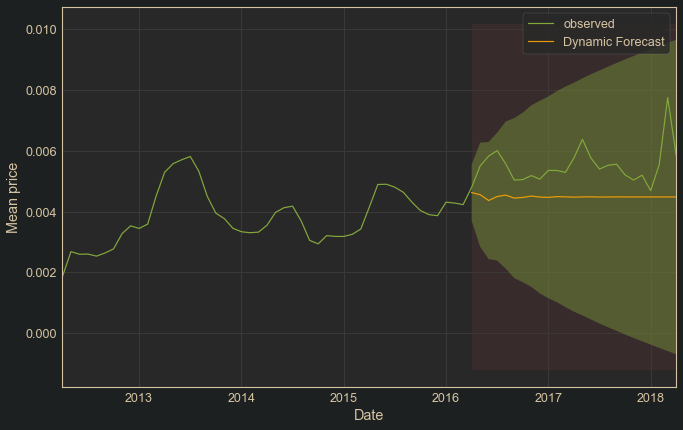

In [517]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2016-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns_trim.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.4
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2016-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [518]:
# This model is not great. It appears as though limiting the time window has not helped us much
# with modeling the log returns. Let's see if a fourier series can help

Period          Spec
0  12.000000  3.504090e-06
1   3.272727  1.475550e-06
2   3.130435  1.273099e-06
3   4.800000  9.378013e-07
4   2.880000  6.897989e-07
5   4.235294  6.853861e-07
6   2.571429  6.426440e-07
7   3.428571  5.631926e-07
8   2.482759  5.520771e-07
9   6.545455  5.506144e-07

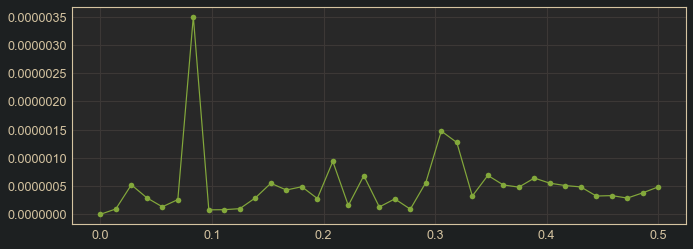

In [519]:
pgram = check_pgram(log_returns_trim.diff().dropna())
pgram

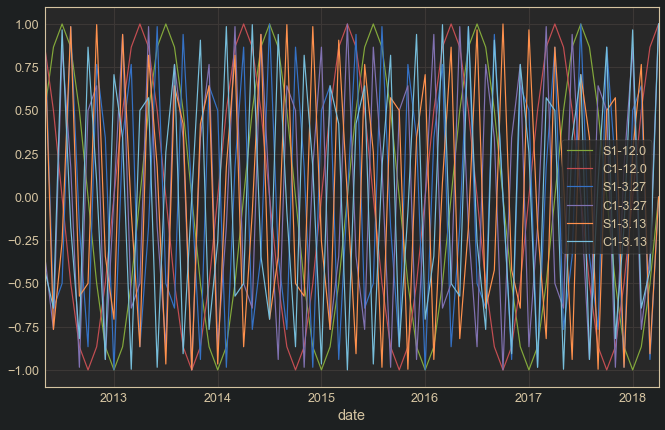

In [539]:
fs = fourier_series(log_returns_trim.diff().dropna(), freqs=pgram.Period[:3], K=1)
fs.plot()

In [540]:
# Making an equivalent model in StatsModels
model = SARIMAX(log_returns_trim.loc[fs.index],
                order=param,
                seasonal_order=sparam,
                enforce_stationary=False,
                enforce_invertibility=False,
                exog=np.cumsum(fs.iloc[:])
               ).fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                   72
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 452.539
Date:                Fri, 11 Sep 2020   AIC                           -883.079
Time:                        15:39:15   BIC                           -858.189
Sample:                    05-01-2012   HQIC                          -873.181
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S1-12.0       -0.0001   7.48e-05     -1.367      0.172      -0.000    4.44e-05
C1-12.0        0.0003   5.59e-05      5.095      0.000       0.000       0.000
S1-3.27     -7.15e-05      0.000     -0.613      0.5

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3225: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  FutureWarning


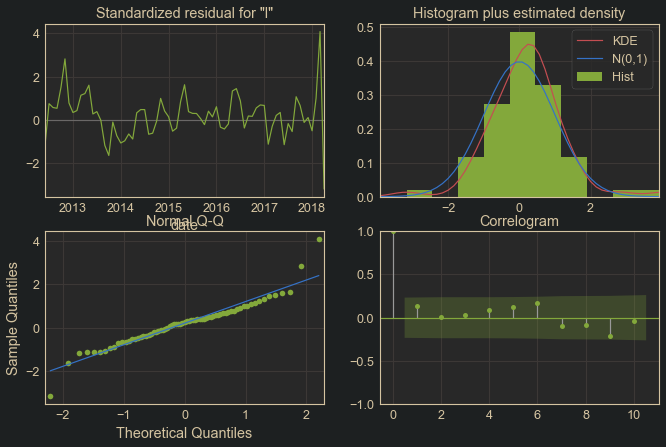

In [541]:
model.plot_diagnostics();

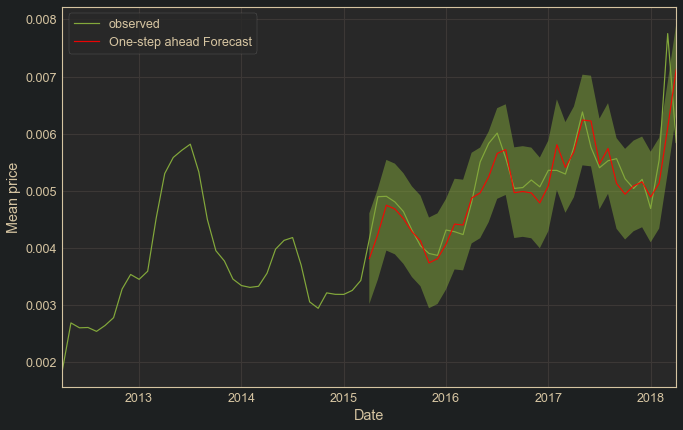

In [542]:
# Get predictions
pred = model.get_prediction()
pred_conf = pred.conf_int().loc['2015-04':]
# Plot observed values
ax = log_returns_trim.plot(label='observed')
# Plot predicted values
pred.predicted_mean.loc['2015-04':].plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_conf.index, 
                pred_conf.iloc[:, 0], 
                pred_conf.iloc[:, 1],
                alpha=0.5
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [543]:
# We can see this model is not performing well... it seems the residuals are highly
# autocorrelated
forecasted = pred.predicted_mean
truth = log_returns_trim

# Compute the mean square error
mse = np.mean((forecasted - truth) ** 2)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 10)))

The Mean Squared Error of our forecasts is 2.512e-07


In [544]:
# This mean squared error is slightly better

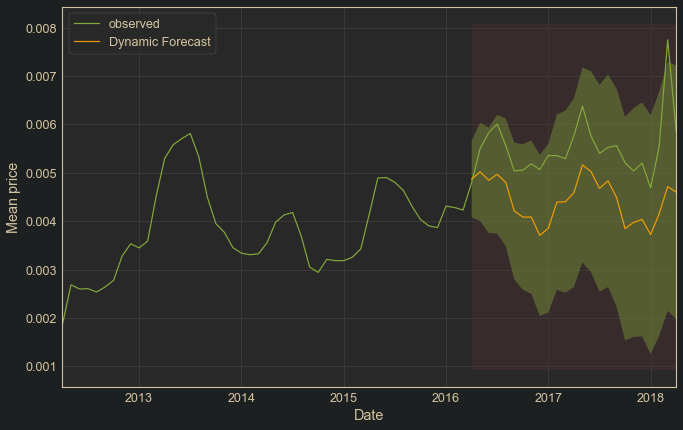

In [545]:
# Get dynamic predictions with confidence intervals
pred_dynamic = model.get_prediction(start='2016-04', end='2018-04', dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

# Plot observed values
ax = log_returns_trim.plot(label='observed')
# Plot predicted values
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange', alpha=0.9)
# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index, 
                pred_dynamic_conf.iloc[:, 0], 
                pred_dynamic_conf.iloc[:, 1],
                alpha=0.4
               )
ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2016-04'), 
                pred_dynamic.predicted_mean.index[-1],
                alpha=0.1,
                zorder=-1
               )
# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Mean price')
plt.legend()
plt.show()

In [546]:
# The model using fourier series to account for seasonality is performing better than using
# the seasonal component of the SARIMA model for this data. The MSE is slightly better than 
# it was for the model without the exogenous variable.

#### Notes so far:
Well, it has been quite a ride trying to model the market data. We have looked at the entire data series, incorporating fourier series, filtering heteroscedasticity, and limiting the time window in order to try and find the best models possible. Fourier series have seemed to help in most cases they were employed, but the only problem is that we have used lookahead bias in generating them so far, so more work should be done to see if they truly help forecasting on unseen data. Filtering heteroscedasticity and limiting the time window both had disappointing results as far as improving model accuracy, though the limited time window models were slightly more accurate than the ARIMA(3,1,1) model on the full data. Since it is not really a major part of this project to perfectly model the market data, I think that this is where I will stop, moving on with all of the things we have learned so far by trying to optimize these models to go to modeling the individual zip codes that we selected in the last notebook as the top performing in the data.